This is for Chapter 12 and Week 7 homework from [Winter 2020 of Statistical Rethinking](https://github.com/rmcelreath/stat_rethinking_2020/tree/main/homework) using Python. A public repo using `pmyc3` has been created [here](https://github.com/pymc-devs/resources/tree/master/Rethinking_2) that also uses Python.

Note that this notebook includes code for the "censored cats" discussion that was in the lecture but did not make the final, second edition section of the book. However, there's [tidyverse code](https://bookdown.org/content/4857/god-spiked-the-integers.html#bonus-survival-analysis) for this section on survival analysis. The Bayes discourse group also helped me. Thanks to Rojan for sharing his pymc code and Nathaniel for sending me pages of this section that were in a draft version of the book.

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
from scipy.special import expit as logistic
import theano.tensor as tt
import daft
from causalgraphicalmodels import CausalGraphicalModel

from scipy.optimize import curve_fit

In [3]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [4]:
sns.set_context("talk")

<IPython.core.display.Javascript object>

In [5]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

# Censored cats and survival analysis

These concepts were covered in lecture 13 [here](https://youtu.be/p7g-CgGCS34?list=PLDcUM9US4XdNM4Edgs7weiyIguLSToZRI&t=1433). I used the R `rethinking` package to obtain the data. The question is to determine whether black cats are more discriminated against for adoption than other cats.


In [9]:
df_cats = pd.read_csv("other_data/AustinCats.csv", sep=",")
df_cats.head()

id  days_to_event                date_out out_event  \
0  A730601              1  07/08/2016 09:00:00 AM  Transfer   
1  A679549             25  06/16/2014 01:54:00 PM  Transfer   
2  A683656              4  07/17/2014 04:57:00 PM  Adoption   
3  A709749             41  09/22/2015 12:49:00 PM  Transfer   
4  A733551              9  09/01/2016 12:00:00 AM  Transfer   

                  date_in in_event                   breed              color  \
0  07/07/2016 12:11:00 PM    Stray  Domestic Shorthair Mix         Blue Tabby   
1  05/22/2014 03:43:00 PM    Stray  Domestic Shorthair Mix        Black/White   
2  07/13/2014 01:20:00 PM    Stray            Snowshoe Mix         Lynx Point   
3  08/12/2015 06:29:00 PM    Stray  Domestic Shorthair Mix             Calico   
4  08/23/2016 02:35:00 PM    Stray  Domestic Shorthair Mix  Brown Tabby/White   

   intake_age  
0           7  
1           1  
2           2  
3          12  
4           1

<IPython.core.display.Javascript object>

In [12]:
df_cats.shape

(22356, 11)

<IPython.core.display.Javascript object>

Prepare dataframe as described in the lecture.

In [15]:
# Getting adopted is 1
df_cats["adopt"] = np.where(df_cats["out_event"] == "Adoption", 1, 0)

# It looks like he used black as lower index
df_cats["color_id"] = np.where(df_cats["color"] == "Black", 0, 1)

df_cats.head(10)

id  days_to_event                date_out out_event  \
0  A730601              1  07/08/2016 09:00:00 AM  Transfer   
1  A679549             25  06/16/2014 01:54:00 PM  Transfer   
2  A683656              4  07/17/2014 04:57:00 PM  Adoption   
3  A709749             41  09/22/2015 12:49:00 PM  Transfer   
4  A733551              9  09/01/2016 12:00:00 AM  Transfer   
5  A756485              4  08/24/2017 05:34:00 PM  Adoption   
6  A732960              4  08/19/2016 06:27:00 PM  Adoption   
7  A664571              5  10/10/2013 02:07:00 PM  Adoption   
8  A727402             24  06/14/2016 04:18:00 PM  Adoption   
9  A749579              2  05/18/2017 03:36:00 PM  Transfer   

                  date_in         in_event                   breed  \
0  07/07/2016 12:11:00 PM            Stray  Domestic Shorthair Mix   
1  05/22/2014 03:43:00 PM            Stray  Domestic Shorthair Mix   
2  07/13/2014 01:20:00 PM            Stray            Snowshoe Mix   
3  08/12/2015 06:29:00 PM            Stray  Domestic Shorthair Mix   
4  08/23/2016 02:35:00 PM            Stray  Domestic Shorthair Mix   
5  08/20/2017 03:07:00 PM            Stray  Domestic Shorthair Mix   
6  08/15/2016 03:08:00 PM            Stray  Domestic Shorthair Mix   
7  10/05/2013 01:43:00 PM  Owner Surrender  Domestic Shorthair Mix   
8  05/21/2016 04:30:00 PM            Stray  Domestic Shorthair Mix   
9  05/16/2017 05:19:00 PM            Stray  Domestic Shorthair Mix   

               color  intake_age  adopt  color_id     color_id  
0         Blue Tabby           7      0            1         1  
1        Black/White           1      0            1         1  
2         Lynx Point           2      1            1         1  
3             Calico          12      0            1         1  
4  Brown Tabby/White           1      0            1         1  
5         Blue Tabby           1      1            1         1  
6             Calico           2      1            1         1  
7             Torbie          24      1            1         1  
8        Brown Tabby           1      1            1         1  
9         Blue Tabby           3      0            1         1

<IPython.core.display.Javascript object>

In [17]:
df_cats["color_id"].value_counts()

1    19391
0     2965
Name: color_id, dtype: int64

<IPython.core.display.Javascript object>

Rojan's code

```
def likelihood(lam,obs_value,censored):
    return (censored*tt.log(lam) - lam * obs_value)

with pm.Model() as m_1:
   cid=pm.Data('cid',df['black'])
    adopted=pm.intX(pm.Data('adopted',df['adopted']))
    a=pm.Normal('a',0,1,shape=2)
    mu = pm.math.exp(a[cid])
    lam= pm.Deterministic('lam',1/mu)
 D=pm.Potential('D',likelihood(lam=lam,obs_value=df['days_to_event'].values,censored=adopted))
  trace_1=pm.sample()

```

In [18]:
def likelihood(lam, obs_value, censored):
    return censored * tt.log(lam) - lam * obs_value

<IPython.core.display.Javascript object>

In [20]:
with pm.Model() as m_cats1:
    # priors
    a = pm.Normal("a", 0, 1, shape=2)

    mu = pm.math.exp(a[df_cats["color_id"]])
    lam = pm.Deterministic("lam", 1 / mu)

    D = pm.Potential(
        "D",
        likelihood(
            lam=lam,
            obs_value=df_cats["days_to_event"].values,
            censored=df_cats["adopt"],
        ),
    )

    trace_1 = pm.sample(1000, tune=1000, return_inferencedata=True)

NameError: name 'tt' is not defined

<IPython.core.display.Javascript object>

# 12H1

Inthisproblem,you’ll focus on predicting deaths using femininity of each hurricane’s name. Fit and interpret the simplest possible model, a Poisson model of deaths using femininity as a predictor. Compare the model to an intercept-only Poisson model of deaths. How strong istheasso-
ciationbetweenfemininityofnameanddeaths?Whichstormsdoesthemodelfit(retrodict)well?
Whichstormsdoesitfitpoorly

In [43]:
df_hurricanes = pd.read_csv(
    "../pymc3_ed_resources/resources/Rethinking/Data/hurricanes.csv",
    delimiter=";",
)
df_hurricanes.head(10)

name  year  deaths  category  min_pressure  damage_norm  female  \
0      Easy  1950       2         3           960         1590       1   
1      King  1950       4         3           955         5350       0   
2      Able  1952       3         1           985          150       0   
3   Barbara  1953       1         1           987           58       1   
4  Florence  1953       0         1           985           15       1   
5     Carol  1954      60         3           960        19321       1   
6      Edna  1954      20         3           954         3230       1   
7     Hazel  1954      20         4           938        24260       1   
8    Connie  1955       0         3           962         2030       1   
9     Diane  1955     200         1           987        14730       1   

   femininity  
0     6.77778  
1     1.38889  
2     3.83333  
3     9.83333  
4     8.33333  
5     8.11111  
6     8.55556  
7     9.44444  
8     8.50000  
9     9.88889

<IPython.core.display.Javascript object>

In [44]:
df_hurricanes["femininity_std"] = standardize(df_hurricanes["femininity"])

<IPython.core.display.Javascript object>

In [46]:
with pm.Model() as m12_1:

    a = pm.Normal("a", 1.0, 0.5)
    b = pm.Normal("b", 1.0, 0.5)

    lamb = pm.math.exp(np.log(a) + b * df_hurricanes["femininity_std"])

    y = pm.Poisson("y", lamb, observed=df_hurricanes["deaths"])

    # Get posterior
    trace_12_1 = pm.sample(random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
INFO:pymc3:NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


<IPython.core.display.Javascript object>

In [47]:
az.summary(trace_12_1)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a  12.999  0.270    12.559     13.426      0.005    0.004    2944.0  2937.0   
b   0.380  0.033     0.329      0.433      0.001    0.000    2747.0  2737.0   

   ess_bulk  ess_tail  r_hat  
a    2944.0    2767.0    1.0  
b    2729.0    2494.0    1.0

<IPython.core.display.Javascript object>

In [48]:
with pm.Model() as m12_1_int:

    a = pm.Normal("a", 1.0, 0.5)

    lamb = pm.math.exp(np.log(a))

    y = pm.Poisson("y", lamb, observed=df_hurricanes["deaths"])

    # Get posterior
    trace_12_1_int = pm.sample(random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
INFO:pymc3:NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


<IPython.core.display.Javascript object>

In [49]:
az.summary(trace_12_1_int)

mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a  13.413  0.26    13.021     13.851      0.006    0.004    1836.0  1835.0   

   ess_bulk  ess_tail  r_hat  
a    1831.0    2510.0    1.0

<IPython.core.display.Javascript object>

# 12H6 Fish


The data in `data(Fish)` are records of visits to a national park. The question of interest is how many fish an average visitor takes per hour, when fishing. The problem is that not everyone tried to fish, so the `fish_caught` numbers are zero-inflated. As with the monks example in the chapter, there is a process that determines who is fishing (`working`) and another process that determines fish per hour (`manuscripts per day`), conditional on fishing (`working`). We want to model both.Otherwisewe’llendupwithanunderestimateofrateoffishextractionfromthepark.
Youwillmodelthesedatausingzero-inflatedPoissonGLMs.Predict fish_caught asafunction
ofanyoftheothervariablesyouthinkarerelevant.Onethingyoumustdo,however,isuseaproper
Poissonoffset/exposureinthePoissonportionofthezero-inflatedmodel.Thenusethe hours vari-
abletoconstructtheoffset.Thiswilladjustthemodelforthedifferingamountoftimeindividuals
spentinthepar

In [6]:
df_fish = pd.read_csv(
    "../pymc3_ed_resources/resources/Rethinking/Data/fish.csv",
    delimiter=";",
)
df_fish.head(10)

fish_caught  livebait  camper  persons  child   hours
0            0         0       0        1      0  21.124
1            0         1       1        1      0   5.732
2            0         1       0        1      0   1.323
3            0         1       1        2      1   0.548
4            1         1       0        1      0   1.695
5            0         1       1        4      2   0.493
6            0         1       0        3      1   0.033
7            0         1       0        4      3   0.004
8            0         0       1        3      2   0.217
9            1         1       1        1      0   4.031

<IPython.core.display.Javascript object>

<AxesSubplot:>

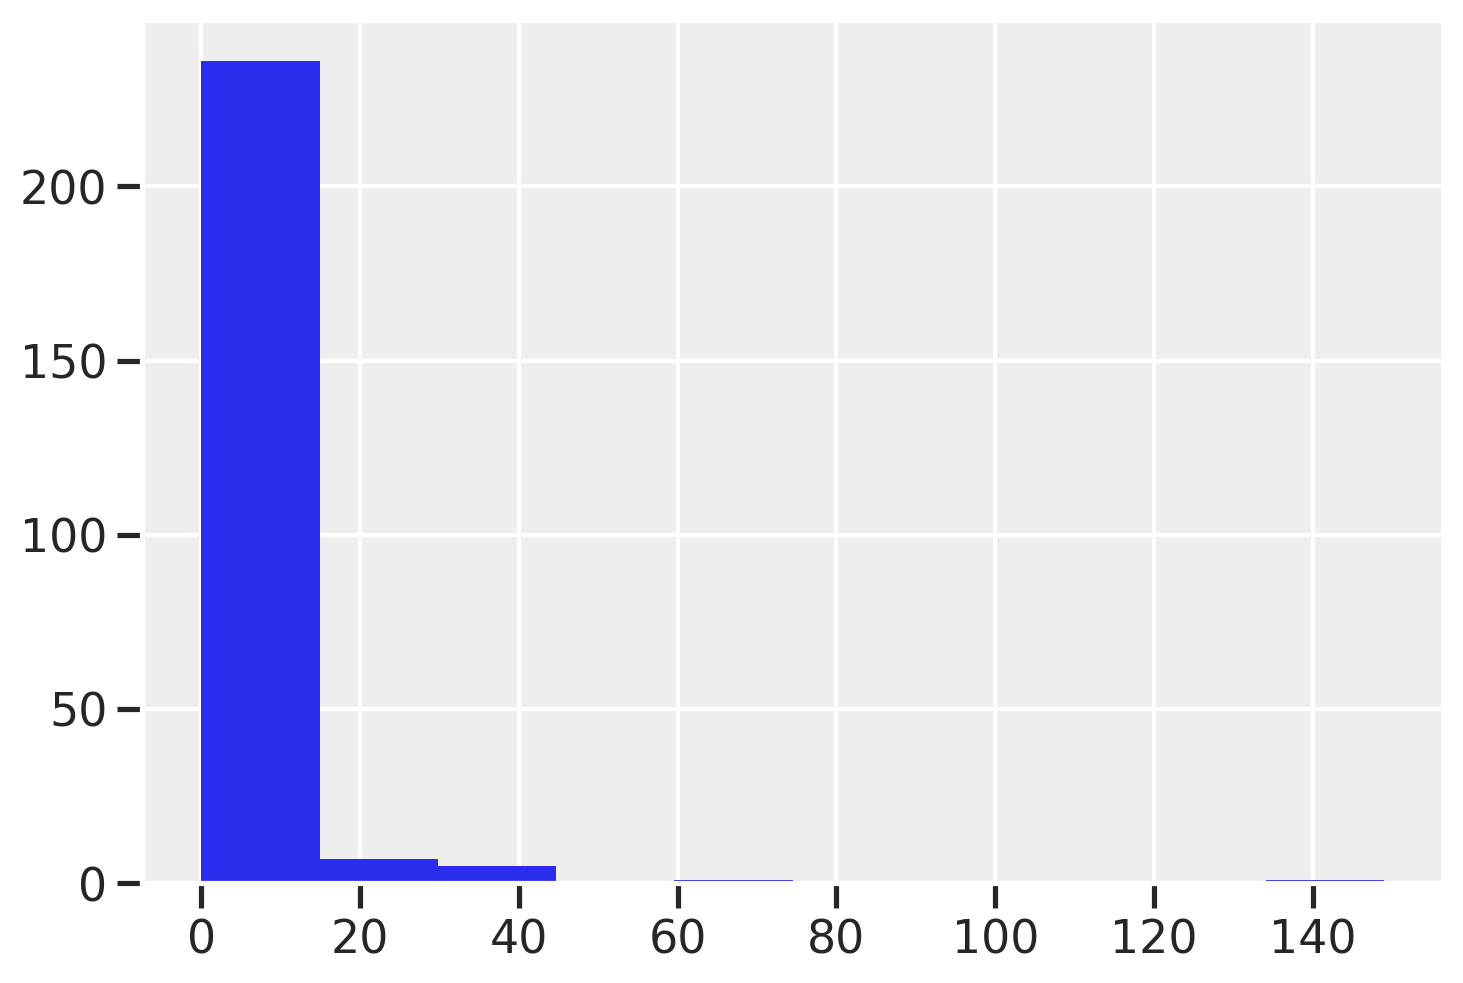

<IPython.core.display.Javascript object>

In [7]:
df_fish["fish_caught"].hist()

In [8]:
df_fish.shape

(250, 6)

<IPython.core.display.Javascript object>

My understanding of an offset is that it handles cases where the time interval units are different. I'm not sure if I'm doing this right but will give this a shot.


$$y_i \text{ ~ } \text{ZIPoisson}(p_i,\mu_i) $$ 

$$\text{logit}(p_i) = \alpha_{[\text{LIVEBAIT}]}$$ 

$$\text{log}(\mu_i) = \text{log}(\tau _i) + \alpha_{\text{[LIVEBAIT]}} $$ 

*p* represents the probability that the person intends to fish (has live bait).

*tau* represents the hours in the park, serving as the offset

*mu* is the adjusted rate parameter (essentially serving the place of *lambda*.


In [ ]:
# repo code above
# with pm.Model() as m12_3:
#     ap = pm.Normal("ap", -1.5, 1.0)   
#     al = pm.Normal("al", 1.0, 0.5)

#     p = pm.math.invlogit(ap)
#     lambda_ = pm.math.exp(al)

#     y_obs = pm.ZeroInflatedPoisson("y_obs", 1.0 - p, lambda_, observed=y)

In [9]:
with pm.Model() as m12_6:
    # intercept only model
    ap = pm.Normal(
        "ap", -1.5, 1.0
    )  # Keep mass below 0 since most visitors probably don't fish
    am = pm.Normal("am", 1.0, 0.5)

    p = pm.math.invlogit(ap)
    mu = pm.math.exp(np.log(am))
    
    # 1-p because the documentation states that p here is for the 0's not the 1's
    
    y = pm.ZeroInflatedPoisson("y", 1-p, mu, observed=df_fish["fish_caught"])   

    # Get posterior
    trace_12_6 = pm.sample(random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [am, ap]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


<IPython.core.display.Javascript object>

In [10]:
az.summary(trace_12_6)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
ap  0.247  0.128     0.039      0.446      0.002    0.002    3414.0  3026.0   
am  6.351  0.200     6.032      6.677      0.003    0.002    3340.0  3340.0   

    ess_bulk  ess_tail  r_hat  
ap    3411.0    3022.0    1.0  
am    3338.0    2209.0    1.0

<IPython.core.display.Javascript object>

In [28]:
from scipy.special import logit
# check it's a probability to get back
np.exp(-0.291)


0.747515678018091

<IPython.core.display.Javascript object>

In [52]:
with pm.Model() as m12_6a:

    # model with livebait interaction variable
    ap = pm.Normal(
        "ap", -1.5, 1.0, shape=2
    )  # Keep mass below 0 since most visitors probably don't fish
    am = pm.Normal("am", 1.0, 0.5, shape=2)

    p = pm.math.invlogit(ap[df_fish["livebait"]])
    mu = pm.math.exp(np.log(am[df_fish["livebait"]]))

    y = pm.ZeroInflatedPoisson("y", 1 - p, mu, observed=df_fish["fish_caught"])

    # Get posterior
    trace_12_6a = pm.sample(random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [am, ap]
INFO:pymc3:NUTS: [am, ap]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


<IPython.core.display.Javascript object>

In [53]:
az.summary(trace_12_6a)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
ap[0] -0.222  0.634    -1.161      0.778      0.016    0.014    1555.0   
ap[1]  0.153  0.137    -0.062      0.375      0.002    0.002    3507.0   
am[0]  1.149  0.311     0.661      1.641      0.006    0.004    2541.0   
am[1]  6.667  0.210     6.334      7.000      0.003    0.002    3681.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
ap[0]  1053.0    1940.0    1234.0    1.0  
ap[1]  3167.0    3505.0    2900.0    1.0  
am[0]  2541.0    2306.0    2090.0    1.0  
am[1]  3669.0    3704.0    3031.0    1.0

<IPython.core.display.Javascript object>

In [35]:
from scipy.stats import poisson

<IPython.core.display.Javascript object>

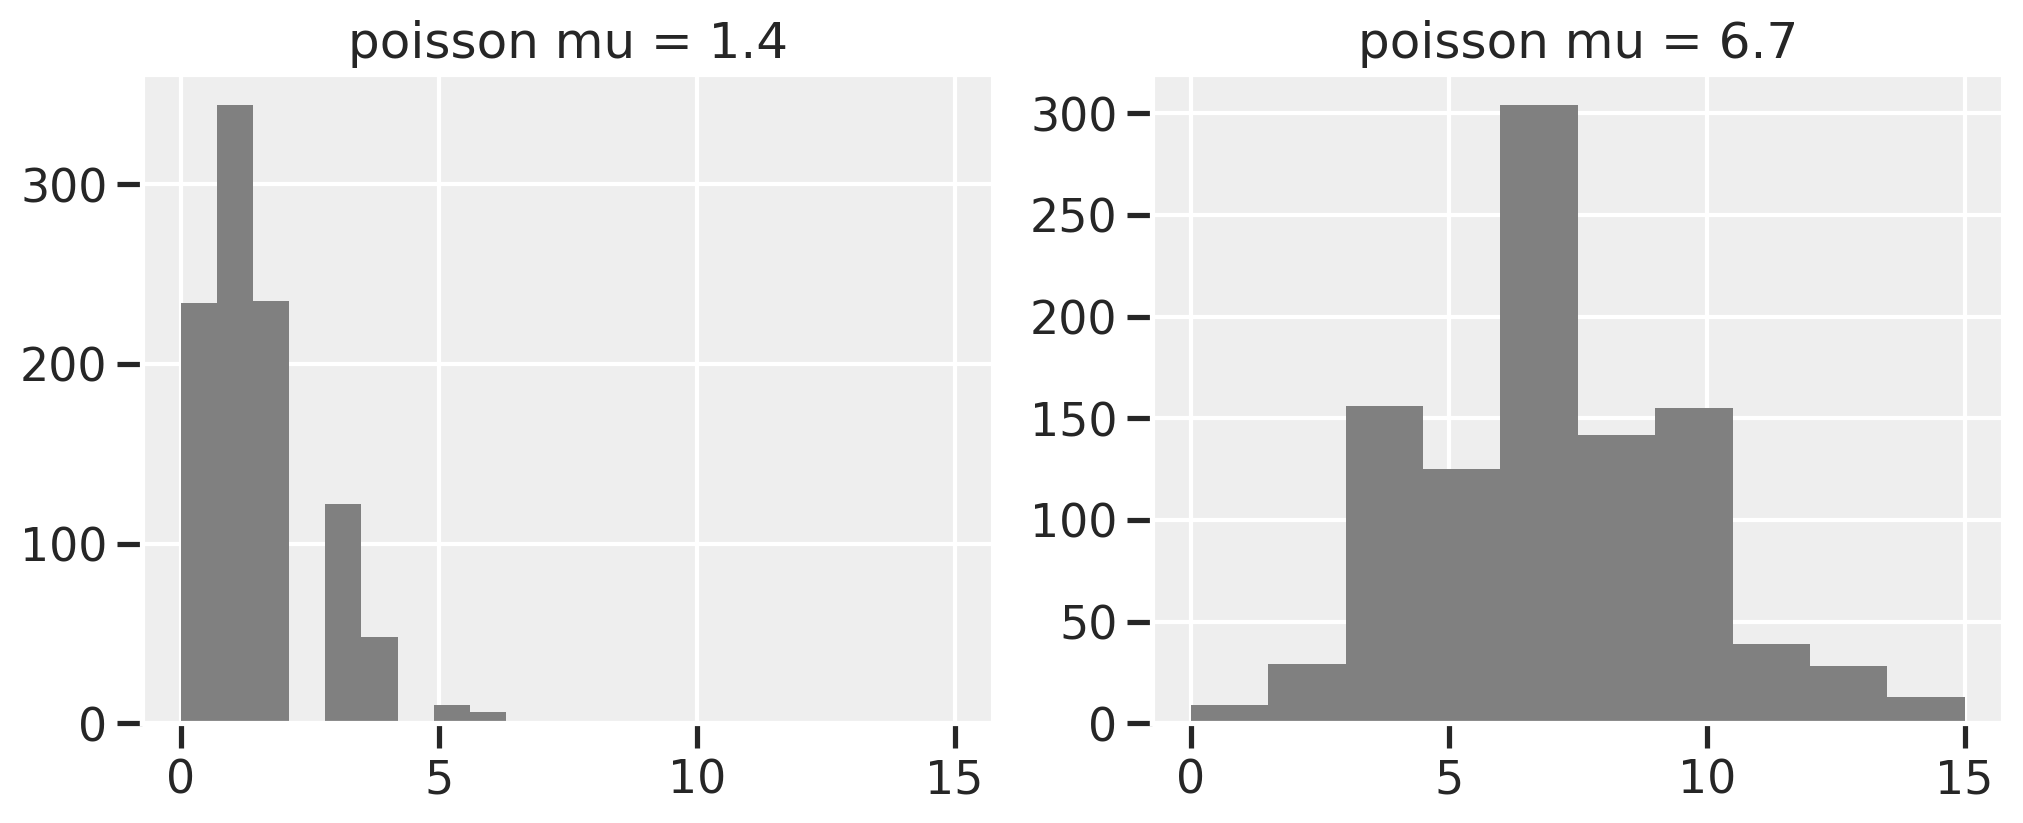

<IPython.core.display.Javascript object>

In [41]:
f, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
for i, ax in zip([1.4, 6.7], axes.flat):
    r = poisson.rvs(i, size=1000)
    ax.hist(r, color="gray")
    ax.set_title(f"poisson mu = {i}")

# Question 1 (12H7)

In the Trolley data—`data(Trolley)`—we saw how education level (modeled as an ordered category) is associated with responses. Is this association causal? One plausible confound is that education is also associated with age, through a causal process: People are older when they finish school than when they begin it.

Reconsider the Trolley data in this light. Draw a DAG that represents hypothetical causal relationships among response, education, and age. Which statistical model or models do you need to evaluate the causal influence of education on responses? Fit these models to the trolley data. What do you conclude about the causal relationships among these three variables?

## Data exploration and setup

In [9]:
df_trolley = pd.read_csv(
    "../pymc3_ed_resources/resources/Rethinking_2/Data/Trolley.csv",
    delimiter=";",
)
df_trolley.head()

case  response  order      id  age  male            edu  action  \
0  cfaqu         4      2  96;434   14     0  Middle School       0   
1  cfbur         3     31  96;434   14     0  Middle School       0   
2  cfrub         4     16  96;434   14     0  Middle School       0   
3  cibox         3     32  96;434   14     0  Middle School       0   
4  cibur         3      4  96;434   14     0  Middle School       0   

   intention  contact story  action2  
0          0        1   aqu        1  
1          0        1   bur        1  
2          0        1   rub        1  
3          1        1   box        1  
4          1        1   bur        1

<IPython.core.display.Javascript object>

In [10]:
print("shape of df: ", df_trolley.shape)

shape of df:  (9930, 12)


<IPython.core.display.Javascript object>

## Original model

Before working on the problem, I'd like to make sure I understood the book chapter code well and reproduce the results, before adding the education variable.

### Model equation

$$R_i \text{ ~ } \text{Ordered-logit}(\phi_i,\kappa) \tag{probability of data}$$ 

$$\phi_i = 0 \tag{linear model}$$ 

$$\kappa_k \text{ ~ } \text{Normal}(0, 1.5) \tag{common prior for each intercept}$$

However, he states that the model can be re-written more literally where we instead use a vector of probabilities **p**.

$$R_i \text{ ~ } \text{Categorical}(\boldsymbol{p}) \tag{probability of data}$$

$$p_1 = q_1 \tag{probabilities of each value k}$$ 

$$p_k = q_k - q_{k-1} \text{  for $K > k > 1$} $$

$$p_k = 1 - q_{k-1} $$

$$\text{logit}(q_k) = \kappa_k - \phi_i  \tag{cumulative logit link}$$ 

$$\phi_i = \text{terms of linear model}  \tag{linear model}$$

$$\kappa_k \text{ ~ } \text{Normal}(0, 1.5)  \tag{common prior for each intercept}$$



Note that McElreath uses Greek letter \(\kappa\) (kappa) to refer to the intercepts but he switches to using \(\alpha\) later.


### Intercept only model

The intercepts represent the cutpoints in the cumulative probability graph. We should expect the posterior distribution cutpoints to monotonically increase after we run this code.

Here is the setup in pymc as taken from the repo. Per McElreath's text: "In code form for either quap and ulam, the link function will be embedded in the likelihood function already." McElreath cautions that this can take a while but it only took ~30 seconds for me.

In [9]:
with pm.Model() as m12_4:

    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6) - 2.5,  # array([-2.5, -1.5, -0.5,  0.5,  1.5,  2.5])
    )

    R = pm.OrderedLogistic("R", 0.0, cutpoints, observed=df_trolley["response"] - 1)

    # Get posterior
    trace_12_4 = pm.sample(random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


<IPython.core.display.Javascript object>

Let's get our trace object back as a dataframe and inspect.

In [11]:
trace_12_4_df = trace_12_4.to_dataframe()
trace_12_4_df.head()

chain  draw  (posterior, cutpoints[0], 0)  (posterior, cutpoints[1], 1)  \
0      0     0                     -1.944997                     -1.271992   
1      0     1                     -1.891395                     -1.259263   
2      0     2                     -1.902102                     -1.269827   
3      0     3                     -1.913761                     -1.259292   
4      0     4                     -1.886907                     -1.256226   

   (posterior, cutpoints[2], 2)  (posterior, cutpoints[3], 3)  \
0                     -0.723195                      0.262819   
1                     -0.718099                      0.223384   
2                     -0.699676                      0.270881   
3                     -0.734792                      0.225806   
4                     -0.724622                      0.226160   

   (posterior, cutpoints[4], 4)  (posterior, cutpoints[5], 5)  \
0                      0.889961                      1.767569   
1                      0.871716                      1.732266   
2                      0.904259                      1.786165   
3                      0.879706                      1.766346   
4                      0.851608                      1.738584   

   (log_likelihood, R[0], 0)  (log_likelihood, R[1000], 1000)  ...  \
0                  -1.432802                        -1.432802  ...   
1                  -1.479273                        -1.479273  ...   
2                  -1.446362                        -1.446362  ...   
3                  -1.460722                        -1.460722  ...   
4                  -1.470006                        -1.470006  ...   

   (sample_stats, mean_tree_accept)  (sample_stats, tree_size)  \
0                          0.907547                        7.0   
1                          0.812892                        7.0   
2                          0.979887                        7.0   
3                          0.985648                        7.0   
4                          0.390269                        7.0   

   (sample_stats, diverging)  (sample_stats, depth)  \
0                      False                      3   
1                      False                      3   
2                      False                      3   
3                      False                      3   
4                      False                      3   

   (sample_stats, step_size_bar)  (sample_stats, energy)  \
0                       0.608521            18938.422333   
1                       0.608521            18936.294713   
2                       0.608521            18936.865974   
3                       0.608521            18937.144085   
4                       0.608521            18940.391810   

   (sample_stats, perf_counter_diff)  (sample_stats, lp)  \
0                           0.002192       -18934.589937   
1                           0.002331       -18935.223347   
2                           0.002756       -18934.804766   
3                           0.002226       -18934.686169   
4                           0.002972       -18935.640649   

   (sample_stats, max_energy_error)  (sample_stats, step_size)  
0                          0.232490                   0.626648  
1                          0.511403                   0.626648  
2                         -0.355113                   0.626648  
3                         -0.222621                   0.626648  
4                          5.562225                   0.626648  

[5 rows x 9951 columns]

<IPython.core.display.Javascript object>

I did not inspect too closely but nothing seems out of the ordinary at first glance. Now let's take a look at the summary to see what the cutpoint values look like.

In [13]:
az.summary(trace_12_4)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
cutpoints[0] -1.917  0.030    -1.961     -1.866        0.0      0.0    4392.0   
cutpoints[1] -1.266  0.024    -1.302     -1.226        0.0      0.0    4999.0   
cutpoints[2] -0.718  0.022    -0.753     -0.685        0.0      0.0    5227.0   
cutpoints[3]  0.248  0.020     0.219      0.283        0.0      0.0    4775.0   
cutpoints[4]  0.890  0.022     0.856      0.926        0.0      0.0    4918.0   
cutpoints[5]  1.770  0.029     1.727      1.817        0.0      0.0    5106.0   

              ess_sd  ess_bulk  ess_tail  r_hat  
cutpoints[0]  4392.0    4396.0    2633.0    1.0  
cutpoints[1]  4999.0    4997.0    3517.0    1.0  
cutpoints[2]  5221.0    5203.0    3520.0    1.0  
cutpoints[3]  4735.0    4795.0    3613.0    1.0  
cutpoints[4]  4918.0    4883.0    3542.0    1.0  
cutpoints[5]  5094.0    5125.0    3798.0    1.0

<IPython.core.display.Javascript object>

The cutpoints are increasing monotonically as expected. As a reminder, these values are logit values, meaning we have to apply logistic to get back interpretable probabilities. The seventh and final cutpoint is always omitted since that, by definition, is 1 (after applying logistic). Trying to get the logit value is also not practical since logit(1) is infinity as shown below.

In [14]:
from scipy.special import logit

print(logit(0.90))
print(logit(0.9999))
print(logit(1))

2.1972245773362196
9.21024036697596
inf


<IPython.core.display.Javascript object>

Now let's get the cumulative probabilities back using the logistic function.

In [15]:
cutpoints_mean = trace_12_4_df[
    [("posterior", "cutpoints" + str([i]), i) for i in range(6)]
].mean()

# Get cumulative probabilities back
logistic(cutpoints_mean.round(3))

(posterior, cutpoints[0], 0)    0.128196
(posterior, cutpoints[1], 1)    0.219943
(posterior, cutpoints[2], 2)    0.327834
(posterior, cutpoints[3], 3)    0.561684
(posterior, cutpoints[4], 4)    0.708890
(posterior, cutpoints[5], 5)    0.854458
dtype: float64

<IPython.core.display.Javascript object>

Now let's move on to the model where we add predictor variables.

### Model with predictor variables

We'll define a linear model $\phi_i = \beta x_i$, then each cumulative logit becomes:

$$\text{log} \frac{\text{Pr}(y_i \leq k)}{1-\text{Pr}(y_i \leq k)} = \alpha_k - \phi_i $$

$$\phi_i = \beta x_i$$


Note here \(\alpha\) is referring to the intercept term when he had used \(\kappa\) before. The predictor variables are `action`, `intention`, and `contact` coded as indicator variables. The likelihood doesn't change. Let's remind ourselves how the dataframe looks.

In [16]:
df_trolley.head()

case  response  order      id  age  male            edu  action  \
0  cfaqu         4      2  96;434   14     0  Middle School       0   
1  cfbur         3     31  96;434   14     0  Middle School       0   
2  cfrub         4     16  96;434   14     0  Middle School       0   
3  cibox         3     32  96;434   14     0  Middle School       0   
4  cibur         3      4  96;434   14     0  Middle School       0   

   intention  contact story  action2  
0          0        1   aqu        1  
1          0        1   bur        1  
2          0        1   rub        1  
3          1        1   box        1  
4          1        1   bur        1

<IPython.core.display.Javascript object>

This cell took a little bit longer to run. Let's use most of the repo code for creating and running this model.

I am not 100% sure but I believe the adjustment made here `observed=df_trolley["response"]-1` is to account for Python 0 indexing.

In [17]:
with pm.Model() as m12_5:
    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6) - 2.5,
    )
    bA = pm.Normal("bA", 0.0, 0.5)
    bC = pm.Normal("bC", 0.0, 0.5)
    bI = pm.Normal("bI", 0.0, 0.5)
    bIA = pm.Normal("bIA", 0.0, 0.5)
    bIC = pm.Normal("bIC", 0.0, 0.5)

    A = pm.Data("A", df_trolley["action"])
    I = pm.Data("I", df_trolley["intention"])
    C = pm.Data("C", df_trolley["contact"])
    
    # This defines the interaction of intention between action and contact
    BI = bI + bIA * A + bIC * C
    phi = pm.Deterministic("phi", bA * A + bC * C + BI * I)

    resp_obs = pm.OrderedLogistic(
        "resp_obs", phi, cutpoints, observed=df_trolley["response"]-1     # 
    )

    trace_12_5 = pm.sample(random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bIC, bIA, bI, bC, bA, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 120 seconds.


<IPython.core.display.Javascript object>

#### Prior predictions of cutpoints

In [18]:
with m12_5:
    prior_pc = pm.sample_prior_predictive(var_names=["cutpoints"])

prior_pc

{'cutpoints': array([[ 0.4829748 , -0.66830496, -1.82323996, -1.3544437 ,  0.1927315 ,
          2.03145122],
        [-2.45846252,  0.86345799, -1.03185964, -2.59275704,  0.07559416,
         -1.48363566],
        [-1.70232248,  2.67121702, -1.21962682,  0.91437455, -3.08300344,
          0.6479137 ],
        ...,
        [-2.46078188,  0.59585646,  1.20482999, -1.60165107, -1.44837751,
         -1.30090619],
        [-2.17248438, -0.43314908, -1.72181921,  1.4220979 , -2.33111929,
         -1.07865684],
        [ 1.38872813, -0.13289177, -1.46700193,  0.07369532, -1.32569279,
         -1.264418  ]])}

<IPython.core.display.Javascript object>

In [19]:
# take the mean - I think they're going to be the same for each value which is not unexpected
prior_pc["cutpoints"].mean(axis=0)

array([ 0.03246492, -0.04754484, -0.07173158,  0.06972068, -0.00063593,
        0.09832941])

<IPython.core.display.Javascript object>

In [20]:
prior_pc["cutpoints"].std(axis=0)

array([1.50555604, 1.49764051, 1.62108526, 1.41274325, 1.48364159,
       1.50020002])

<IPython.core.display.Javascript object>

In [21]:
np.arange(6) - 2.5

array([-2.5, -1.5, -0.5,  0.5,  1.5,  2.5])

<IPython.core.display.Javascript object>

In [22]:
# code frm repo
# idata = az.from_pymc3(trace_12_5)
# az.summary(idata, var_names=["bIC", "bIA", "bC", "bI", "bA"], round_to=2)

<IPython.core.display.Javascript object>

In [23]:
trace_12_5_df = trace_12_5.to_dataframe()
trace_12_5_df.head()

chain  draw  (posterior, bA)  (posterior, bC)  (posterior, bI)  \
0      0     0        -0.505141        -0.318802        -0.327815   
1      0     1        -0.434830        -0.457989        -0.304971   
2      0     2        -0.450218        -0.377510        -0.326047   
3      0     3        -0.388423        -0.407774        -0.188328   
4      0     4        -0.423833        -0.255446        -0.319680   

   (posterior, bIA)  (posterior, bIC)  (posterior, cutpoints[0], 0)  \
0         -0.425470         -1.150018                     -2.660330   
1         -0.424522         -1.105279                     -2.626617   
2         -0.446714         -1.213259                     -2.624070   
3         -0.518498         -1.236109                     -2.593273   
4         -0.496148         -1.199826                     -2.593342   

   (posterior, cutpoints[1], 1)  (posterior, cutpoints[2], 2)  ...  \
0                     -1.955481                     -1.376935  ...   
1                     -1.932367                     -1.321066  ...   
2                     -1.949052                     -1.343156  ...   
3                     -1.898340                     -1.309335  ...   
4                     -1.894928                     -1.311964  ...   

   (sample_stats, mean_tree_accept)  (sample_stats, tree_size)  \
0                          0.808162                       31.0   
1                          0.958164                        7.0   
2                          0.750045                       15.0   
3                          0.726710                       15.0   
4                          0.838496                       23.0   

   (sample_stats, diverging)  (sample_stats, depth)  \
0                      False                      5   
1                      False                      3   
2                      False                      4   
3                      False                      4   
4                      False                      5   

   (sample_stats, step_size_bar)  (sample_stats, energy)  \
0                       0.400154            18482.352379   
1                       0.400154            18481.945491   
2                       0.400154            18484.577023   
3                       0.400154            18485.363774   
4                       0.400154            18485.510930   

   (sample_stats, perf_counter_diff)  (sample_stats, lp)  \
0                           0.103104       -18476.163278   
1                           0.031628       -18477.479533   
2                           0.053246       -18477.445982   
3                           0.052855       -18481.317360   
4                           0.081051       -18476.097258   

   (sample_stats, max_energy_error)  (sample_stats, step_size)  
0                          1.673077                   0.392687  
1                         -0.233171                   0.392687  
2                          0.789485                   0.392687  
3                          0.889859                   0.392687  
4                          3.129888                   0.392687  

[5 rows x 19886 columns]

<IPython.core.display.Javascript object>

In [24]:
az.summary(trace_12_5, var_names=["bIC", "bIA", "bC", "bI", "bA"], round_to=2)

mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
bIC -1.24  0.10     -1.40      -1.09        0.0      0.0   2595.09  2595.09   
bIA -0.43  0.08     -0.57      -0.32        0.0      0.0   2444.25  2411.62   
bC  -0.34  0.07     -0.46      -0.24        0.0      0.0   2462.52  2450.59   
bI  -0.29  0.06     -0.39      -0.21        0.0      0.0   2204.02  2192.90   
bA  -0.47  0.05     -0.56      -0.39        0.0      0.0   2412.44  2412.44   

     ess_bulk  ess_tail  r_hat  
bIC   2602.01   3019.21    1.0  
bIA   2443.48   2557.96    1.0  
bC    2459.41   2884.44    1.0  
bI    2200.24   2552.76    1.0  
bA    2413.97   2218.64    1.0

<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

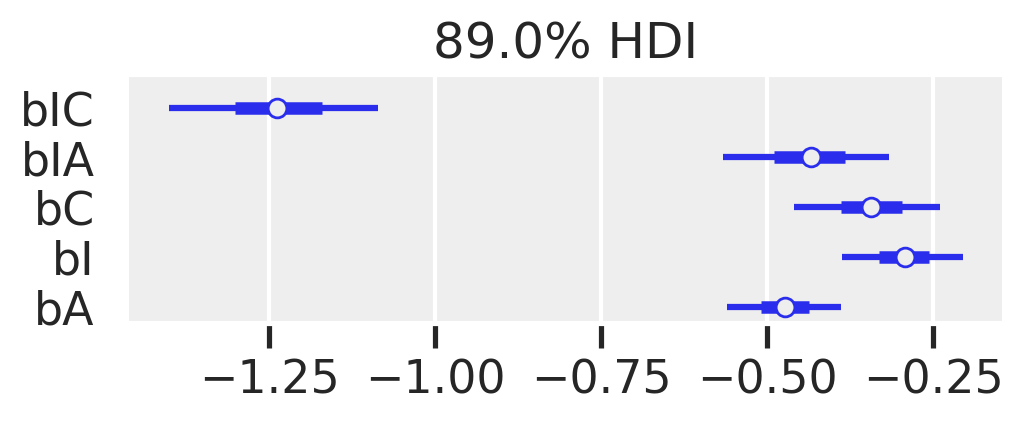

<IPython.core.display.Javascript object>

In [25]:
f, ax1 = plt.subplots(figsize=(5, 2))
az.plot_forest(
    trace_12_5, var_names=["bIC", "bIA", "bC", "bI", "bA"], combined=True, ax=ax1
)

This is showing the combination of intention and contact is the worst, despite the fact that each by themselves isn't showing a large impact on the ratings. Let's plot the posterior predictions.

#### Plot posterior predictions

It will be easier to understand, but this is a challenge since each prediction is a vector of probabilities. We'll need to create a function that generates these predictions using the parameters of our posterior predictions. We can use the full posterior (analagous to the `sim` function) or something akin to the `link` function. McElreath's  R code 12.27 uses link. Let's take a quick look at the posterior.

#### My own code

In [26]:
trace_12_5_df.head()

chain  draw  (posterior, bA)  (posterior, bC)  (posterior, bI)  \
0      0     0        -0.505141        -0.318802        -0.327815   
1      0     1        -0.434830        -0.457989        -0.304971   
2      0     2        -0.450218        -0.377510        -0.326047   
3      0     3        -0.388423        -0.407774        -0.188328   
4      0     4        -0.423833        -0.255446        -0.319680   

   (posterior, bIA)  (posterior, bIC)  (posterior, cutpoints[0], 0)  \
0         -0.425470         -1.150018                     -2.660330   
1         -0.424522         -1.105279                     -2.626617   
2         -0.446714         -1.213259                     -2.624070   
3         -0.518498         -1.236109                     -2.593273   
4         -0.496148         -1.199826                     -2.593342   

   (posterior, cutpoints[1], 1)  (posterior, cutpoints[2], 2)  ...  \
0                     -1.955481                     -1.376935  ...   
1                     -1.932367                     -1.321066  ...   
2                     -1.949052                     -1.343156  ...   
3                     -1.898340                     -1.309335  ...   
4                     -1.894928                     -1.311964  ...   

   (sample_stats, mean_tree_accept)  (sample_stats, tree_size)  \
0                          0.808162                       31.0   
1                          0.958164                        7.0   
2                          0.750045                       15.0   
3                          0.726710                       15.0   
4                          0.838496                       23.0   

   (sample_stats, diverging)  (sample_stats, depth)  \
0                      False                      5   
1                      False                      3   
2                      False                      4   
3                      False                      4   
4                      False                      5   

   (sample_stats, step_size_bar)  (sample_stats, energy)  \
0                       0.400154            18482.352379   
1                       0.400154            18481.945491   
2                       0.400154            18484.577023   
3                       0.400154            18485.363774   
4                       0.400154            18485.510930   

   (sample_stats, perf_counter_diff)  (sample_stats, lp)  \
0                           0.103104       -18476.163278   
1                           0.031628       -18477.479533   
2                           0.053246       -18477.445982   
3                           0.052855       -18481.317360   
4                           0.081051       -18476.097258   

   (sample_stats, max_energy_error)  (sample_stats, step_size)  
0                          1.673077                   0.392687  
1                         -0.233171                   0.392687  
2                          0.789485                   0.392687  
3                          0.889859                   0.392687  
4                          3.129888                   0.392687  

[5 rows x 19886 columns]

<IPython.core.display.Javascript object>

In [27]:
def link_pp(trace, post_bA, post_bC, post_bI, post_bIA, post_bIC, in_I, in_A, in_C):
    """
    Use the model definition to generate phi.
    Input: posterior parameters and values for I, A, C
    Output: Phi (no additional sigma term?)
    """

    BI = trace[post_bI] + trace[post_bIA] * in_A + trace[post_bIC] * in_C

    phi = trace[post_bA] * in_A + trace[post_bC] * in_C + BI * in_I

    return phi

<IPython.core.display.Javascript object>

In [28]:
phi_post_0 = link_pp(
    trace_12_5_df,
    ("posterior", "bA"),
    ("posterior", "bC"),
    ("posterior", "bI"),
    ("posterior", "bIA"),
    ("posterior", "bIC"),
    0,
    0,
    0,
)

<IPython.core.display.Javascript object>

In [29]:
phi_post_1 = link_pp(
    trace_12_5_df,
    ("posterior", "bA"),
    ("posterior", "bC"),
    ("posterior", "bI"),
    ("posterior", "bIA"),
    ("posterior", "bIC"),
    1,
    0,
    0,
)

<IPython.core.display.Javascript object>

In [30]:
np.array([phi_post_0, phi_post_1]).reshape(-1, 2)

array([[-0.        , -0.        ],
       [-0.        , -0.        ],
       [-0.        , -0.        ],
       ...,
       [-0.25219887, -0.20182651],
       [-0.27349092, -0.31649199],
       [-0.24608546, -0.23015046]])

<IPython.core.display.Javascript object>

We have determined phi for two different values of intent (while holding A and C to 0). What is phi referring to? it is the outcome of the linear model for which we subtract from the intercept terms. Remember that each intercept term is a cutpoint for a particular response. And a cutpoint is cumulative probability value for that response. Let's take a look at the first cutpoint that resulted from generating the posterior distribution.

In [31]:
trace_12_5_df.head()

chain  draw  (posterior, bA)  (posterior, bC)  (posterior, bI)  \
0      0     0        -0.505141        -0.318802        -0.327815   
1      0     1        -0.434830        -0.457989        -0.304971   
2      0     2        -0.450218        -0.377510        -0.326047   
3      0     3        -0.388423        -0.407774        -0.188328   
4      0     4        -0.423833        -0.255446        -0.319680   

   (posterior, bIA)  (posterior, bIC)  (posterior, cutpoints[0], 0)  \
0         -0.425470         -1.150018                     -2.660330   
1         -0.424522         -1.105279                     -2.626617   
2         -0.446714         -1.213259                     -2.624070   
3         -0.518498         -1.236109                     -2.593273   
4         -0.496148         -1.199826                     -2.593342   

   (posterior, cutpoints[1], 1)  (posterior, cutpoints[2], 2)  ...  \
0                     -1.955481                     -1.376935  ...   
1                     -1.932367                     -1.321066  ...   
2                     -1.949052                     -1.343156  ...   
3                     -1.898340                     -1.309335  ...   
4                     -1.894928                     -1.311964  ...   

   (sample_stats, mean_tree_accept)  (sample_stats, tree_size)  \
0                          0.808162                       31.0   
1                          0.958164                        7.0   
2                          0.750045                       15.0   
3                          0.726710                       15.0   
4                          0.838496                       23.0   

   (sample_stats, diverging)  (sample_stats, depth)  \
0                      False                      5   
1                      False                      3   
2                      False                      4   
3                      False                      4   
4                      False                      5   

   (sample_stats, step_size_bar)  (sample_stats, energy)  \
0                       0.400154            18482.352379   
1                       0.400154            18481.945491   
2                       0.400154            18484.577023   
3                       0.400154            18485.363774   
4                       0.400154            18485.510930   

   (sample_stats, perf_counter_diff)  (sample_stats, lp)  \
0                           0.103104       -18476.163278   
1                           0.031628       -18477.479533   
2                           0.053246       -18477.445982   
3                           0.052855       -18481.317360   
4                           0.081051       -18476.097258   

   (sample_stats, max_energy_error)  (sample_stats, step_size)  
0                          1.673077                   0.392687  
1                         -0.233171                   0.392687  
2                          0.789485                   0.392687  
3                          0.889859                   0.392687  
4                          3.129888                   0.392687  

[5 rows x 19886 columns]

<IPython.core.display.Javascript object>

In [32]:
trace_12_5_df.shape

(4000, 19886)

<IPython.core.display.Javascript object>

In [33]:
[print(i) for i in trace_12_5_df.columns]

chain
draw
('posterior', 'bA')
('posterior', 'bC')
('posterior', 'bI')
('posterior', 'bIA')
('posterior', 'bIC')
('posterior', 'cutpoints[0]', 0)
('posterior', 'cutpoints[1]', 1)
('posterior', 'cutpoints[2]', 2)
('posterior', 'cutpoints[3]', 3)
('posterior', 'cutpoints[4]', 4)
('posterior', 'cutpoints[5]', 5)
('posterior', 'phi[0]', 0)
('posterior', 'phi[1000]', 1000)
('posterior', 'phi[1001]', 1001)
('posterior', 'phi[1002]', 1002)
('posterior', 'phi[1003]', 1003)
('posterior', 'phi[1004]', 1004)
('posterior', 'phi[1005]', 1005)
('posterior', 'phi[1006]', 1006)
('posterior', 'phi[1007]', 1007)
('posterior', 'phi[1008]', 1008)
('posterior', 'phi[1009]', 1009)
('posterior', 'phi[100]', 100)
('posterior', 'phi[1010]', 1010)
('posterior', 'phi[1011]', 1011)
('posterior', 'phi[1012]', 1012)
('posterior', 'phi[1013]', 1013)
('posterior', 'phi[1014]', 1014)
('posterior', 'phi[1015]', 1015)
('posterior', 'phi[1016]', 1016)
('posterior', 'phi[1017]', 1017)
('posterior', 'phi[1018]', 1018)
('po

('posterior', 'phi[2439]', 2439)
('posterior', 'phi[243]', 243)
('posterior', 'phi[2440]', 2440)
('posterior', 'phi[2441]', 2441)
('posterior', 'phi[2442]', 2442)
('posterior', 'phi[2443]', 2443)
('posterior', 'phi[2444]', 2444)
('posterior', 'phi[2445]', 2445)
('posterior', 'phi[2446]', 2446)
('posterior', 'phi[2447]', 2447)
('posterior', 'phi[2448]', 2448)
('posterior', 'phi[2449]', 2449)
('posterior', 'phi[244]', 244)
('posterior', 'phi[2450]', 2450)
('posterior', 'phi[2451]', 2451)
('posterior', 'phi[2452]', 2452)
('posterior', 'phi[2453]', 2453)
('posterior', 'phi[2454]', 2454)
('posterior', 'phi[2455]', 2455)
('posterior', 'phi[2456]', 2456)
('posterior', 'phi[2457]', 2457)
('posterior', 'phi[2458]', 2458)
('posterior', 'phi[2459]', 2459)
('posterior', 'phi[245]', 245)
('posterior', 'phi[2460]', 2460)
('posterior', 'phi[2461]', 2461)
('posterior', 'phi[2462]', 2462)
('posterior', 'phi[2463]', 2463)
('posterior', 'phi[2464]', 2464)
('posterior', 'phi[2465]', 2465)
('posterior', 'p

('posterior', 'phi[351]', 351)
('posterior', 'phi[3520]', 3520)
('posterior', 'phi[3521]', 3521)
('posterior', 'phi[3522]', 3522)
('posterior', 'phi[3523]', 3523)
('posterior', 'phi[3524]', 3524)
('posterior', 'phi[3525]', 3525)
('posterior', 'phi[3526]', 3526)
('posterior', 'phi[3527]', 3527)
('posterior', 'phi[3528]', 3528)
('posterior', 'phi[3529]', 3529)
('posterior', 'phi[352]', 352)
('posterior', 'phi[3530]', 3530)
('posterior', 'phi[3531]', 3531)
('posterior', 'phi[3532]', 3532)
('posterior', 'phi[3533]', 3533)
('posterior', 'phi[3534]', 3534)
('posterior', 'phi[3535]', 3535)
('posterior', 'phi[3536]', 3536)
('posterior', 'phi[3537]', 3537)
('posterior', 'phi[3538]', 3538)
('posterior', 'phi[3539]', 3539)
('posterior', 'phi[353]', 353)
('posterior', 'phi[3540]', 3540)
('posterior', 'phi[3541]', 3541)
('posterior', 'phi[3542]', 3542)
('posterior', 'phi[3543]', 3543)
('posterior', 'phi[3544]', 3544)
('posterior', 'phi[3545]', 3545)
('posterior', 'phi[3546]', 3546)
('posterior', 'p

('posterior', 'phi[396]', 396)
('posterior', 'phi[3970]', 3970)
('posterior', 'phi[3971]', 3971)
('posterior', 'phi[3972]', 3972)
('posterior', 'phi[3973]', 3973)
('posterior', 'phi[3974]', 3974)
('posterior', 'phi[3975]', 3975)
('posterior', 'phi[3976]', 3976)
('posterior', 'phi[3977]', 3977)
('posterior', 'phi[3978]', 3978)
('posterior', 'phi[3979]', 3979)
('posterior', 'phi[397]', 397)
('posterior', 'phi[3980]', 3980)
('posterior', 'phi[3981]', 3981)
('posterior', 'phi[3982]', 3982)
('posterior', 'phi[3983]', 3983)
('posterior', 'phi[3984]', 3984)
('posterior', 'phi[3985]', 3985)
('posterior', 'phi[3986]', 3986)
('posterior', 'phi[3987]', 3987)
('posterior', 'phi[3988]', 3988)
('posterior', 'phi[3989]', 3989)
('posterior', 'phi[398]', 398)
('posterior', 'phi[3990]', 3990)
('posterior', 'phi[3991]', 3991)
('posterior', 'phi[3992]', 3992)
('posterior', 'phi[3993]', 3993)
('posterior', 'phi[3994]', 3994)
('posterior', 'phi[3995]', 3995)
('posterior', 'phi[3996]', 3996)
('posterior', 'p

('posterior', 'phi[486]', 486)
('posterior', 'phi[4870]', 4870)
('posterior', 'phi[4871]', 4871)
('posterior', 'phi[4872]', 4872)
('posterior', 'phi[4873]', 4873)
('posterior', 'phi[4874]', 4874)
('posterior', 'phi[4875]', 4875)
('posterior', 'phi[4876]', 4876)
('posterior', 'phi[4877]', 4877)
('posterior', 'phi[4878]', 4878)
('posterior', 'phi[4879]', 4879)
('posterior', 'phi[487]', 487)
('posterior', 'phi[4880]', 4880)
('posterior', 'phi[4881]', 4881)
('posterior', 'phi[4882]', 4882)
('posterior', 'phi[4883]', 4883)
('posterior', 'phi[4884]', 4884)
('posterior', 'phi[4885]', 4885)
('posterior', 'phi[4886]', 4886)
('posterior', 'phi[4887]', 4887)
('posterior', 'phi[4888]', 4888)
('posterior', 'phi[4889]', 4889)
('posterior', 'phi[488]', 488)
('posterior', 'phi[4890]', 4890)
('posterior', 'phi[4891]', 4891)
('posterior', 'phi[4892]', 4892)
('posterior', 'phi[4893]', 4893)
('posterior', 'phi[4894]', 4894)
('posterior', 'phi[4895]', 4895)
('posterior', 'phi[4896]', 4896)
('posterior', 'p

('posterior', 'phi[5318]', 5318)
('posterior', 'phi[5319]', 5319)
('posterior', 'phi[531]', 531)
('posterior', 'phi[5320]', 5320)
('posterior', 'phi[5321]', 5321)
('posterior', 'phi[5322]', 5322)
('posterior', 'phi[5323]', 5323)
('posterior', 'phi[5324]', 5324)
('posterior', 'phi[5325]', 5325)
('posterior', 'phi[5326]', 5326)
('posterior', 'phi[5327]', 5327)
('posterior', 'phi[5328]', 5328)
('posterior', 'phi[5329]', 5329)
('posterior', 'phi[532]', 532)
('posterior', 'phi[5330]', 5330)
('posterior', 'phi[5331]', 5331)
('posterior', 'phi[5332]', 5332)
('posterior', 'phi[5333]', 5333)
('posterior', 'phi[5334]', 5334)
('posterior', 'phi[5335]', 5335)
('posterior', 'phi[5336]', 5336)
('posterior', 'phi[5337]', 5337)
('posterior', 'phi[5338]', 5338)
('posterior', 'phi[5339]', 5339)
('posterior', 'phi[533]', 533)
('posterior', 'phi[5340]', 5340)
('posterior', 'phi[5341]', 5341)
('posterior', 'phi[5342]', 5342)
('posterior', 'phi[5343]', 5343)
('posterior', 'phi[5344]', 5344)
('posterior', 'p

('posterior', 'phi[6218]', 6218)
('posterior', 'phi[6219]', 6219)
('posterior', 'phi[621]', 621)
('posterior', 'phi[6220]', 6220)
('posterior', 'phi[6221]', 6221)
('posterior', 'phi[6222]', 6222)
('posterior', 'phi[6223]', 6223)
('posterior', 'phi[6224]', 6224)
('posterior', 'phi[6225]', 6225)
('posterior', 'phi[6226]', 6226)
('posterior', 'phi[6227]', 6227)
('posterior', 'phi[6228]', 6228)
('posterior', 'phi[6229]', 6229)
('posterior', 'phi[622]', 622)
('posterior', 'phi[6230]', 6230)
('posterior', 'phi[6231]', 6231)
('posterior', 'phi[6232]', 6232)
('posterior', 'phi[6233]', 6233)
('posterior', 'phi[6234]', 6234)
('posterior', 'phi[6235]', 6235)
('posterior', 'phi[6236]', 6236)
('posterior', 'phi[6237]', 6237)
('posterior', 'phi[6238]', 6238)
('posterior', 'phi[6239]', 6239)
('posterior', 'phi[623]', 623)
('posterior', 'phi[6240]', 6240)
('posterior', 'phi[6241]', 6241)
('posterior', 'phi[6242]', 6242)
('posterior', 'phi[6243]', 6243)
('posterior', 'phi[6244]', 6244)
('posterior', 'p

('posterior', 'phi[6668]', 6668)
('posterior', 'phi[6669]', 6669)
('posterior', 'phi[666]', 666)
('posterior', 'phi[6670]', 6670)
('posterior', 'phi[6671]', 6671)
('posterior', 'phi[6672]', 6672)
('posterior', 'phi[6673]', 6673)
('posterior', 'phi[6674]', 6674)
('posterior', 'phi[6675]', 6675)
('posterior', 'phi[6676]', 6676)
('posterior', 'phi[6677]', 6677)
('posterior', 'phi[6678]', 6678)
('posterior', 'phi[6679]', 6679)
('posterior', 'phi[667]', 667)
('posterior', 'phi[6680]', 6680)
('posterior', 'phi[6681]', 6681)
('posterior', 'phi[6682]', 6682)
('posterior', 'phi[6683]', 6683)
('posterior', 'phi[6684]', 6684)
('posterior', 'phi[6685]', 6685)
('posterior', 'phi[6686]', 6686)
('posterior', 'phi[6687]', 6687)
('posterior', 'phi[6688]', 6688)
('posterior', 'phi[6689]', 6689)
('posterior', 'phi[668]', 668)
('posterior', 'phi[6690]', 6690)
('posterior', 'phi[6691]', 6691)
('posterior', 'phi[6692]', 6692)
('posterior', 'phi[6693]', 6693)
('posterior', 'phi[6694]', 6694)
('posterior', 'p

('posterior', 'phi[7568]', 7568)
('posterior', 'phi[7569]', 7569)
('posterior', 'phi[756]', 756)
('posterior', 'phi[7570]', 7570)
('posterior', 'phi[7571]', 7571)
('posterior', 'phi[7572]', 7572)
('posterior', 'phi[7573]', 7573)
('posterior', 'phi[7574]', 7574)
('posterior', 'phi[7575]', 7575)
('posterior', 'phi[7576]', 7576)
('posterior', 'phi[7577]', 7577)
('posterior', 'phi[7578]', 7578)
('posterior', 'phi[7579]', 7579)
('posterior', 'phi[757]', 757)
('posterior', 'phi[7580]', 7580)
('posterior', 'phi[7581]', 7581)
('posterior', 'phi[7582]', 7582)
('posterior', 'phi[7583]', 7583)
('posterior', 'phi[7584]', 7584)
('posterior', 'phi[7585]', 7585)
('posterior', 'phi[7586]', 7586)
('posterior', 'phi[7587]', 7587)
('posterior', 'phi[7588]', 7588)
('posterior', 'phi[7589]', 7589)
('posterior', 'phi[758]', 758)
('posterior', 'phi[7590]', 7590)
('posterior', 'phi[7591]', 7591)
('posterior', 'phi[7592]', 7592)
('posterior', 'phi[7593]', 7593)
('posterior', 'phi[7594]', 7594)
('posterior', 'p

('posterior', 'phi[8016]', 8016)
('posterior', 'phi[8017]', 8017)
('posterior', 'phi[8018]', 8018)
('posterior', 'phi[8019]', 8019)
('posterior', 'phi[801]', 801)
('posterior', 'phi[8020]', 8020)
('posterior', 'phi[8021]', 8021)
('posterior', 'phi[8022]', 8022)
('posterior', 'phi[8023]', 8023)
('posterior', 'phi[8024]', 8024)
('posterior', 'phi[8025]', 8025)
('posterior', 'phi[8026]', 8026)
('posterior', 'phi[8027]', 8027)
('posterior', 'phi[8028]', 8028)
('posterior', 'phi[8029]', 8029)
('posterior', 'phi[802]', 802)
('posterior', 'phi[8030]', 8030)
('posterior', 'phi[8031]', 8031)
('posterior', 'phi[8032]', 8032)
('posterior', 'phi[8033]', 8033)
('posterior', 'phi[8034]', 8034)
('posterior', 'phi[8035]', 8035)
('posterior', 'phi[8036]', 8036)
('posterior', 'phi[8037]', 8037)
('posterior', 'phi[8038]', 8038)
('posterior', 'phi[8039]', 8039)
('posterior', 'phi[803]', 803)
('posterior', 'phi[8040]', 8040)
('posterior', 'phi[8041]', 8041)
('posterior', 'phi[8042]', 8042)
('posterior', 'p

('posterior', 'phi[8917]', 8917)
('posterior', 'phi[8918]', 8918)
('posterior', 'phi[8919]', 8919)
('posterior', 'phi[891]', 891)
('posterior', 'phi[8920]', 8920)
('posterior', 'phi[8921]', 8921)
('posterior', 'phi[8922]', 8922)
('posterior', 'phi[8923]', 8923)
('posterior', 'phi[8924]', 8924)
('posterior', 'phi[8925]', 8925)
('posterior', 'phi[8926]', 8926)
('posterior', 'phi[8927]', 8927)
('posterior', 'phi[8928]', 8928)
('posterior', 'phi[8929]', 8929)
('posterior', 'phi[892]', 892)
('posterior', 'phi[8930]', 8930)
('posterior', 'phi[8931]', 8931)
('posterior', 'phi[8932]', 8932)
('posterior', 'phi[8933]', 8933)
('posterior', 'phi[8934]', 8934)
('posterior', 'phi[8935]', 8935)
('posterior', 'phi[8936]', 8936)
('posterior', 'phi[8937]', 8937)
('posterior', 'phi[8938]', 8938)
('posterior', 'phi[8939]', 8939)
('posterior', 'phi[893]', 893)
('posterior', 'phi[8940]', 8940)
('posterior', 'phi[8941]', 8941)
('posterior', 'phi[8942]', 8942)
('posterior', 'phi[8943]', 8943)
('posterior', 'p

('posterior', 'phi[9366]', 9366)
('posterior', 'phi[9367]', 9367)
('posterior', 'phi[9368]', 9368)
('posterior', 'phi[9369]', 9369)
('posterior', 'phi[936]', 936)
('posterior', 'phi[9370]', 9370)
('posterior', 'phi[9371]', 9371)
('posterior', 'phi[9372]', 9372)
('posterior', 'phi[9373]', 9373)
('posterior', 'phi[9374]', 9374)
('posterior', 'phi[9375]', 9375)
('posterior', 'phi[9376]', 9376)
('posterior', 'phi[9377]', 9377)
('posterior', 'phi[9378]', 9378)
('posterior', 'phi[9379]', 9379)
('posterior', 'phi[937]', 937)
('posterior', 'phi[9380]', 9380)
('posterior', 'phi[9381]', 9381)
('posterior', 'phi[9382]', 9382)
('posterior', 'phi[9383]', 9383)
('posterior', 'phi[9384]', 9384)
('posterior', 'phi[9385]', 9385)
('posterior', 'phi[9386]', 9386)
('posterior', 'phi[9387]', 9387)
('posterior', 'phi[9388]', 9388)
('posterior', 'phi[9389]', 9389)
('posterior', 'phi[938]', 938)
('posterior', 'phi[9390]', 9390)
('posterior', 'phi[9391]', 9391)
('posterior', 'phi[9392]', 9392)
('posterior', 'p

('log_likelihood', 'resp_obs[0,1328]', 0, 1328)
('log_likelihood', 'resp_obs[0,1329]', 0, 1329)
('log_likelihood', 'resp_obs[0,132]', 0, 132)
('log_likelihood', 'resp_obs[0,1330]', 0, 1330)
('log_likelihood', 'resp_obs[0,1331]', 0, 1331)
('log_likelihood', 'resp_obs[0,1332]', 0, 1332)
('log_likelihood', 'resp_obs[0,1333]', 0, 1333)
('log_likelihood', 'resp_obs[0,1334]', 0, 1334)
('log_likelihood', 'resp_obs[0,1335]', 0, 1335)
('log_likelihood', 'resp_obs[0,1336]', 0, 1336)
('log_likelihood', 'resp_obs[0,1337]', 0, 1337)
('log_likelihood', 'resp_obs[0,1338]', 0, 1338)
('log_likelihood', 'resp_obs[0,1339]', 0, 1339)
('log_likelihood', 'resp_obs[0,133]', 0, 133)
('log_likelihood', 'resp_obs[0,1340]', 0, 1340)
('log_likelihood', 'resp_obs[0,1341]', 0, 1341)
('log_likelihood', 'resp_obs[0,1342]', 0, 1342)
('log_likelihood', 'resp_obs[0,1343]', 0, 1343)
('log_likelihood', 'resp_obs[0,1344]', 0, 1344)
('log_likelihood', 'resp_obs[0,1345]', 0, 1345)
('log_likelihood', 'resp_obs[0,1346]', 0, 13

('log_likelihood', 'resp_obs[0,1778]', 0, 1778)
('log_likelihood', 'resp_obs[0,1779]', 0, 1779)
('log_likelihood', 'resp_obs[0,177]', 0, 177)
('log_likelihood', 'resp_obs[0,1780]', 0, 1780)
('log_likelihood', 'resp_obs[0,1781]', 0, 1781)
('log_likelihood', 'resp_obs[0,1782]', 0, 1782)
('log_likelihood', 'resp_obs[0,1783]', 0, 1783)
('log_likelihood', 'resp_obs[0,1784]', 0, 1784)
('log_likelihood', 'resp_obs[0,1785]', 0, 1785)
('log_likelihood', 'resp_obs[0,1786]', 0, 1786)
('log_likelihood', 'resp_obs[0,1787]', 0, 1787)
('log_likelihood', 'resp_obs[0,1788]', 0, 1788)
('log_likelihood', 'resp_obs[0,1789]', 0, 1789)
('log_likelihood', 'resp_obs[0,178]', 0, 178)
('log_likelihood', 'resp_obs[0,1790]', 0, 1790)
('log_likelihood', 'resp_obs[0,1791]', 0, 1791)
('log_likelihood', 'resp_obs[0,1792]', 0, 1792)
('log_likelihood', 'resp_obs[0,1793]', 0, 1793)
('log_likelihood', 'resp_obs[0,1794]', 0, 1794)
('log_likelihood', 'resp_obs[0,1795]', 0, 1795)
('log_likelihood', 'resp_obs[0,1796]', 0, 17

('log_likelihood', 'resp_obs[0,2678]', 0, 2678)
('log_likelihood', 'resp_obs[0,2679]', 0, 2679)
('log_likelihood', 'resp_obs[0,267]', 0, 267)
('log_likelihood', 'resp_obs[0,2680]', 0, 2680)
('log_likelihood', 'resp_obs[0,2681]', 0, 2681)
('log_likelihood', 'resp_obs[0,2682]', 0, 2682)
('log_likelihood', 'resp_obs[0,2683]', 0, 2683)
('log_likelihood', 'resp_obs[0,2684]', 0, 2684)
('log_likelihood', 'resp_obs[0,2685]', 0, 2685)
('log_likelihood', 'resp_obs[0,2686]', 0, 2686)
('log_likelihood', 'resp_obs[0,2687]', 0, 2687)
('log_likelihood', 'resp_obs[0,2688]', 0, 2688)
('log_likelihood', 'resp_obs[0,2689]', 0, 2689)
('log_likelihood', 'resp_obs[0,268]', 0, 268)
('log_likelihood', 'resp_obs[0,2690]', 0, 2690)
('log_likelihood', 'resp_obs[0,2691]', 0, 2691)
('log_likelihood', 'resp_obs[0,2692]', 0, 2692)
('log_likelihood', 'resp_obs[0,2693]', 0, 2693)
('log_likelihood', 'resp_obs[0,2694]', 0, 2694)
('log_likelihood', 'resp_obs[0,2695]', 0, 2695)
('log_likelihood', 'resp_obs[0,2696]', 0, 26

('log_likelihood', 'resp_obs[0,3126]', 0, 3126)
('log_likelihood', 'resp_obs[0,3127]', 0, 3127)
('log_likelihood', 'resp_obs[0,3128]', 0, 3128)
('log_likelihood', 'resp_obs[0,3129]', 0, 3129)
('log_likelihood', 'resp_obs[0,312]', 0, 312)
('log_likelihood', 'resp_obs[0,3130]', 0, 3130)
('log_likelihood', 'resp_obs[0,3131]', 0, 3131)
('log_likelihood', 'resp_obs[0,3132]', 0, 3132)
('log_likelihood', 'resp_obs[0,3133]', 0, 3133)
('log_likelihood', 'resp_obs[0,3134]', 0, 3134)
('log_likelihood', 'resp_obs[0,3135]', 0, 3135)
('log_likelihood', 'resp_obs[0,3136]', 0, 3136)
('log_likelihood', 'resp_obs[0,3137]', 0, 3137)
('log_likelihood', 'resp_obs[0,3138]', 0, 3138)
('log_likelihood', 'resp_obs[0,3139]', 0, 3139)
('log_likelihood', 'resp_obs[0,313]', 0, 313)
('log_likelihood', 'resp_obs[0,3140]', 0, 3140)
('log_likelihood', 'resp_obs[0,3141]', 0, 3141)
('log_likelihood', 'resp_obs[0,3142]', 0, 3142)
('log_likelihood', 'resp_obs[0,3143]', 0, 3143)
('log_likelihood', 'resp_obs[0,3144]', 0, 31

('log_likelihood', 'resp_obs[0,4026]', 0, 4026)
('log_likelihood', 'resp_obs[0,4027]', 0, 4027)
('log_likelihood', 'resp_obs[0,4028]', 0, 4028)
('log_likelihood', 'resp_obs[0,4029]', 0, 4029)
('log_likelihood', 'resp_obs[0,402]', 0, 402)
('log_likelihood', 'resp_obs[0,4030]', 0, 4030)
('log_likelihood', 'resp_obs[0,4031]', 0, 4031)
('log_likelihood', 'resp_obs[0,4032]', 0, 4032)
('log_likelihood', 'resp_obs[0,4033]', 0, 4033)
('log_likelihood', 'resp_obs[0,4034]', 0, 4034)
('log_likelihood', 'resp_obs[0,4035]', 0, 4035)
('log_likelihood', 'resp_obs[0,4036]', 0, 4036)
('log_likelihood', 'resp_obs[0,4037]', 0, 4037)
('log_likelihood', 'resp_obs[0,4038]', 0, 4038)
('log_likelihood', 'resp_obs[0,4039]', 0, 4039)
('log_likelihood', 'resp_obs[0,403]', 0, 403)
('log_likelihood', 'resp_obs[0,4040]', 0, 4040)
('log_likelihood', 'resp_obs[0,4041]', 0, 4041)
('log_likelihood', 'resp_obs[0,4042]', 0, 4042)
('log_likelihood', 'resp_obs[0,4043]', 0, 4043)
('log_likelihood', 'resp_obs[0,4044]', 0, 40

('log_likelihood', 'resp_obs[0,4335]', 0, 4335)
('log_likelihood', 'resp_obs[0,4336]', 0, 4336)
('log_likelihood', 'resp_obs[0,4337]', 0, 4337)
('log_likelihood', 'resp_obs[0,4338]', 0, 4338)
('log_likelihood', 'resp_obs[0,4339]', 0, 4339)
('log_likelihood', 'resp_obs[0,433]', 0, 433)
('log_likelihood', 'resp_obs[0,4340]', 0, 4340)
('log_likelihood', 'resp_obs[0,4341]', 0, 4341)
('log_likelihood', 'resp_obs[0,4342]', 0, 4342)
('log_likelihood', 'resp_obs[0,4343]', 0, 4343)
('log_likelihood', 'resp_obs[0,4344]', 0, 4344)
('log_likelihood', 'resp_obs[0,4345]', 0, 4345)
('log_likelihood', 'resp_obs[0,4346]', 0, 4346)
('log_likelihood', 'resp_obs[0,4347]', 0, 4347)
('log_likelihood', 'resp_obs[0,4348]', 0, 4348)
('log_likelihood', 'resp_obs[0,4349]', 0, 4349)
('log_likelihood', 'resp_obs[0,434]', 0, 434)
('log_likelihood', 'resp_obs[0,4350]', 0, 4350)
('log_likelihood', 'resp_obs[0,4351]', 0, 4351)
('log_likelihood', 'resp_obs[0,4352]', 0, 4352)
('log_likelihood', 'resp_obs[0,4353]', 0, 43

('log_likelihood', 'resp_obs[0,5376]', 0, 5376)
('log_likelihood', 'resp_obs[0,5377]', 0, 5377)
('log_likelihood', 'resp_obs[0,5378]', 0, 5378)
('log_likelihood', 'resp_obs[0,5379]', 0, 5379)
('log_likelihood', 'resp_obs[0,537]', 0, 537)
('log_likelihood', 'resp_obs[0,5380]', 0, 5380)
('log_likelihood', 'resp_obs[0,5381]', 0, 5381)
('log_likelihood', 'resp_obs[0,5382]', 0, 5382)
('log_likelihood', 'resp_obs[0,5383]', 0, 5383)
('log_likelihood', 'resp_obs[0,5384]', 0, 5384)
('log_likelihood', 'resp_obs[0,5385]', 0, 5385)
('log_likelihood', 'resp_obs[0,5386]', 0, 5386)
('log_likelihood', 'resp_obs[0,5387]', 0, 5387)
('log_likelihood', 'resp_obs[0,5388]', 0, 5388)
('log_likelihood', 'resp_obs[0,5389]', 0, 5389)
('log_likelihood', 'resp_obs[0,538]', 0, 538)
('log_likelihood', 'resp_obs[0,5390]', 0, 5390)
('log_likelihood', 'resp_obs[0,5391]', 0, 5391)
('log_likelihood', 'resp_obs[0,5392]', 0, 5392)
('log_likelihood', 'resp_obs[0,5393]', 0, 5393)
('log_likelihood', 'resp_obs[0,5394]', 0, 53

('log_likelihood', 'resp_obs[0,6616]', 0, 6616)
('log_likelihood', 'resp_obs[0,6617]', 0, 6617)
('log_likelihood', 'resp_obs[0,6618]', 0, 6618)
('log_likelihood', 'resp_obs[0,6619]', 0, 6619)
('log_likelihood', 'resp_obs[0,661]', 0, 661)
('log_likelihood', 'resp_obs[0,6620]', 0, 6620)
('log_likelihood', 'resp_obs[0,6621]', 0, 6621)
('log_likelihood', 'resp_obs[0,6622]', 0, 6622)
('log_likelihood', 'resp_obs[0,6623]', 0, 6623)
('log_likelihood', 'resp_obs[0,6624]', 0, 6624)
('log_likelihood', 'resp_obs[0,6625]', 0, 6625)
('log_likelihood', 'resp_obs[0,6626]', 0, 6626)
('log_likelihood', 'resp_obs[0,6627]', 0, 6627)
('log_likelihood', 'resp_obs[0,6628]', 0, 6628)
('log_likelihood', 'resp_obs[0,6629]', 0, 6629)
('log_likelihood', 'resp_obs[0,662]', 0, 662)
('log_likelihood', 'resp_obs[0,6630]', 0, 6630)
('log_likelihood', 'resp_obs[0,6631]', 0, 6631)
('log_likelihood', 'resp_obs[0,6632]', 0, 6632)
('log_likelihood', 'resp_obs[0,6633]', 0, 6633)
('log_likelihood', 'resp_obs[0,6634]', 0, 66

('log_likelihood', 'resp_obs[0,7878]', 0, 7878)
('log_likelihood', 'resp_obs[0,7879]', 0, 7879)
('log_likelihood', 'resp_obs[0,787]', 0, 787)
('log_likelihood', 'resp_obs[0,7880]', 0, 7880)
('log_likelihood', 'resp_obs[0,7881]', 0, 7881)
('log_likelihood', 'resp_obs[0,7882]', 0, 7882)
('log_likelihood', 'resp_obs[0,7883]', 0, 7883)
('log_likelihood', 'resp_obs[0,7884]', 0, 7884)
('log_likelihood', 'resp_obs[0,7885]', 0, 7885)
('log_likelihood', 'resp_obs[0,7886]', 0, 7886)
('log_likelihood', 'resp_obs[0,7887]', 0, 7887)
('log_likelihood', 'resp_obs[0,7888]', 0, 7888)
('log_likelihood', 'resp_obs[0,7889]', 0, 7889)
('log_likelihood', 'resp_obs[0,788]', 0, 788)
('log_likelihood', 'resp_obs[0,7890]', 0, 7890)
('log_likelihood', 'resp_obs[0,7891]', 0, 7891)
('log_likelihood', 'resp_obs[0,7892]', 0, 7892)
('log_likelihood', 'resp_obs[0,7893]', 0, 7893)
('log_likelihood', 'resp_obs[0,7894]', 0, 7894)
('log_likelihood', 'resp_obs[0,7895]', 0, 7895)
('log_likelihood', 'resp_obs[0,7896]', 0, 78

('log_likelihood', 'resp_obs[0,8073]', 0, 8073)
('log_likelihood', 'resp_obs[0,8074]', 0, 8074)
('log_likelihood', 'resp_obs[0,8075]', 0, 8075)
('log_likelihood', 'resp_obs[0,8076]', 0, 8076)
('log_likelihood', 'resp_obs[0,8077]', 0, 8077)
('log_likelihood', 'resp_obs[0,8078]', 0, 8078)
('log_likelihood', 'resp_obs[0,8079]', 0, 8079)
('log_likelihood', 'resp_obs[0,807]', 0, 807)
('log_likelihood', 'resp_obs[0,8080]', 0, 8080)
('log_likelihood', 'resp_obs[0,8081]', 0, 8081)
('log_likelihood', 'resp_obs[0,8082]', 0, 8082)
('log_likelihood', 'resp_obs[0,8083]', 0, 8083)
('log_likelihood', 'resp_obs[0,8084]', 0, 8084)
('log_likelihood', 'resp_obs[0,8085]', 0, 8085)
('log_likelihood', 'resp_obs[0,8086]', 0, 8086)
('log_likelihood', 'resp_obs[0,8087]', 0, 8087)
('log_likelihood', 'resp_obs[0,8088]', 0, 8088)
('log_likelihood', 'resp_obs[0,8089]', 0, 8089)
('log_likelihood', 'resp_obs[0,808]', 0, 808)
('log_likelihood', 'resp_obs[0,8090]', 0, 8090)
('log_likelihood', 'resp_obs[0,8091]', 0, 80

('log_likelihood', 'resp_obs[0,9095]', 0, 9095)
('log_likelihood', 'resp_obs[0,9096]', 0, 9096)
('log_likelihood', 'resp_obs[0,9097]', 0, 9097)
('log_likelihood', 'resp_obs[0,9098]', 0, 9098)
('log_likelihood', 'resp_obs[0,9099]', 0, 9099)
('log_likelihood', 'resp_obs[0,909]', 0, 909)
('log_likelihood', 'resp_obs[0,90]', 0, 90)
('log_likelihood', 'resp_obs[0,9100]', 0, 9100)
('log_likelihood', 'resp_obs[0,9101]', 0, 9101)
('log_likelihood', 'resp_obs[0,9102]', 0, 9102)
('log_likelihood', 'resp_obs[0,9103]', 0, 9103)
('log_likelihood', 'resp_obs[0,9104]', 0, 9104)
('log_likelihood', 'resp_obs[0,9105]', 0, 9105)
('log_likelihood', 'resp_obs[0,9106]', 0, 9106)
('log_likelihood', 'resp_obs[0,9107]', 0, 9107)
('log_likelihood', 'resp_obs[0,9108]', 0, 9108)
('log_likelihood', 'resp_obs[0,9109]', 0, 9109)
('log_likelihood', 'resp_obs[0,910]', 0, 910)
('log_likelihood', 'resp_obs[0,9110]', 0, 9110)
('log_likelihood', 'resp_obs[0,9111]', 0, 9111)
('log_likelihood', 'resp_obs[0,9112]', 0, 9112)


('log_likelihood', 'resp_obs[0,946]', 0, 946)
('log_likelihood', 'resp_obs[0,9470]', 0, 9470)
('log_likelihood', 'resp_obs[0,9471]', 0, 9471)
('log_likelihood', 'resp_obs[0,9472]', 0, 9472)
('log_likelihood', 'resp_obs[0,9473]', 0, 9473)
('log_likelihood', 'resp_obs[0,9474]', 0, 9474)
('log_likelihood', 'resp_obs[0,9475]', 0, 9475)
('log_likelihood', 'resp_obs[0,9476]', 0, 9476)
('log_likelihood', 'resp_obs[0,9477]', 0, 9477)
('log_likelihood', 'resp_obs[0,9478]', 0, 9478)
('log_likelihood', 'resp_obs[0,9479]', 0, 9479)
('log_likelihood', 'resp_obs[0,947]', 0, 947)
('log_likelihood', 'resp_obs[0,9480]', 0, 9480)
('log_likelihood', 'resp_obs[0,9481]', 0, 9481)
('log_likelihood', 'resp_obs[0,9482]', 0, 9482)
('log_likelihood', 'resp_obs[0,9483]', 0, 9483)
('log_likelihood', 'resp_obs[0,9484]', 0, 9484)
('log_likelihood', 'resp_obs[0,9485]', 0, 9485)
('log_likelihood', 'resp_obs[0,9486]', 0, 9486)
('log_likelihood', 'resp_obs[0,9487]', 0, 9487)
('log_likelihood', 'resp_obs[0,9488]', 0, 94

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

<IPython.core.display.Javascript object>

In [34]:
cutpoints_col = [("posterior", "cutpoints" + "[" + str(i) + "]", i) for i in range(6)]
cutpoints_col

[('posterior', 'cutpoints[0]', 0),
 ('posterior', 'cutpoints[1]', 1),
 ('posterior', 'cutpoints[2]', 2),
 ('posterior', 'cutpoints[3]', 3),
 ('posterior', 'cutpoints[4]', 4),
 ('posterior', 'cutpoints[5]', 5)]

<IPython.core.display.Javascript object>

In [35]:
trace_12_5_df[cutpoints_col]

(posterior, cutpoints[0], 0)  (posterior, cutpoints[1], 1)  \
0                        -2.660330                     -1.955481   
1                        -2.626617                     -1.932367   
2                        -2.624070                     -1.949052   
3                        -2.593273                     -1.898340   
4                        -2.593342                     -1.894928   
...                            ...                           ...   
3995                     -2.586395                     -1.898478   
3996                     -2.585270                     -1.890120   
3997                     -2.699694                     -1.951593   
3998                     -2.607570                     -1.954132   
3999                     -2.640350                     -1.915897   

      (posterior, cutpoints[2], 2)  (posterior, cutpoints[3], 3)  \
0                        -1.376935                     -0.331789   
1                        -1.321066                     -0.299748   
2                        -1.343156                     -0.323886   
3                        -1.309335                     -0.278608   
4                        -1.311964                     -0.283143   
...                            ...                           ...   
3995                     -1.286708                     -0.244881   
3996                     -1.317943                     -0.292120   
3997                     -1.363629                     -0.325232   
3998                     -1.364272                     -0.319308   
3999                     -1.319128                     -0.301186   

      (posterior, cutpoints[4], 4)  (posterior, cutpoints[5], 5)  
0                         0.361956                      1.288540  
1                         0.361612                      1.224730  
2                         0.361408                      1.208448  
3                         0.388578                      1.360523  
4                         0.373973                      1.282522  
...                            ...                           ...  
3995                      0.421655                      1.348120  
3996                      0.385472                      1.277518  
3997                      0.343146                      1.220257  
3998                      0.350943                      1.280512  
3999                      0.371114                      1.249298  

[4000 rows x 6 columns]

<IPython.core.display.Javascript object>

In [36]:
prior_pc["cutpoints"].mean(axis=0)

array([ 0.03246492, -0.04754484, -0.07173158,  0.06972068, -0.00063593,
        0.09832941])

<IPython.core.display.Javascript object>

In [37]:
phi_post_0

0      -0.0
1      -0.0
2      -0.0
3      -0.0
4      -0.0
       ... 
3995   -0.0
3996   -0.0
3997   -0.0
3998   -0.0
3999   -0.0
Length: 4000, dtype: float64

<IPython.core.display.Javascript object>

In [38]:
# Compare prior and posterior cutpoint means
cutpoints_pre_post = pd.DataFrame(
    {
        "prior_cutpoints": prior_pc["cutpoints"].mean(axis=0),
        "posterior_cutpoints": np.array(trace_12_5_df[cutpoints_col].mean()),
    }
)

cutpoints_pre_post

prior_cutpoints  posterior_cutpoints
0         0.032465            -2.635954
1        -0.047545            -1.939398
2        -0.071732            -1.344338
3         0.069721            -0.309179
4        -0.000636             0.362014
5         0.098329             1.267736

<IPython.core.display.Javascript object>

The prior cutpoints do not increase monotonically but the posterior cutpoints do. We can get back the values in terms of probabilities like this:

In [39]:
logistic(cutpoints_pre_post["prior_cutpoints"])

0    0.508116
1    0.488116
2    0.482075
3    0.517423
4    0.499841
5    0.524563
Name: prior_cutpoints, dtype: float64

<IPython.core.display.Javascript object>

You can see that the prior cutpoints were really naive and just assumed that they all got around half of the responses. This is not totally logical but there's a lot of data so it doesn't matter.

In [40]:
logistic(cutpoints_pre_post["posterior_cutpoints"])

0    0.066860
1    0.125714
2    0.206798
3    0.423315
4    0.589528
5    0.780355
Name: posterior_cutpoints, dtype: float64

<IPython.core.display.Javascript object>

The posterior shows monotonically increasing cumulative probabilities as we expect. For the code related to the cutpoints, I did not yet factor in the linear model's phi term yet. We can easily do that by subtracting that out. We can also use the full posterior.

In [41]:
trace_12_5_df[cutpoints_col]

(posterior, cutpoints[0], 0)  (posterior, cutpoints[1], 1)  \
0                        -2.660330                     -1.955481   
1                        -2.626617                     -1.932367   
2                        -2.624070                     -1.949052   
3                        -2.593273                     -1.898340   
4                        -2.593342                     -1.894928   
...                            ...                           ...   
3995                     -2.586395                     -1.898478   
3996                     -2.585270                     -1.890120   
3997                     -2.699694                     -1.951593   
3998                     -2.607570                     -1.954132   
3999                     -2.640350                     -1.915897   

      (posterior, cutpoints[2], 2)  (posterior, cutpoints[3], 3)  \
0                        -1.376935                     -0.331789   
1                        -1.321066                     -0.299748   
2                        -1.343156                     -0.323886   
3                        -1.309335                     -0.278608   
4                        -1.311964                     -0.283143   
...                            ...                           ...   
3995                     -1.286708                     -0.244881   
3996                     -1.317943                     -0.292120   
3997                     -1.363629                     -0.325232   
3998                     -1.364272                     -0.319308   
3999                     -1.319128                     -0.301186   

      (posterior, cutpoints[4], 4)  (posterior, cutpoints[5], 5)  
0                         0.361956                      1.288540  
1                         0.361612                      1.224730  
2                         0.361408                      1.208448  
3                         0.388578                      1.360523  
4                         0.373973                      1.282522  
...                            ...                           ...  
3995                      0.421655                      1.348120  
3996                      0.385472                      1.277518  
3997                      0.343146                      1.220257  
3998                      0.350943                      1.280512  
3999                      0.371114                      1.249298  

[4000 rows x 6 columns]

<IPython.core.display.Javascript object>

In [42]:
def pordlogit_a(trace, sample_ind, phi_0, phi_1):
    """
    Input: Posterior cutpoints (intercept terms) and the phi values (posterior resulting from linear model)
    Output: Two vectors, one of I=0 and one of I=1. Each vector of discrete probabilities for each sample
    of the posterior distribution.
    """
    
    pk0 = trace.loc[sample_ind, cutpoints_col] - phi_post_0.iloc[sample_ind]
    pk1 = trace.loc[sample_ind, cutpoints_col] - phi_post_1.iloc[sample_ind]
    
    
    
    # Convert to probabilities
#     pk0 = [logistic(i) for i in pk0]
#     pk1 = [logistic(i) for i in pk1]
    
    return pk0, pk1


<IPython.core.display.Javascript object>

In [43]:
# testing
cumprob_I0_temp, cumprob_I1_temp = pordlogit_a(trace_12_5_df, 0, phi_post_0, phi_post_1)
cumprob_I0_temp, cumprob_I1_temp

((posterior, cutpoints[0], 0)    -2.66033
 (posterior, cutpoints[1], 1)   -1.955481
 (posterior, cutpoints[2], 2)   -1.376935
 (posterior, cutpoints[3], 3)   -0.331789
 (posterior, cutpoints[4], 4)    0.361956
 (posterior, cutpoints[5], 5)     1.28854
 Name: 0, dtype: object,
 (posterior, cutpoints[0], 0)   -2.332515
 (posterior, cutpoints[1], 1)   -1.627666
 (posterior, cutpoints[2], 2)    -1.04912
 (posterior, cutpoints[3], 3)   -0.003974
 (posterior, cutpoints[4], 4)    0.689771
 (posterior, cutpoints[5], 5)    1.616355
 Name: 0, dtype: object)

<IPython.core.display.Javascript object>

In [44]:
cumprob_I0_temp

(posterior, cutpoints[0], 0)    -2.66033
(posterior, cutpoints[1], 1)   -1.955481
(posterior, cutpoints[2], 2)   -1.376935
(posterior, cutpoints[3], 3)   -0.331789
(posterior, cutpoints[4], 4)    0.361956
(posterior, cutpoints[5], 5)     1.28854
Name: 0, dtype: object

<IPython.core.display.Javascript object>

In [45]:
# This is showing how the probabilities shift
cumprob_I0, cumprob_I1 = pordlogit_a(trace_12_5_df, 0, phi_post_0, phi_post_1)
cumprob_I0, cumprob_I1

((posterior, cutpoints[0], 0)    -2.66033
 (posterior, cutpoints[1], 1)   -1.955481
 (posterior, cutpoints[2], 2)   -1.376935
 (posterior, cutpoints[3], 3)   -0.331789
 (posterior, cutpoints[4], 4)    0.361956
 (posterior, cutpoints[5], 5)     1.28854
 Name: 0, dtype: object,
 (posterior, cutpoints[0], 0)   -2.332515
 (posterior, cutpoints[1], 1)   -1.627666
 (posterior, cutpoints[2], 2)    -1.04912
 (posterior, cutpoints[3], 3)   -0.003974
 (posterior, cutpoints[4], 4)    0.689771
 (posterior, cutpoints[5], 5)    1.616355
 Name: 0, dtype: object)

<IPython.core.display.Javascript object>

**Generate plots**

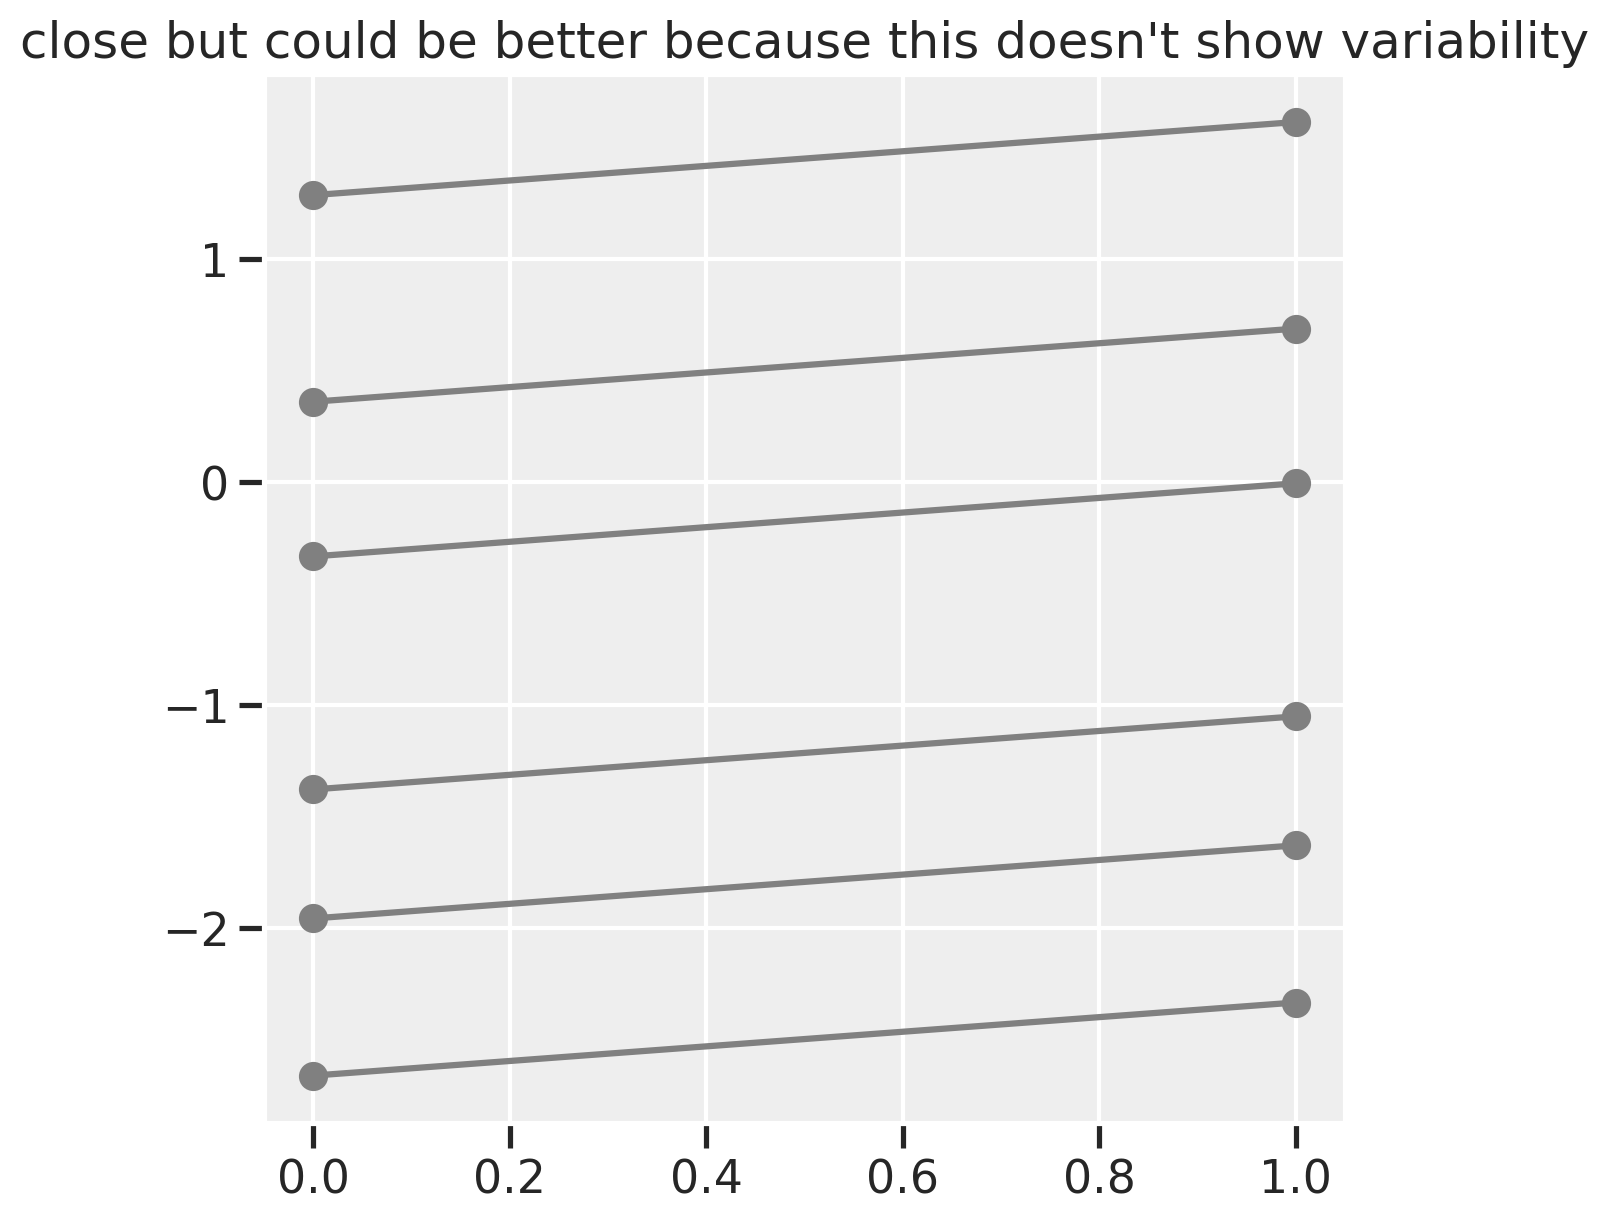

<IPython.core.display.Javascript object>

In [46]:
f, ax1 = plt.subplots(figsize=(6, 6))

for i in range(len(cumprob_I0)):
    ax1.scatter(0, cumprob_I0[i], color="gray")
    ax1.scatter(1, cumprob_I1[i], color="gray")
    ax1.plot([0, 1], [cumprob_I0[i], cumprob_I1[i]], color="gray")
    ax1.set_title("close but could be better because this doesn't show variability")

### Questions for the group/textbook

- No scaling term? link equivalent to sim and sample_posterior_predictive?
- kappa changed to alpha?

In [47]:
# posterior predictive

with m12_5:
    pm.set_data(
        {
            "A": cases_df.action.values,
            "C": cases_df.contact.values,
            "I": cases_df.intention.values,
        }
    )
    pp_phi = pm.sample_posterior_predictive(
        trace_12_5, var_names=["phi"], random_seed=RANDOM_SEED
    )["phi"]

NameError: name 'cases_df' is not defined

<IPython.core.display.Javascript object>

In [48]:
pp_resp["resp_obs"].shape

NameError: name 'pp_resp' is not defined

<IPython.core.display.Javascript object>

In [49]:
# Counterfactual cases:
cases_df = pd.DataFrame(
    np.array([[0, 0, 0], [0, 0, 1], [1, 0, 0], [1, 0, 1], [0, 1, 0], [0, 1, 1]]),
    columns=["action", "contact", "intention"],
)
cases_df

action  contact  intention
0       0        0          0
1       0        0          1
2       1        0          0
3       1        0          1
4       0        1          0
5       0        1          1

<IPython.core.display.Javascript object>

In [50]:
resp_df = pd.DataFrame(pp_resp["resp_obs"]).T
resp_df.index.name = "case"
resp_df = (
    pd.concat([cases_df, resp_df], axis=1)
    .set_index(["action", "contact", "intention"])
    .sort_index()
)
resp_df

NameError: name 'pp_resp' is not defined

<IPython.core.display.Javascript object>

NameError: name 'pp_resp' is not defined

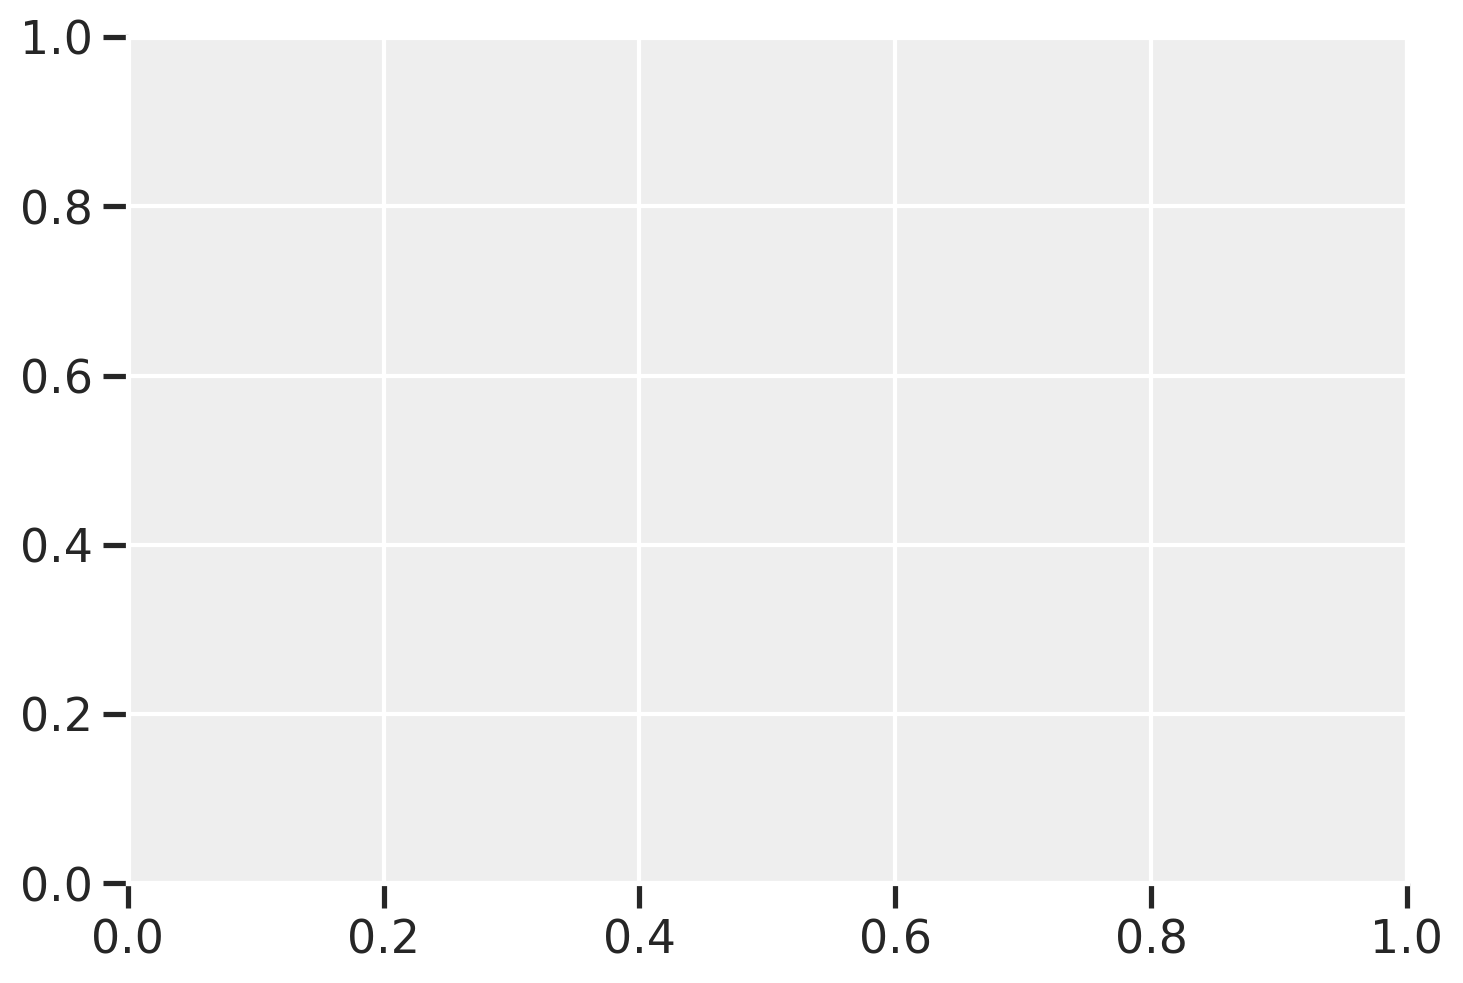

<IPython.core.display.Javascript object>

In [51]:
f, ax1 = plt.subplots()
ax1.hist(pp_resp["resp_obs"][:, 0])

In [52]:
def p_ord_logit(responses: range, phi: np.ndarray, a: np.ndarray):
    """
    For the given posterior sample, computes the cumulative probabilities
    of each response in each of the counterfactual values of the predictors.

    responses: range of possible responses in the experiment
    phi: posterior phi for each counterfactual case
    a: posterior intercept for each response
    """
    p = pd.DataFrame(index=range(len(cases_df)), columns=responses)
    for case in p.index:
        p.loc[case] = logistic(a - phi[case])

<IPython.core.display.Javascript object>

In [53]:
trace_12_5_df[cutpoints_col].mean()

(posterior, cutpoints[0], 0)   -2.635954
(posterior, cutpoints[1], 1)   -1.939398
(posterior, cutpoints[2], 2)   -1.344338
(posterior, cutpoints[3], 3)   -0.309179
(posterior, cutpoints[4], 4)    0.362014
(posterior, cutpoints[5], 5)    1.267736
dtype: float64

<IPython.core.display.Javascript object>

In [54]:
trace_12_5_df[cutpoints_col].std()

(posterior, cutpoints[0], 0)    0.052183
(posterior, cutpoints[1], 1)    0.047757
(posterior, cutpoints[2], 2)    0.045295
(posterior, cutpoints[3], 3)    0.043103
(posterior, cutpoints[4], 4)    0.043428
(posterior, cutpoints[5], 5)    0.046546
dtype: float64

<IPython.core.display.Javascript object>

#### Repo code

In [55]:
# Observed cum probs (from repo, great code)
p_obs = (
    df_trolley.groupby(["action", "contact", "intention"])
    .response.value_counts(normalize=True, sort=False)
    .unstack()
    .cumsum(axis=1)
    .iloc[:, :-1]
)
p_obs.columns = range(6)
p_obs

0         1         2         3         4  \
action contact intention                                                     
0      0       0          0.050755  0.112991  0.187915  0.443505  0.596375   
               1          0.070997  0.155589  0.251259  0.514602  0.652064   
       1       0          0.092649  0.150050  0.249748  0.497482  0.677744   
               1          0.336354  0.497482  0.645519  0.791541  0.880161   
1      0       0          0.100831  0.179003  0.285876  0.535876  0.709215   
               1          0.215106  0.344411  0.482175  0.677946  0.804834   

                                 5  
action contact intention            
0      0       0          0.779456  
               1          0.820242  
       1       0          0.856999  
               1          0.942598  
1      0       0          0.863293  
               1          0.901511

<IPython.core.display.Javascript object>

Remember, these are cumulative probabilities. We wouldn't expect them to sum to 1 but they should monotonically increase. Below is just plotting the first row. The last value is not shown but will be 1.

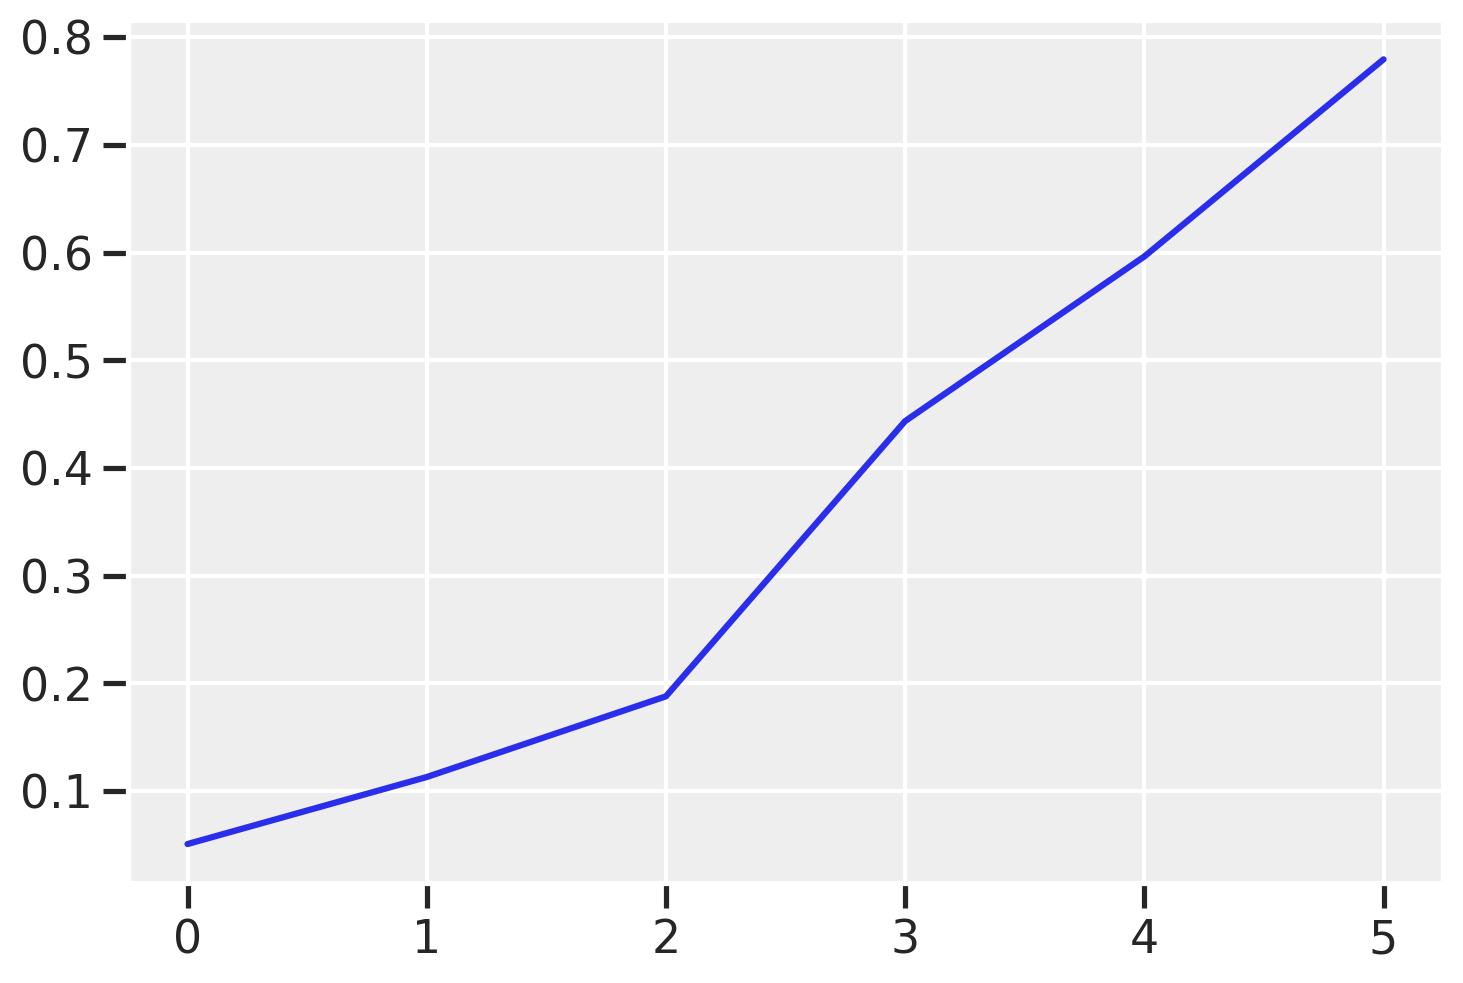

<IPython.core.display.Javascript object>

In [56]:
f, ax1 = plt.subplots()
ax1.plot(p_obs.iloc[0, :])

In [57]:
# Counterfactual cases:
cases_df = pd.DataFrame(
    np.array([[0, 0, 0], [0, 0, 1], [1, 0, 0], [1, 0, 1], [0, 1, 0], [0, 1, 1]]),
    columns=["action", "contact", "intention"],
)
cases_df

action  contact  intention
0       0        0          0
1       0        0          1
2       1        0          0
3       1        0          1
4       0        1          0
5       0        1          1

<IPython.core.display.Javascript object>

In [58]:
with m12_5:
    pm.set_data(
        {
            "A": cases_df.action.values,
            "C": cases_df.contact.values,
            "I": cases_df.intention.values,
        }
    )
    pp_phi = pm.sample_posterior_predictive(
        trace_12_5, var_names=["phi"], random_seed=RANDOM_SEED
    )["phi"]

<IPython.core.display.Javascript object>

In [59]:
pp_phi

array([[-0.        , -0.32781511, -0.50514052, -1.25842574, -0.31880184,
        -1.79663537],
       [-0.        , -0.30497069, -0.43482973, -1.16432285, -0.45798883,
        -1.86823832],
       [-0.        , -0.32604677, -0.45021825, -1.22297916, -0.37751014,
        -1.91681543],
       ...,
       [-0.        , -0.31649199, -0.51758153, -1.23487916, -0.31441999,
        -1.86091079],
       [-0.        , -0.24608546, -0.46204498, -1.16929504, -0.3795551 ,
        -1.85152211],
       [-0.        , -0.23015046, -0.46778073, -1.14086975, -0.29713445,
        -1.79953398]])

<IPython.core.display.Javascript object>

In [60]:
def p_ord_logit(responses: range, phi: np.ndarray, a: np.ndarray):
    """
    For the given posterior sample, computes the cumulative probabilities
    of each response in each of the counterfactual values of the predictors.

    responses: range of possible responses in the experiment
    phi: posterior phi for each counterfactual case
    a: posterior intercept for each response
    """
    p = pd.DataFrame(index=range(len(cases_df)), columns=responses)
    for case in p.index:
        p.loc[case] = logistic(a - phi[case])

    p = (
        pd.concat([cases_df, p], axis=1)
        .set_index(["action", "contact", "intention"])
        .sort_index()
    )
    p.index.name = "case"
    p.columns.name = "response"

    return p

<IPython.core.display.Javascript object>

In [61]:
[print(i) for i in trace_12_5_df.columns]

chain
draw
('posterior', 'bA')
('posterior', 'bC')
('posterior', 'bI')
('posterior', 'bIA')
('posterior', 'bIC')
('posterior', 'cutpoints[0]', 0)
('posterior', 'cutpoints[1]', 1)
('posterior', 'cutpoints[2]', 2)
('posterior', 'cutpoints[3]', 3)
('posterior', 'cutpoints[4]', 4)
('posterior', 'cutpoints[5]', 5)
('posterior', 'phi[0]', 0)
('posterior', 'phi[1000]', 1000)
('posterior', 'phi[1001]', 1001)
('posterior', 'phi[1002]', 1002)
('posterior', 'phi[1003]', 1003)
('posterior', 'phi[1004]', 1004)
('posterior', 'phi[1005]', 1005)
('posterior', 'phi[1006]', 1006)
('posterior', 'phi[1007]', 1007)
('posterior', 'phi[1008]', 1008)
('posterior', 'phi[1009]', 1009)
('posterior', 'phi[100]', 100)
('posterior', 'phi[1010]', 1010)
('posterior', 'phi[1011]', 1011)
('posterior', 'phi[1012]', 1012)
('posterior', 'phi[1013]', 1013)
('posterior', 'phi[1014]', 1014)
('posterior', 'phi[1015]', 1015)
('posterior', 'phi[1016]', 1016)
('posterior', 'phi[1017]', 1017)
('posterior', 'phi[1018]', 1018)
('po

('posterior', 'phi[2630]', 2630)
('posterior', 'phi[2631]', 2631)
('posterior', 'phi[2632]', 2632)
('posterior', 'phi[2633]', 2633)
('posterior', 'phi[2634]', 2634)
('posterior', 'phi[2635]', 2635)
('posterior', 'phi[2636]', 2636)
('posterior', 'phi[2637]', 2637)
('posterior', 'phi[2638]', 2638)
('posterior', 'phi[2639]', 2639)
('posterior', 'phi[263]', 263)
('posterior', 'phi[2640]', 2640)
('posterior', 'phi[2641]', 2641)
('posterior', 'phi[2642]', 2642)
('posterior', 'phi[2643]', 2643)
('posterior', 'phi[2644]', 2644)
('posterior', 'phi[2645]', 2645)
('posterior', 'phi[2646]', 2646)
('posterior', 'phi[2647]', 2647)
('posterior', 'phi[2648]', 2648)
('posterior', 'phi[2649]', 2649)
('posterior', 'phi[264]', 264)
('posterior', 'phi[2650]', 2650)
('posterior', 'phi[2651]', 2651)
('posterior', 'phi[2652]', 2652)
('posterior', 'phi[2653]', 2653)
('posterior', 'phi[2654]', 2654)
('posterior', 'phi[2655]', 2655)
('posterior', 'phi[2656]', 2656)
('posterior', 'phi[2657]', 2657)
('posterior', 

('posterior', 'phi[3981]', 3981)
('posterior', 'phi[3982]', 3982)
('posterior', 'phi[3983]', 3983)
('posterior', 'phi[3984]', 3984)
('posterior', 'phi[3985]', 3985)
('posterior', 'phi[3986]', 3986)
('posterior', 'phi[3987]', 3987)
('posterior', 'phi[3988]', 3988)
('posterior', 'phi[3989]', 3989)
('posterior', 'phi[398]', 398)
('posterior', 'phi[3990]', 3990)
('posterior', 'phi[3991]', 3991)
('posterior', 'phi[3992]', 3992)
('posterior', 'phi[3993]', 3993)
('posterior', 'phi[3994]', 3994)
('posterior', 'phi[3995]', 3995)
('posterior', 'phi[3996]', 3996)
('posterior', 'phi[3997]', 3997)
('posterior', 'phi[3998]', 3998)
('posterior', 'phi[3999]', 3999)
('posterior', 'phi[399]', 399)
('posterior', 'phi[39]', 39)
('posterior', 'phi[3]', 3)
('posterior', 'phi[4000]', 4000)
('posterior', 'phi[4001]', 4001)
('posterior', 'phi[4002]', 4002)
('posterior', 'phi[4003]', 4003)
('posterior', 'phi[4004]', 4004)
('posterior', 'phi[4005]', 4005)
('posterior', 'phi[4006]', 4006)
('posterior', 'phi[4007]

('posterior', 'phi[532]', 532)
('posterior', 'phi[5330]', 5330)
('posterior', 'phi[5331]', 5331)
('posterior', 'phi[5332]', 5332)
('posterior', 'phi[5333]', 5333)
('posterior', 'phi[5334]', 5334)
('posterior', 'phi[5335]', 5335)
('posterior', 'phi[5336]', 5336)
('posterior', 'phi[5337]', 5337)
('posterior', 'phi[5338]', 5338)
('posterior', 'phi[5339]', 5339)
('posterior', 'phi[533]', 533)
('posterior', 'phi[5340]', 5340)
('posterior', 'phi[5341]', 5341)
('posterior', 'phi[5342]', 5342)
('posterior', 'phi[5343]', 5343)
('posterior', 'phi[5344]', 5344)
('posterior', 'phi[5345]', 5345)
('posterior', 'phi[5346]', 5346)
('posterior', 'phi[5347]', 5347)
('posterior', 'phi[5348]', 5348)
('posterior', 'phi[5349]', 5349)
('posterior', 'phi[534]', 534)
('posterior', 'phi[5350]', 5350)
('posterior', 'phi[5351]', 5351)
('posterior', 'phi[5352]', 5352)
('posterior', 'phi[5353]', 5353)
('posterior', 'phi[5354]', 5354)
('posterior', 'phi[5355]', 5355)
('posterior', 'phi[5356]', 5356)
('posterior', 'p

('posterior', 'phi[6680]', 6680)
('posterior', 'phi[6681]', 6681)
('posterior', 'phi[6682]', 6682)
('posterior', 'phi[6683]', 6683)
('posterior', 'phi[6684]', 6684)
('posterior', 'phi[6685]', 6685)
('posterior', 'phi[6686]', 6686)
('posterior', 'phi[6687]', 6687)
('posterior', 'phi[6688]', 6688)
('posterior', 'phi[6689]', 6689)
('posterior', 'phi[668]', 668)
('posterior', 'phi[6690]', 6690)
('posterior', 'phi[6691]', 6691)
('posterior', 'phi[6692]', 6692)
('posterior', 'phi[6693]', 6693)
('posterior', 'phi[6694]', 6694)
('posterior', 'phi[6695]', 6695)
('posterior', 'phi[6696]', 6696)
('posterior', 'phi[6697]', 6697)
('posterior', 'phi[6698]', 6698)
('posterior', 'phi[6699]', 6699)
('posterior', 'phi[669]', 669)
('posterior', 'phi[66]', 66)
('posterior', 'phi[6700]', 6700)
('posterior', 'phi[6701]', 6701)
('posterior', 'phi[6702]', 6702)
('posterior', 'phi[6703]', 6703)
('posterior', 'phi[6704]', 6704)
('posterior', 'phi[6705]', 6705)
('posterior', 'phi[6706]', 6706)
('posterior', 'phi

('posterior', 'phi[8029]', 8029)
('posterior', 'phi[802]', 802)
('posterior', 'phi[8030]', 8030)
('posterior', 'phi[8031]', 8031)
('posterior', 'phi[8032]', 8032)
('posterior', 'phi[8033]', 8033)
('posterior', 'phi[8034]', 8034)
('posterior', 'phi[8035]', 8035)
('posterior', 'phi[8036]', 8036)
('posterior', 'phi[8037]', 8037)
('posterior', 'phi[8038]', 8038)
('posterior', 'phi[8039]', 8039)
('posterior', 'phi[803]', 803)
('posterior', 'phi[8040]', 8040)
('posterior', 'phi[8041]', 8041)
('posterior', 'phi[8042]', 8042)
('posterior', 'phi[8043]', 8043)
('posterior', 'phi[8044]', 8044)
('posterior', 'phi[8045]', 8045)
('posterior', 'phi[8046]', 8046)
('posterior', 'phi[8047]', 8047)
('posterior', 'phi[8048]', 8048)
('posterior', 'phi[8049]', 8049)
('posterior', 'phi[804]', 804)
('posterior', 'phi[8050]', 8050)
('posterior', 'phi[8051]', 8051)
('posterior', 'phi[8052]', 8052)
('posterior', 'phi[8053]', 8053)
('posterior', 'phi[8054]', 8054)
('posterior', 'phi[8055]', 8055)
('posterior', 'p

('posterior', 'phi[937]', 937)
('posterior', 'phi[9380]', 9380)
('posterior', 'phi[9381]', 9381)
('posterior', 'phi[9382]', 9382)
('posterior', 'phi[9383]', 9383)
('posterior', 'phi[9384]', 9384)
('posterior', 'phi[9385]', 9385)
('posterior', 'phi[9386]', 9386)
('posterior', 'phi[9387]', 9387)
('posterior', 'phi[9388]', 9388)
('posterior', 'phi[9389]', 9389)
('posterior', 'phi[938]', 938)
('posterior', 'phi[9390]', 9390)
('posterior', 'phi[9391]', 9391)
('posterior', 'phi[9392]', 9392)
('posterior', 'phi[9393]', 9393)
('posterior', 'phi[9394]', 9394)
('posterior', 'phi[9395]', 9395)
('posterior', 'phi[9396]', 9396)
('posterior', 'phi[9397]', 9397)
('posterior', 'phi[9398]', 9398)
('posterior', 'phi[9399]', 9399)
('posterior', 'phi[939]', 939)
('posterior', 'phi[93]', 93)
('posterior', 'phi[9400]', 9400)
('posterior', 'phi[9401]', 9401)
('posterior', 'phi[9402]', 9402)
('posterior', 'phi[9403]', 9403)
('posterior', 'phi[9404]', 9404)
('posterior', 'phi[9405]', 9405)
('posterior', 'phi[9

('log_likelihood', 'resp_obs[0,1791]', 0, 1791)
('log_likelihood', 'resp_obs[0,1792]', 0, 1792)
('log_likelihood', 'resp_obs[0,1793]', 0, 1793)
('log_likelihood', 'resp_obs[0,1794]', 0, 1794)
('log_likelihood', 'resp_obs[0,1795]', 0, 1795)
('log_likelihood', 'resp_obs[0,1796]', 0, 1796)
('log_likelihood', 'resp_obs[0,1797]', 0, 1797)
('log_likelihood', 'resp_obs[0,1798]', 0, 1798)
('log_likelihood', 'resp_obs[0,1799]', 0, 1799)
('log_likelihood', 'resp_obs[0,179]', 0, 179)
('log_likelihood', 'resp_obs[0,17]', 0, 17)
('log_likelihood', 'resp_obs[0,1800]', 0, 1800)
('log_likelihood', 'resp_obs[0,1801]', 0, 1801)
('log_likelihood', 'resp_obs[0,1802]', 0, 1802)
('log_likelihood', 'resp_obs[0,1803]', 0, 1803)
('log_likelihood', 'resp_obs[0,1804]', 0, 1804)
('log_likelihood', 'resp_obs[0,1805]', 0, 1805)
('log_likelihood', 'resp_obs[0,1806]', 0, 1806)
('log_likelihood', 'resp_obs[0,1807]', 0, 1807)
('log_likelihood', 'resp_obs[0,1808]', 0, 1808)
('log_likelihood', 'resp_obs[0,1809]', 0, 1809

('log_likelihood', 'resp_obs[0,3204]', 0, 3204)
('log_likelihood', 'resp_obs[0,3205]', 0, 3205)
('log_likelihood', 'resp_obs[0,3206]', 0, 3206)
('log_likelihood', 'resp_obs[0,3207]', 0, 3207)
('log_likelihood', 'resp_obs[0,3208]', 0, 3208)
('log_likelihood', 'resp_obs[0,3209]', 0, 3209)
('log_likelihood', 'resp_obs[0,320]', 0, 320)
('log_likelihood', 'resp_obs[0,3210]', 0, 3210)
('log_likelihood', 'resp_obs[0,3211]', 0, 3211)
('log_likelihood', 'resp_obs[0,3212]', 0, 3212)
('log_likelihood', 'resp_obs[0,3213]', 0, 3213)
('log_likelihood', 'resp_obs[0,3214]', 0, 3214)
('log_likelihood', 'resp_obs[0,3215]', 0, 3215)
('log_likelihood', 'resp_obs[0,3216]', 0, 3216)
('log_likelihood', 'resp_obs[0,3217]', 0, 3217)
('log_likelihood', 'resp_obs[0,3218]', 0, 3218)
('log_likelihood', 'resp_obs[0,3219]', 0, 3219)
('log_likelihood', 'resp_obs[0,321]', 0, 321)
('log_likelihood', 'resp_obs[0,3220]', 0, 3220)
('log_likelihood', 'resp_obs[0,3221]', 0, 3221)
('log_likelihood', 'resp_obs[0,3222]', 0, 32

('log_likelihood', 'resp_obs[0,4490]', 0, 4490)
('log_likelihood', 'resp_obs[0,4491]', 0, 4491)
('log_likelihood', 'resp_obs[0,4492]', 0, 4492)
('log_likelihood', 'resp_obs[0,4493]', 0, 4493)
('log_likelihood', 'resp_obs[0,4494]', 0, 4494)
('log_likelihood', 'resp_obs[0,4495]', 0, 4495)
('log_likelihood', 'resp_obs[0,4496]', 0, 4496)
('log_likelihood', 'resp_obs[0,4497]', 0, 4497)
('log_likelihood', 'resp_obs[0,4498]', 0, 4498)
('log_likelihood', 'resp_obs[0,4499]', 0, 4499)
('log_likelihood', 'resp_obs[0,449]', 0, 449)
('log_likelihood', 'resp_obs[0,44]', 0, 44)
('log_likelihood', 'resp_obs[0,4500]', 0, 4500)
('log_likelihood', 'resp_obs[0,4501]', 0, 4501)
('log_likelihood', 'resp_obs[0,4502]', 0, 4502)
('log_likelihood', 'resp_obs[0,4503]', 0, 4503)
('log_likelihood', 'resp_obs[0,4504]', 0, 4504)
('log_likelihood', 'resp_obs[0,4505]', 0, 4505)
('log_likelihood', 'resp_obs[0,4506]', 0, 4506)
('log_likelihood', 'resp_obs[0,4507]', 0, 4507)
('log_likelihood', 'resp_obs[0,4508]', 0, 4508

('log_likelihood', 'resp_obs[0,5840]', 0, 5840)
('log_likelihood', 'resp_obs[0,5841]', 0, 5841)
('log_likelihood', 'resp_obs[0,5842]', 0, 5842)
('log_likelihood', 'resp_obs[0,5843]', 0, 5843)
('log_likelihood', 'resp_obs[0,5844]', 0, 5844)
('log_likelihood', 'resp_obs[0,5845]', 0, 5845)
('log_likelihood', 'resp_obs[0,5846]', 0, 5846)
('log_likelihood', 'resp_obs[0,5847]', 0, 5847)
('log_likelihood', 'resp_obs[0,5848]', 0, 5848)
('log_likelihood', 'resp_obs[0,5849]', 0, 5849)
('log_likelihood', 'resp_obs[0,584]', 0, 584)
('log_likelihood', 'resp_obs[0,5850]', 0, 5850)
('log_likelihood', 'resp_obs[0,5851]', 0, 5851)
('log_likelihood', 'resp_obs[0,5852]', 0, 5852)
('log_likelihood', 'resp_obs[0,5853]', 0, 5853)
('log_likelihood', 'resp_obs[0,5854]', 0, 5854)
('log_likelihood', 'resp_obs[0,5855]', 0, 5855)
('log_likelihood', 'resp_obs[0,5856]', 0, 5856)
('log_likelihood', 'resp_obs[0,5857]', 0, 5857)
('log_likelihood', 'resp_obs[0,5858]', 0, 5858)
('log_likelihood', 'resp_obs[0,5859]', 0, 

('log_likelihood', 'resp_obs[0,718]', 0, 718)
('log_likelihood', 'resp_obs[0,7190]', 0, 7190)
('log_likelihood', 'resp_obs[0,7191]', 0, 7191)
('log_likelihood', 'resp_obs[0,7192]', 0, 7192)
('log_likelihood', 'resp_obs[0,7193]', 0, 7193)
('log_likelihood', 'resp_obs[0,7194]', 0, 7194)
('log_likelihood', 'resp_obs[0,7195]', 0, 7195)
('log_likelihood', 'resp_obs[0,7196]', 0, 7196)
('log_likelihood', 'resp_obs[0,7197]', 0, 7197)
('log_likelihood', 'resp_obs[0,7198]', 0, 7198)
('log_likelihood', 'resp_obs[0,7199]', 0, 7199)
('log_likelihood', 'resp_obs[0,719]', 0, 719)
('log_likelihood', 'resp_obs[0,71]', 0, 71)
('log_likelihood', 'resp_obs[0,7200]', 0, 7200)
('log_likelihood', 'resp_obs[0,7201]', 0, 7201)
('log_likelihood', 'resp_obs[0,7202]', 0, 7202)
('log_likelihood', 'resp_obs[0,7203]', 0, 7203)
('log_likelihood', 'resp_obs[0,7204]', 0, 7204)
('log_likelihood', 'resp_obs[0,7205]', 0, 7205)
('log_likelihood', 'resp_obs[0,7206]', 0, 7206)
('log_likelihood', 'resp_obs[0,7207]', 0, 7207)


('log_likelihood', 'resp_obs[0,853]', 0, 853)
('log_likelihood', 'resp_obs[0,8540]', 0, 8540)
('log_likelihood', 'resp_obs[0,8541]', 0, 8541)
('log_likelihood', 'resp_obs[0,8542]', 0, 8542)
('log_likelihood', 'resp_obs[0,8543]', 0, 8543)
('log_likelihood', 'resp_obs[0,8544]', 0, 8544)
('log_likelihood', 'resp_obs[0,8545]', 0, 8545)
('log_likelihood', 'resp_obs[0,8546]', 0, 8546)
('log_likelihood', 'resp_obs[0,8547]', 0, 8547)
('log_likelihood', 'resp_obs[0,8548]', 0, 8548)
('log_likelihood', 'resp_obs[0,8549]', 0, 8549)
('log_likelihood', 'resp_obs[0,854]', 0, 854)
('log_likelihood', 'resp_obs[0,8550]', 0, 8550)
('log_likelihood', 'resp_obs[0,8551]', 0, 8551)
('log_likelihood', 'resp_obs[0,8552]', 0, 8552)
('log_likelihood', 'resp_obs[0,8553]', 0, 8553)
('log_likelihood', 'resp_obs[0,8554]', 0, 8554)
('log_likelihood', 'resp_obs[0,8555]', 0, 8555)
('log_likelihood', 'resp_obs[0,8556]', 0, 8556)
('log_likelihood', 'resp_obs[0,8557]', 0, 8557)
('log_likelihood', 'resp_obs[0,8558]', 0, 85

('log_likelihood', 'resp_obs[0,988]', 0, 988)
('log_likelihood', 'resp_obs[0,9890]', 0, 9890)
('log_likelihood', 'resp_obs[0,9891]', 0, 9891)
('log_likelihood', 'resp_obs[0,9892]', 0, 9892)
('log_likelihood', 'resp_obs[0,9893]', 0, 9893)
('log_likelihood', 'resp_obs[0,9894]', 0, 9894)
('log_likelihood', 'resp_obs[0,9895]', 0, 9895)
('log_likelihood', 'resp_obs[0,9896]', 0, 9896)
('log_likelihood', 'resp_obs[0,9897]', 0, 9897)
('log_likelihood', 'resp_obs[0,9898]', 0, 9898)
('log_likelihood', 'resp_obs[0,9899]', 0, 9899)
('log_likelihood', 'resp_obs[0,989]', 0, 989)
('log_likelihood', 'resp_obs[0,98]', 0, 98)
('log_likelihood', 'resp_obs[0,9900]', 0, 9900)
('log_likelihood', 'resp_obs[0,9901]', 0, 9901)
('log_likelihood', 'resp_obs[0,9902]', 0, 9902)
('log_likelihood', 'resp_obs[0,9903]', 0, 9903)
('log_likelihood', 'resp_obs[0,9904]', 0, 9904)
('log_likelihood', 'resp_obs[0,9905]', 0, 9905)
('log_likelihood', 'resp_obs[0,9906]', 0, 9906)
('log_likelihood', 'resp_obs[0,9907]', 0, 9907)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

<IPython.core.display.Javascript object>

In [62]:
[print(i) for i in trace_12_5_df.columns]

chain
draw
('posterior', 'bA')
('posterior', 'bC')
('posterior', 'bI')
('posterior', 'bIA')
('posterior', 'bIC')
('posterior', 'cutpoints[0]', 0)
('posterior', 'cutpoints[1]', 1)
('posterior', 'cutpoints[2]', 2)
('posterior', 'cutpoints[3]', 3)
('posterior', 'cutpoints[4]', 4)
('posterior', 'cutpoints[5]', 5)
('posterior', 'phi[0]', 0)
('posterior', 'phi[1000]', 1000)
('posterior', 'phi[1001]', 1001)
('posterior', 'phi[1002]', 1002)
('posterior', 'phi[1003]', 1003)
('posterior', 'phi[1004]', 1004)
('posterior', 'phi[1005]', 1005)
('posterior', 'phi[1006]', 1006)
('posterior', 'phi[1007]', 1007)
('posterior', 'phi[1008]', 1008)
('posterior', 'phi[1009]', 1009)
('posterior', 'phi[100]', 100)
('posterior', 'phi[1010]', 1010)
('posterior', 'phi[1011]', 1011)
('posterior', 'phi[1012]', 1012)
('posterior', 'phi[1013]', 1013)
('posterior', 'phi[1014]', 1014)
('posterior', 'phi[1015]', 1015)
('posterior', 'phi[1016]', 1016)
('posterior', 'phi[1017]', 1017)
('posterior', 'phi[1018]', 1018)
('po

('posterior', 'phi[2709]', 2709)
('posterior', 'phi[270]', 270)
('posterior', 'phi[2710]', 2710)
('posterior', 'phi[2711]', 2711)
('posterior', 'phi[2712]', 2712)
('posterior', 'phi[2713]', 2713)
('posterior', 'phi[2714]', 2714)
('posterior', 'phi[2715]', 2715)
('posterior', 'phi[2716]', 2716)
('posterior', 'phi[2717]', 2717)
('posterior', 'phi[2718]', 2718)
('posterior', 'phi[2719]', 2719)
('posterior', 'phi[271]', 271)
('posterior', 'phi[2720]', 2720)
('posterior', 'phi[2721]', 2721)
('posterior', 'phi[2722]', 2722)
('posterior', 'phi[2723]', 2723)
('posterior', 'phi[2724]', 2724)
('posterior', 'phi[2725]', 2725)
('posterior', 'phi[2726]', 2726)
('posterior', 'phi[2727]', 2727)
('posterior', 'phi[2728]', 2728)
('posterior', 'phi[2729]', 2729)
('posterior', 'phi[272]', 272)
('posterior', 'phi[2730]', 2730)
('posterior', 'phi[2731]', 2731)
('posterior', 'phi[2732]', 2732)
('posterior', 'phi[2733]', 2733)
('posterior', 'phi[2734]', 2734)
('posterior', 'phi[2735]', 2735)
('posterior', 'p

('posterior', 'phi[4059]', 4059)
('posterior', 'phi[405]', 405)
('posterior', 'phi[4060]', 4060)
('posterior', 'phi[4061]', 4061)
('posterior', 'phi[4062]', 4062)
('posterior', 'phi[4063]', 4063)
('posterior', 'phi[4064]', 4064)
('posterior', 'phi[4065]', 4065)
('posterior', 'phi[4066]', 4066)
('posterior', 'phi[4067]', 4067)
('posterior', 'phi[4068]', 4068)
('posterior', 'phi[4069]', 4069)
('posterior', 'phi[406]', 406)
('posterior', 'phi[4070]', 4070)
('posterior', 'phi[4071]', 4071)
('posterior', 'phi[4072]', 4072)
('posterior', 'phi[4073]', 4073)
('posterior', 'phi[4074]', 4074)
('posterior', 'phi[4075]', 4075)
('posterior', 'phi[4076]', 4076)
('posterior', 'phi[4077]', 4077)
('posterior', 'phi[4078]', 4078)
('posterior', 'phi[4079]', 4079)
('posterior', 'phi[407]', 407)
('posterior', 'phi[4080]', 4080)
('posterior', 'phi[4081]', 4081)
('posterior', 'phi[4082]', 4082)
('posterior', 'phi[4083]', 4083)
('posterior', 'phi[4084]', 4084)
('posterior', 'phi[4085]', 4085)
('posterior', 'p

('posterior', 'phi[5408]', 5408)
('posterior', 'phi[5409]', 5409)
('posterior', 'phi[540]', 540)
('posterior', 'phi[5410]', 5410)
('posterior', 'phi[5411]', 5411)
('posterior', 'phi[5412]', 5412)
('posterior', 'phi[5413]', 5413)
('posterior', 'phi[5414]', 5414)
('posterior', 'phi[5415]', 5415)
('posterior', 'phi[5416]', 5416)
('posterior', 'phi[5417]', 5417)
('posterior', 'phi[5418]', 5418)
('posterior', 'phi[5419]', 5419)
('posterior', 'phi[541]', 541)
('posterior', 'phi[5420]', 5420)
('posterior', 'phi[5421]', 5421)
('posterior', 'phi[5422]', 5422)
('posterior', 'phi[5423]', 5423)
('posterior', 'phi[5424]', 5424)
('posterior', 'phi[5425]', 5425)
('posterior', 'phi[5426]', 5426)
('posterior', 'phi[5427]', 5427)
('posterior', 'phi[5428]', 5428)
('posterior', 'phi[5429]', 5429)
('posterior', 'phi[542]', 542)
('posterior', 'phi[5430]', 5430)
('posterior', 'phi[5431]', 5431)
('posterior', 'phi[5432]', 5432)
('posterior', 'phi[5433]', 5433)
('posterior', 'phi[5434]', 5434)
('posterior', 'p

('posterior', 'phi[6759]', 6759)
('posterior', 'phi[675]', 675)
('posterior', 'phi[6760]', 6760)
('posterior', 'phi[6761]', 6761)
('posterior', 'phi[6762]', 6762)
('posterior', 'phi[6763]', 6763)
('posterior', 'phi[6764]', 6764)
('posterior', 'phi[6765]', 6765)
('posterior', 'phi[6766]', 6766)
('posterior', 'phi[6767]', 6767)
('posterior', 'phi[6768]', 6768)
('posterior', 'phi[6769]', 6769)
('posterior', 'phi[676]', 676)
('posterior', 'phi[6770]', 6770)
('posterior', 'phi[6771]', 6771)
('posterior', 'phi[6772]', 6772)
('posterior', 'phi[6773]', 6773)
('posterior', 'phi[6774]', 6774)
('posterior', 'phi[6775]', 6775)
('posterior', 'phi[6776]', 6776)
('posterior', 'phi[6777]', 6777)
('posterior', 'phi[6778]', 6778)
('posterior', 'phi[6779]', 6779)
('posterior', 'phi[677]', 677)
('posterior', 'phi[6780]', 6780)
('posterior', 'phi[6781]', 6781)
('posterior', 'phi[6782]', 6782)
('posterior', 'phi[6783]', 6783)
('posterior', 'phi[6784]', 6784)
('posterior', 'phi[6785]', 6785)
('posterior', 'p

('posterior', 'phi[8107]', 8107)
('posterior', 'phi[8108]', 8108)
('posterior', 'phi[8109]', 8109)
('posterior', 'phi[810]', 810)
('posterior', 'phi[8110]', 8110)
('posterior', 'phi[8111]', 8111)
('posterior', 'phi[8112]', 8112)
('posterior', 'phi[8113]', 8113)
('posterior', 'phi[8114]', 8114)
('posterior', 'phi[8115]', 8115)
('posterior', 'phi[8116]', 8116)
('posterior', 'phi[8117]', 8117)
('posterior', 'phi[8118]', 8118)
('posterior', 'phi[8119]', 8119)
('posterior', 'phi[811]', 811)
('posterior', 'phi[8120]', 8120)
('posterior', 'phi[8121]', 8121)
('posterior', 'phi[8122]', 8122)
('posterior', 'phi[8123]', 8123)
('posterior', 'phi[8124]', 8124)
('posterior', 'phi[8125]', 8125)
('posterior', 'phi[8126]', 8126)
('posterior', 'phi[8127]', 8127)
('posterior', 'phi[8128]', 8128)
('posterior', 'phi[8129]', 8129)
('posterior', 'phi[812]', 812)
('posterior', 'phi[8130]', 8130)
('posterior', 'phi[8131]', 8131)
('posterior', 'phi[8132]', 8132)
('posterior', 'phi[8133]', 8133)
('posterior', 'p

('posterior', 'phi[9458]', 9458)
('posterior', 'phi[9459]', 9459)
('posterior', 'phi[945]', 945)
('posterior', 'phi[9460]', 9460)
('posterior', 'phi[9461]', 9461)
('posterior', 'phi[9462]', 9462)
('posterior', 'phi[9463]', 9463)
('posterior', 'phi[9464]', 9464)
('posterior', 'phi[9465]', 9465)
('posterior', 'phi[9466]', 9466)
('posterior', 'phi[9467]', 9467)
('posterior', 'phi[9468]', 9468)
('posterior', 'phi[9469]', 9469)
('posterior', 'phi[946]', 946)
('posterior', 'phi[9470]', 9470)
('posterior', 'phi[9471]', 9471)
('posterior', 'phi[9472]', 9472)
('posterior', 'phi[9473]', 9473)
('posterior', 'phi[9474]', 9474)
('posterior', 'phi[9475]', 9475)
('posterior', 'phi[9476]', 9476)
('posterior', 'phi[9477]', 9477)
('posterior', 'phi[9478]', 9478)
('posterior', 'phi[9479]', 9479)
('posterior', 'phi[947]', 947)
('posterior', 'phi[9480]', 9480)
('posterior', 'phi[9481]', 9481)
('posterior', 'phi[9482]', 9482)
('posterior', 'phi[9483]', 9483)
('posterior', 'phi[9484]', 9484)
('posterior', 'p

('log_likelihood', 'resp_obs[0,2164]', 0, 2164)
('log_likelihood', 'resp_obs[0,2165]', 0, 2165)
('log_likelihood', 'resp_obs[0,2166]', 0, 2166)
('log_likelihood', 'resp_obs[0,2167]', 0, 2167)
('log_likelihood', 'resp_obs[0,2168]', 0, 2168)
('log_likelihood', 'resp_obs[0,2169]', 0, 2169)
('log_likelihood', 'resp_obs[0,216]', 0, 216)
('log_likelihood', 'resp_obs[0,2170]', 0, 2170)
('log_likelihood', 'resp_obs[0,2171]', 0, 2171)
('log_likelihood', 'resp_obs[0,2172]', 0, 2172)
('log_likelihood', 'resp_obs[0,2173]', 0, 2173)
('log_likelihood', 'resp_obs[0,2174]', 0, 2174)
('log_likelihood', 'resp_obs[0,2175]', 0, 2175)
('log_likelihood', 'resp_obs[0,2176]', 0, 2176)
('log_likelihood', 'resp_obs[0,2177]', 0, 2177)
('log_likelihood', 'resp_obs[0,2178]', 0, 2178)
('log_likelihood', 'resp_obs[0,2179]', 0, 2179)
('log_likelihood', 'resp_obs[0,217]', 0, 217)
('log_likelihood', 'resp_obs[0,2180]', 0, 2180)
('log_likelihood', 'resp_obs[0,2181]', 0, 2181)
('log_likelihood', 'resp_obs[0,2182]', 0, 21

('log_likelihood', 'resp_obs[0,3261]', 0, 3261)
('log_likelihood', 'resp_obs[0,3262]', 0, 3262)
('log_likelihood', 'resp_obs[0,3263]', 0, 3263)
('log_likelihood', 'resp_obs[0,3264]', 0, 3264)
('log_likelihood', 'resp_obs[0,3265]', 0, 3265)
('log_likelihood', 'resp_obs[0,3266]', 0, 3266)
('log_likelihood', 'resp_obs[0,3267]', 0, 3267)
('log_likelihood', 'resp_obs[0,3268]', 0, 3268)
('log_likelihood', 'resp_obs[0,3269]', 0, 3269)
('log_likelihood', 'resp_obs[0,326]', 0, 326)
('log_likelihood', 'resp_obs[0,3270]', 0, 3270)
('log_likelihood', 'resp_obs[0,3271]', 0, 3271)
('log_likelihood', 'resp_obs[0,3272]', 0, 3272)
('log_likelihood', 'resp_obs[0,3273]', 0, 3273)
('log_likelihood', 'resp_obs[0,3274]', 0, 3274)
('log_likelihood', 'resp_obs[0,3275]', 0, 3275)
('log_likelihood', 'resp_obs[0,3276]', 0, 3276)
('log_likelihood', 'resp_obs[0,3277]', 0, 3277)
('log_likelihood', 'resp_obs[0,3278]', 0, 3278)
('log_likelihood', 'resp_obs[0,3279]', 0, 3279)
('log_likelihood', 'resp_obs[0,327]', 0, 3

('log_likelihood', 'resp_obs[0,4569]', 0, 4569)
('log_likelihood', 'resp_obs[0,456]', 0, 456)
('log_likelihood', 'resp_obs[0,4570]', 0, 4570)
('log_likelihood', 'resp_obs[0,4571]', 0, 4571)
('log_likelihood', 'resp_obs[0,4572]', 0, 4572)
('log_likelihood', 'resp_obs[0,4573]', 0, 4573)
('log_likelihood', 'resp_obs[0,4574]', 0, 4574)
('log_likelihood', 'resp_obs[0,4575]', 0, 4575)
('log_likelihood', 'resp_obs[0,4576]', 0, 4576)
('log_likelihood', 'resp_obs[0,4577]', 0, 4577)
('log_likelihood', 'resp_obs[0,4578]', 0, 4578)
('log_likelihood', 'resp_obs[0,4579]', 0, 4579)
('log_likelihood', 'resp_obs[0,457]', 0, 457)
('log_likelihood', 'resp_obs[0,4580]', 0, 4580)
('log_likelihood', 'resp_obs[0,4581]', 0, 4581)
('log_likelihood', 'resp_obs[0,4582]', 0, 4582)
('log_likelihood', 'resp_obs[0,4583]', 0, 4583)
('log_likelihood', 'resp_obs[0,4584]', 0, 4584)
('log_likelihood', 'resp_obs[0,4585]', 0, 4585)
('log_likelihood', 'resp_obs[0,4586]', 0, 4586)
('log_likelihood', 'resp_obs[0,4587]', 0, 45

('log_likelihood', 'resp_obs[0,5919]', 0, 5919)
('log_likelihood', 'resp_obs[0,591]', 0, 591)
('log_likelihood', 'resp_obs[0,5920]', 0, 5920)
('log_likelihood', 'resp_obs[0,5921]', 0, 5921)
('log_likelihood', 'resp_obs[0,5922]', 0, 5922)
('log_likelihood', 'resp_obs[0,5923]', 0, 5923)
('log_likelihood', 'resp_obs[0,5924]', 0, 5924)
('log_likelihood', 'resp_obs[0,5925]', 0, 5925)
('log_likelihood', 'resp_obs[0,5926]', 0, 5926)
('log_likelihood', 'resp_obs[0,5927]', 0, 5927)
('log_likelihood', 'resp_obs[0,5928]', 0, 5928)
('log_likelihood', 'resp_obs[0,5929]', 0, 5929)
('log_likelihood', 'resp_obs[0,592]', 0, 592)
('log_likelihood', 'resp_obs[0,5930]', 0, 5930)
('log_likelihood', 'resp_obs[0,5931]', 0, 5931)
('log_likelihood', 'resp_obs[0,5932]', 0, 5932)
('log_likelihood', 'resp_obs[0,5933]', 0, 5933)
('log_likelihood', 'resp_obs[0,5934]', 0, 5934)
('log_likelihood', 'resp_obs[0,5935]', 0, 5935)
('log_likelihood', 'resp_obs[0,5936]', 0, 5936)
('log_likelihood', 'resp_obs[0,5937]', 0, 59

('log_likelihood', 'resp_obs[0,7330]', 0, 7330)
('log_likelihood', 'resp_obs[0,7331]', 0, 7331)
('log_likelihood', 'resp_obs[0,7332]', 0, 7332)
('log_likelihood', 'resp_obs[0,7333]', 0, 7333)
('log_likelihood', 'resp_obs[0,7334]', 0, 7334)
('log_likelihood', 'resp_obs[0,7335]', 0, 7335)
('log_likelihood', 'resp_obs[0,7336]', 0, 7336)
('log_likelihood', 'resp_obs[0,7337]', 0, 7337)
('log_likelihood', 'resp_obs[0,7338]', 0, 7338)
('log_likelihood', 'resp_obs[0,7339]', 0, 7339)
('log_likelihood', 'resp_obs[0,733]', 0, 733)
('log_likelihood', 'resp_obs[0,7340]', 0, 7340)
('log_likelihood', 'resp_obs[0,7341]', 0, 7341)
('log_likelihood', 'resp_obs[0,7342]', 0, 7342)
('log_likelihood', 'resp_obs[0,7343]', 0, 7343)
('log_likelihood', 'resp_obs[0,7344]', 0, 7344)
('log_likelihood', 'resp_obs[0,7345]', 0, 7345)
('log_likelihood', 'resp_obs[0,7346]', 0, 7346)
('log_likelihood', 'resp_obs[0,7347]', 0, 7347)
('log_likelihood', 'resp_obs[0,7348]', 0, 7348)
('log_likelihood', 'resp_obs[0,7349]', 0, 

('log_likelihood', 'resp_obs[0,9060]', 0, 9060)
('log_likelihood', 'resp_obs[0,9061]', 0, 9061)
('log_likelihood', 'resp_obs[0,9062]', 0, 9062)
('log_likelihood', 'resp_obs[0,9063]', 0, 9063)
('log_likelihood', 'resp_obs[0,9064]', 0, 9064)
('log_likelihood', 'resp_obs[0,9065]', 0, 9065)
('log_likelihood', 'resp_obs[0,9066]', 0, 9066)
('log_likelihood', 'resp_obs[0,9067]', 0, 9067)
('log_likelihood', 'resp_obs[0,9068]', 0, 9068)
('log_likelihood', 'resp_obs[0,9069]', 0, 9069)
('log_likelihood', 'resp_obs[0,906]', 0, 906)
('log_likelihood', 'resp_obs[0,9070]', 0, 9070)
('log_likelihood', 'resp_obs[0,9071]', 0, 9071)
('log_likelihood', 'resp_obs[0,9072]', 0, 9072)
('log_likelihood', 'resp_obs[0,9073]', 0, 9073)
('log_likelihood', 'resp_obs[0,9074]', 0, 9074)
('log_likelihood', 'resp_obs[0,9075]', 0, 9075)
('log_likelihood', 'resp_obs[0,9076]', 0, 9076)
('log_likelihood', 'resp_obs[0,9077]', 0, 9077)
('log_likelihood', 'resp_obs[0,9078]', 0, 9078)
('log_likelihood', 'resp_obs[0,9079]', 0, 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

<IPython.core.display.Javascript object>

In [63]:
# Observed cum probs, taken from repo code
p_obs = (
    df_trolley.groupby(["action", "contact", "intention"])
    .response.value_counts(normalize=True, sort=False)
    .unstack()
    .cumsum(axis=1)
    .iloc[:, :-1]
)
p_obs.columns = range(6)
p_obs

0         1         2         3         4  \
action contact intention                                                     
0      0       0          0.050755  0.112991  0.187915  0.443505  0.596375   
               1          0.070997  0.155589  0.251259  0.514602  0.652064   
       1       0          0.092649  0.150050  0.249748  0.497482  0.677744   
               1          0.336354  0.497482  0.645519  0.791541  0.880161   
1      0       0          0.100831  0.179003  0.285876  0.535876  0.709215   
               1          0.215106  0.344411  0.482175  0.677946  0.804834   

                                 5  
action contact intention            
0      0       0          0.779456  
               1          0.820242  
       1       0          0.856999  
               1          0.942598  
1      0       0          0.863293  
               1          0.901511

<IPython.core.display.Javascript object>

KeyError: ('posterior', 'cutpoints[6]', 6)

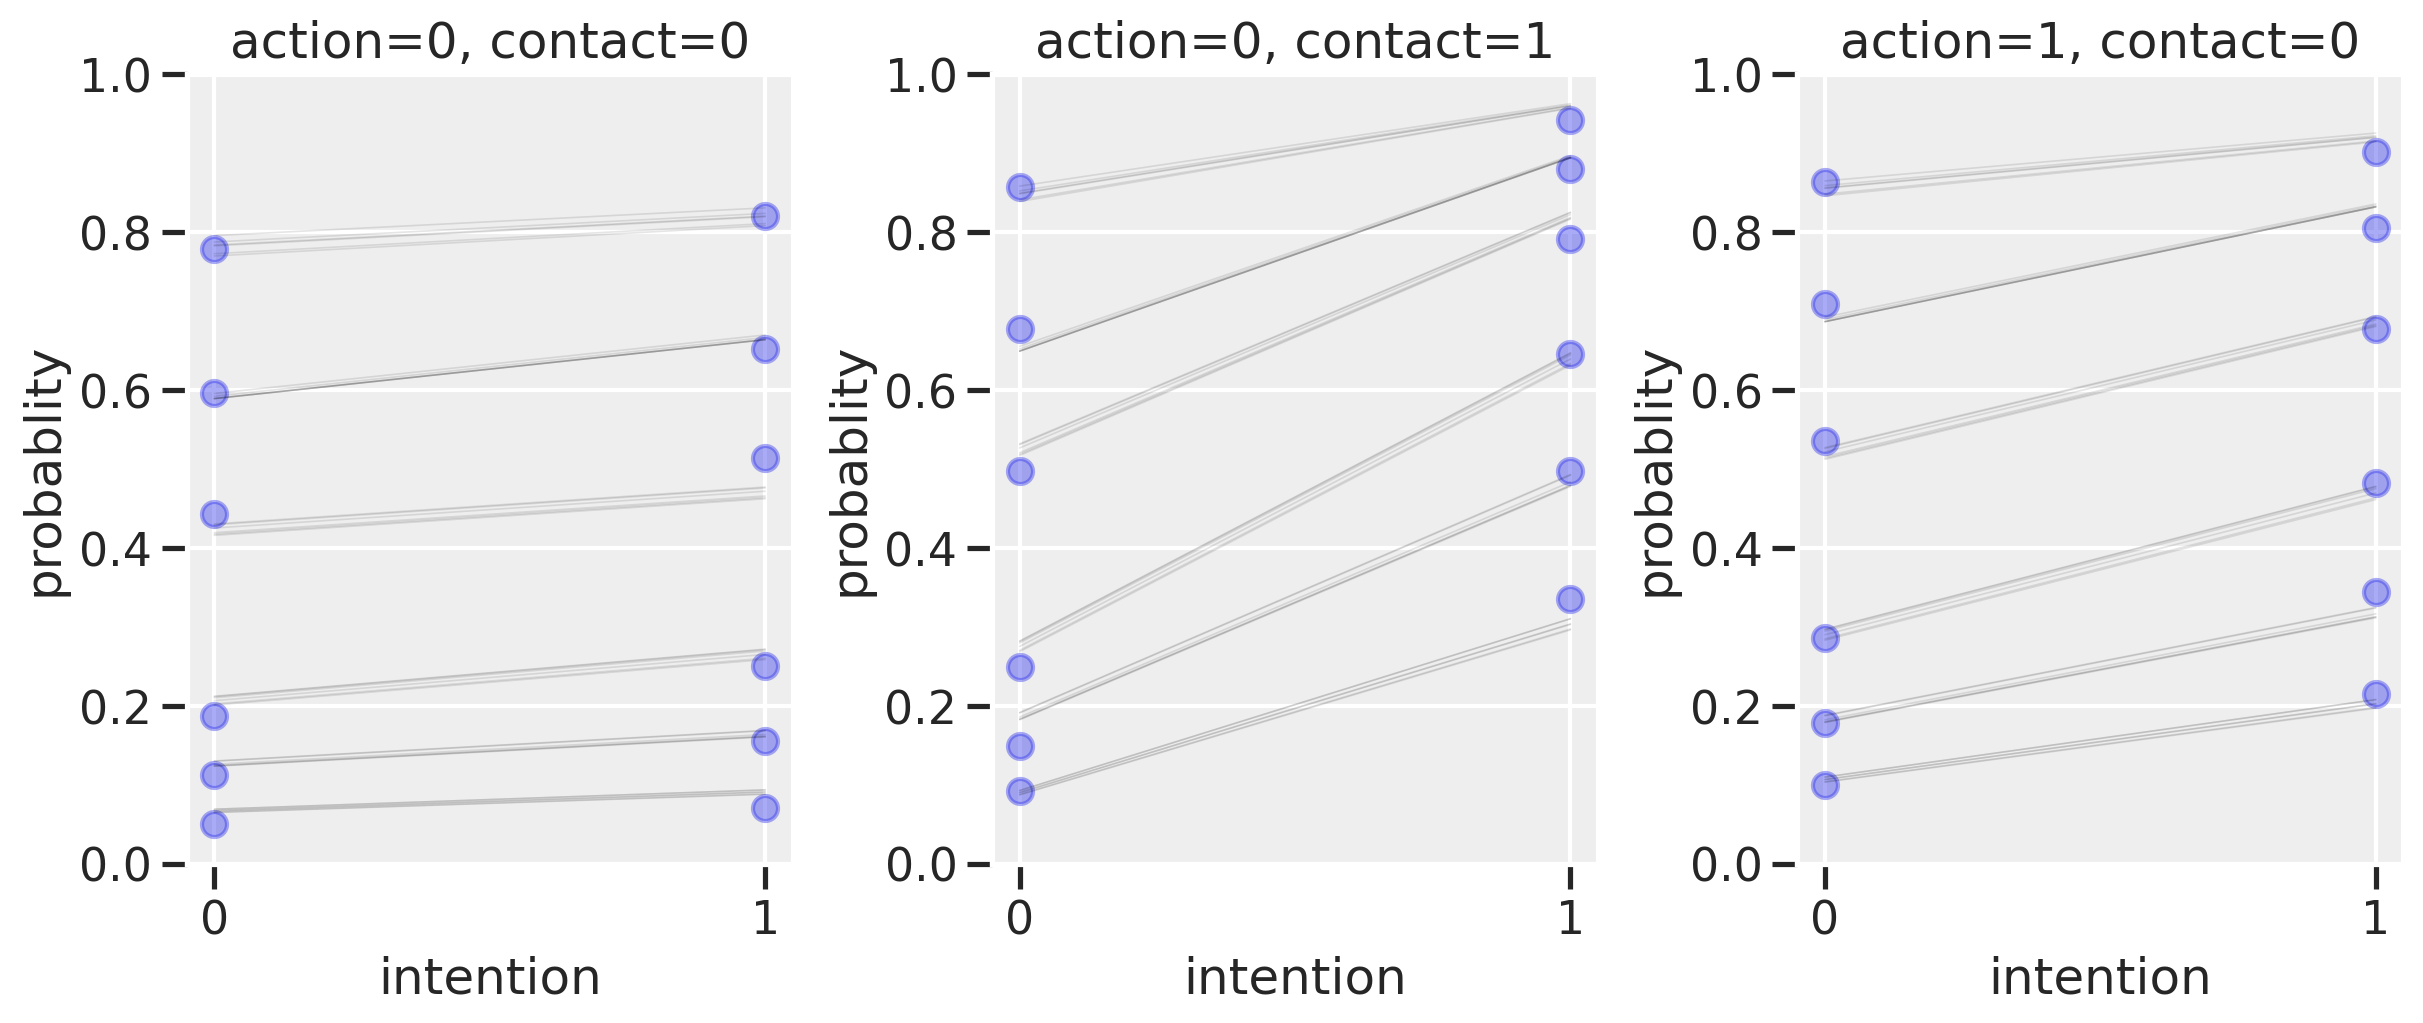

<IPython.core.display.Javascript object>

In [64]:
_, axes = plt.subplots(1, 3, figsize=(12, 5))

for s in range(50):
    # p = p_ord_logit(responses=range(6), phi=pp_phi[s], a=trace_12_5["cutpoints"][s])
    # altered code  [("posterior", "cutpoints" + str([s]), s)]
    p = p_ord_logit(
        responses=range(6),
        phi=pp_phi[s],
        a=trace_12_5_df[("posterior", "cutpoints" + str([s]), s)],
    )

    cur_ax = 0
    for (action, contact), _ in p.groupby(level=["action", "contact"]):
        axes[cur_ax].plot([0, 1], p.loc[action, contact], lw=0.6, c="k", alpha=0.1)

        if s == 0:
            axes[cur_ax].scatter(
                [[0] * 6 + [1] * 6], p_obs.loc[action, contact], alpha=0.4
            )  # alternate to next line
            # axes[cur_ax].plot([0, 1], p_obs.loc[action, contact], "ob", alpha=0.4)
            axes[cur_ax].set_xticks([0, 1])
            axes[cur_ax].set_xlabel("intention")
            axes[cur_ax].set_ylabel("probablity")
            axes[cur_ax].set_ylim([0, 1])
            axes[cur_ax].set_title(f"action={action}, contact={contact}")

        cur_ax += 1
plt.tight_layout()

## Back to the homework problem

### DAG

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


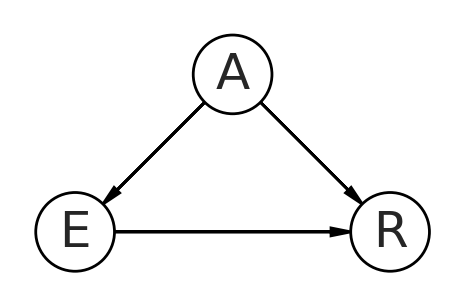

<IPython.core.display.Javascript object>

In [106]:
pipe_dag = CausalGraphicalModel(
    nodes=["E", "A", "R"],
    edges=[
        ("A", "E"),
        ("A", "R"),
        ("E", "R"),
    ],
)
pgm = daft.PGM()

coordinates = {
    "E": (0, 0),
    "A": (1, 1),
    "R": (2, 0),
}
for node in pipe_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in pipe_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()


The question asks about causality of education, given that there's an association with age. The DAG is similar to the age/marriage/divorce rate DAG except we have A entering E. If we accept this as a given, then we can build several models and ask, what is the additional value of knowing one variable, once I already know all the other predictor variables?

When reviewing page 128 and 129, that means that there are two paths for education. E > R is the *direct* path but a backdoor is created to E from R with A.

The E < A > R path is non-causal but still produces an association between E and R.

(Note that I had originally had one arrow wrong, E > A > R, which would be an indirect path. If this were the case, this could contribute to the total influence of E on R. If there is only an indirect path, then the relationship is known as **mediation**.)

The DAG also states that every pair of variables is associated (correlated) before conditioning.
(would write in mathjax)
- E is not independent of A
- E is not independent of R
- A is not independent of R

But R would be independent of E if we condition on A.

I can build three models:
1. Age only model. Is knowing age sufficient to predict the response?
2. Education only model. This would give us the *total* causal relationship of education (both direct and indirect, see page 128).
3. Both age and education.

We should be able to get our influence of education (the direct answer to the question) if we only build models 2 and 3. But let's build all 3 to get a clearer picture.

### Model with additional predictor variables

The model shown below is the third model that includes the age and education predictor variables, but they'll be included or omitted in pymc as needed.

$$R_i \text{ ~ } \text{Ordered-logit}(\phi_i,\kappa) \tag{probability of data}$$ 

$$\text{log} \frac{\text{Pr}(y_i \leq k)}{1-\text{Pr}(y_i \leq k)} = \alpha_k - \phi_i $$

$$\phi_i = \beta_{age}\text{Age} + \beta_E \displaystyle\sum\limits_{j=0}^{E_i - 1}\delta_j + \beta_AA_i + \beta_II_i + \beta_CC_i$$


Priors for the parameters

$$ \kappa_k \text{ ~ Normal}(0, 1.5)$$
$$ \beta_{age}, \beta_A, \beta_I, \beta_C, \beta_E \text{ ~ Normal}(0, 1) $$
$$ \delta \text{ ~ Dirichlet}(\alpha) $$

First we have to put the education and age variables with the right formatting.

In [11]:
df_trolley.head()

case  response  order      id  age  male            edu  action  \
0  cfaqu         4      2  96;434   14     0  Middle School       0   
1  cfbur         3     31  96;434   14     0  Middle School       0   
2  cfrub         4     16  96;434   14     0  Middle School       0   
3  cibox         3     32  96;434   14     0  Middle School       0   
4  cibur         3      4  96;434   14     0  Middle School       0   

   intention  contact story  action2  
0          0        1   aqu        1  
1          0        1   bur        1  
2          0        1   rub        1  
3          1        1   box        1  
4          1        1   bur        1

<IPython.core.display.Javascript object>

In [12]:
df_trolley["edu"].unique()

array(['Middle School', "Bachelor's Degree", 'Some College',
       "Master's Degree", 'High School Graduate', 'Graduate Degree',
       'Some High School', 'Elementary School'], dtype=object)

<IPython.core.display.Javascript object>

In [13]:
# ensure edu levels given a categorical index and put in the right order
ed_order = [
    "Elementary School",
    "Middle School",
    "Some High School",
    "High School Graduate",
    "Some College",
    "Bachelor's Degree",
    "Master's Degree",
    "Graduate Degree",
]

df_trolley["edu_cat"] = pd.Categorical(df_trolley["edu"], categories=ed_order).codes

<IPython.core.display.Javascript object>

In [14]:
# min-max normalize age

df_trolley["age_norm"] = (df_trolley["age"] - df_trolley["age"].min()) / (
    df_trolley["age"].max() - df_trolley["age"].min()
)

<IPython.core.display.Javascript object>

In [15]:
# verify values
# df_trolley[["age", "age_norm"]].drop_duplicates().sort_values(by="age")

<IPython.core.display.Javascript object>

Now let's put this in pymc.

In [82]:
df_trolley.head()

case  response  order      id  age  male            edu  action  \
0  cfaqu         4      2  96;434   14     0  Middle School       0   
1  cfbur         3     31  96;434   14     0  Middle School       0   
2  cfrub         4     16  96;434   14     0  Middle School       0   
3  cibox         3     32  96;434   14     0  Middle School       0   
4  cibur         3      4  96;434   14     0  Middle School       0   

   intention  contact story  action2  edu_cat  age_norm  
0          0        1   aqu        1        1  0.064516  
1          0        1   bur        1        1  0.064516  
2          0        1   rub        1        1  0.064516  
3          1        1   box        1        1  0.064516  
4          1        1   bur        1        1  0.064516

<IPython.core.display.Javascript object>

In [ ]:
import theano as tt

#### Model with both age and education

In [16]:
# Data variables, setup for easier coding
# age, E, a, c, i = age, education, action, contact, intent
age = df_trolley["age_norm"]
E = df_trolley["edu_cat"]
A = df_trolley["action"]
I = df_trolley["intention"]
C = df_trolley["contact"]

<IPython.core.display.Javascript object>

In [ ]:
# Tried to understand this block but it has to be within the model
# delta = pm.Dirichlet("delta", np.repeat(2.0, 7), shape=7)
# delta_j = tt.concatenate([tt.zeros(1), delta])
# delta_j_cumulative = tt.cumsum(delta_j)

In [87]:
with pm.Model() as m12h7c:

    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6) - 2.5,
    )

    # Priors
    k = pm.Normal("k", 0, 1.5)  # for ordered logit
    bAge = pm.Normal("bAge", 0, 1)
    bA = pm.Normal("bA", 0, 1)
    bC = pm.Normal("bC", 0, 1)
    bI = pm.Normal("bI", 0, 1)
    bE = pm.Normal("bE", 0, 1)

    # Note that book omitted the interaction term for education only example
    # so I'll do the same

    # bIA = pm.Normal("bIA", 0, 1)
    # bIC = pm.Normal("bI"C, 0, 1)

    # This defines the interaction of intention between action and contact
    # BI = bI + bIA * A + bIC * C

    # used repo code for dirichlet
    delta = pm.Dirichlet("delta", np.repeat(2.0, 7), shape=7)
    delta_j = tt.concatenate([tt.zeros(1), delta])
    delta_j_cumulative = tt.cumsum(delta_j)

    # Linear model (don't save parameter)
    phi = bAge * age + bE * delta_j_cumulative[E] + bA * A + bC * C + bI * I

    # Likelihood
    resp_obs = pm.OrderedLogistic(
        "resp_obs", phi, cutpoints, observed=df_trolley["response"] - 1  #
    )

    trace_m12h7 = pm.sample(
        draws=1000, return_inferencedata=True
    )  # Keep draws short for running

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, bE, bI, bC, bA, bAge, k, cutpoints]
INFO:pymc3:NUTS: [delta, bE, bI, bC, bA, bAge, k, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 214 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 214 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6613275994783075, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [88]:
az.summary(trace_m12h7)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
k            -0.029  1.479    -2.459      2.209      0.028    0.027    2729.0   
bAge         -0.419  0.095    -0.580     -0.277      0.003    0.002    1053.0   
bA           -0.708  0.041    -0.770     -0.642      0.001    0.001    2634.0   
bC           -0.961  0.051    -1.039     -0.880      0.001    0.001    2694.0   
bI           -0.720  0.037    -0.783     -0.663      0.001    0.001    2378.0   
bE            0.227  0.120     0.094      0.394      0.006    0.004     398.0   
cutpoints[0] -2.873  0.089    -2.999     -2.730      0.004    0.003     565.0   
cutpoints[1] -2.190  0.086    -2.313     -2.062      0.004    0.003     583.0   
cutpoints[2] -1.606  0.085    -1.721     -1.475      0.004    0.003     549.0   
cutpoints[3] -0.581  0.084    -0.696     -0.455      0.004    0.003     529.0   
cutpoints[4]  0.090  0.084    -0.027      0.215      0.004    0.003     522.0   
cutpoints[5]  0.997  0.085     0.878      1.125      0.004    0.003     534.0   
delta[0]      0.114  0.079     0.006      0.214      0.003    0.002     995.0   
delta[1]      0.122  0.077     0.007      0.226      0.002    0.001    2624.0   
delta[2]      0.087  0.061     0.003      0.165      0.002    0.001    1599.0   
delta[3]      0.067  0.053     0.004      0.129      0.002    0.001    1059.0   
delta[4]      0.432  0.147     0.216      0.669      0.006    0.004     601.0   
delta[5]      0.082  0.058     0.002      0.153      0.001    0.001    2023.0   
delta[6]      0.095  0.064     0.006      0.175      0.001    0.001    2742.0   

              ess_sd  ess_bulk  ess_tail  r_hat  
k             1545.0    2711.0    2380.0   1.00  
bAge          1053.0    1100.0     798.0   1.00  
bA            2634.0    2594.0    2578.0   1.00  
bC            2682.0    2683.0    2460.0   1.00  
bI            2357.0    2396.0    1957.0   1.00  
bE             398.0     675.0     351.0   1.01  
cutpoints[0]   555.0     694.0     496.0   1.01  
cutpoints[1]   566.0     724.0     531.0   1.01  
cutpoints[2]   530.0     698.0     453.0   1.01  
cutpoints[3]   478.0     690.0     438.0   1.01  
cutpoints[4]   380.0     689.0     420.0   1.01  
cutpoints[5]   534.0     680.0     455.0   1.01  
delta[0]       587.0    1505.0    1199.0   1.00  
delta[1]      2624.0    2297.0    1743.0   1.00  
delta[2]      1599.0    1451.0    1009.0   1.00  
delta[3]       980.0    1325.0    1320.0   1.00  
delta[4]       601.0     833.0     328.0   1.01  
delta[5]      2023.0    1308.0     925.0   1.00  
delta[6]      2426.0    2847.0    2057.0   1.00

<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

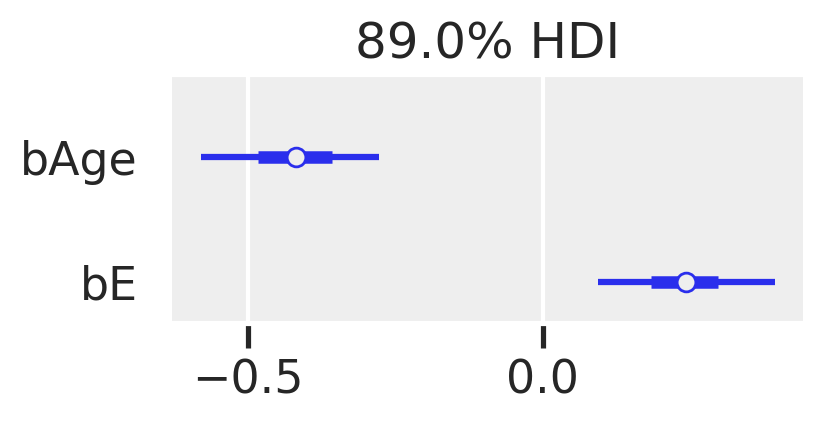

<IPython.core.display.Javascript object>

In [93]:
f, ax1 = plt.subplots(figsize=(4, 2))
az.plot_forest(trace_m12h7, var_names=["bAge", "bE"], combined=True, ax=ax1)

#### Model with education only (a repeat of what's in the book)

In [95]:
with pm.Model() as m12h7b:

    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6) - 2.5,
    )

    # Priors
    k = pm.Normal("k", 0, 1.5)  # for ordered logit
    bA = pm.Normal("bA", 0, 1)
    bC = pm.Normal("bC", 0, 1)
    bI = pm.Normal("bI", 0, 1)
    bE = pm.Normal("bE", 0, 1)

    # used repo code for dirichlet
    delta = pm.Dirichlet("delta", np.repeat(2.0, 7), shape=7)
    delta_j = tt.concatenate([tt.zeros(1), delta])
    delta_j_cumulative = tt.cumsum(delta_j)

    # Linear model (don't save parameter)
    phi = bE * delta_j_cumulative[E] + bA * A + bC * C + bI * I

    # Likelihood
    resp_obs = pm.OrderedLogistic(
        "resp_obs", phi, cutpoints, observed=df_trolley["response"] - 1  #
    )

    trace_m12h7b = pm.sample(
        draws=1000, return_inferencedata=True
    )  # Keep draws short for running

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, bE, bI, bC, bA, k, cutpoints]
INFO:pymc3:NUTS: [delta, bE, bI, bC, bA, k, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 301 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 301 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


<IPython.core.display.Javascript object>

In [97]:
az.summary(trace_m12h7b)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
k             0.024  1.451    -2.424      2.196      0.023    0.026    3960.0   
bA           -0.703  0.040    -0.765     -0.635      0.001    0.001    2842.0   
bC           -0.956  0.051    -1.032     -0.869      0.001    0.001    2680.0   
bI           -0.717  0.037    -0.772     -0.658      0.001    0.000    3470.0   
bE           -0.318  0.174    -0.574     -0.033      0.006    0.005     878.0   
cutpoints[0] -3.079  0.154    -3.308     -2.829      0.005    0.004     871.0   
cutpoints[1] -2.397  0.152    -2.616     -2.147      0.005    0.004     864.0   
cutpoints[2] -1.814  0.152    -2.037     -1.563      0.005    0.004     858.0   
cutpoints[3] -0.793  0.151    -1.038     -0.567      0.005    0.004     842.0   
cutpoints[4] -0.125  0.151    -0.370      0.102      0.005    0.005     849.0   
cutpoints[5]  0.782  0.151     0.524      0.996      0.005    0.004     875.0   
delta[0]      0.230  0.140     0.012      0.428      0.004    0.003    1353.0   
delta[1]      0.144  0.089     0.015      0.267      0.001    0.001    3755.0   
delta[2]      0.188  0.109     0.015      0.337      0.002    0.001    4299.0   
delta[3]      0.170  0.096     0.021      0.303      0.002    0.001    3303.0   
delta[4]      0.043  0.055     0.001      0.081      0.001    0.001    1660.0   
delta[5]      0.099  0.067     0.008      0.188      0.001    0.001    3270.0   
delta[6]      0.126  0.076     0.010      0.228      0.001    0.001    3949.0   

              ess_sd  ess_bulk  ess_tail  r_hat  
k             1557.0    3986.0    2731.0    1.0  
bA            2842.0    2843.0    2688.0    1.0  
bC            2680.0    2680.0    2111.0    1.0  
bI            3470.0    3468.0    2416.0    1.0  
bE             615.0    1035.0     579.0    1.0  
cutpoints[0]   834.0    1050.0     610.0    1.0  
cutpoints[1]   820.0    1034.0     628.0    1.0  
cutpoints[2]   801.0    1029.0     624.0    1.0  
cutpoints[3]   726.0    1025.0     618.0    1.0  
cutpoints[4]   548.0    1033.0     630.0    1.0  
cutpoints[5]   875.0    1047.0     669.0    1.0  
delta[0]      1108.0    1482.0    1076.0    1.0  
delta[1]      3653.0    3215.0    1694.0    1.0  
delta[2]      4299.0    3777.0    2442.0    1.0  
delta[3]      3303.0    2699.0    1765.0    1.0  
delta[4]      1660.0    1458.0    1160.0    1.0  
delta[5]      3270.0    2721.0    2100.0    1.0  
delta[6]      3508.0    3908.0    2770.0    1.0

<IPython.core.display.Javascript object>

My answers matched the book's exactly so that is satisfying.

#### Model with age only

In [100]:
with pm.Model() as m12h7a:

    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6) - 2.5,
    )

    # Priors
    k = pm.Normal("k", 0, 1.5)  # for ordered logit
    bAge = pm.Normal("bAge", 0, 1)
    bA = pm.Normal("bA", 0, 1)
    bC = pm.Normal("bC", 0, 1)
    bI = pm.Normal("bI", 0, 1)

    # used repo code for dirichlet
    delta = pm.Dirichlet("delta", np.repeat(2.0, 7), shape=7)
    delta_j = tt.concatenate([tt.zeros(1), delta])
    delta_j_cumulative = tt.cumsum(delta_j)

    # Linear model (don't save parameter)
    phi = bAge * age + bA * A + bC * C + bI * I

    # Likelihood
    resp_obs = pm.OrderedLogistic(
        "resp_obs", phi, cutpoints, observed=df_trolley["response"] - 1  #
    )

    trace_m12h7a = pm.sample(
        draws=1000, return_inferencedata=True
    )  # Keep draws short for running

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, bI, bC, bA, bAge, k, cutpoints]
INFO:pymc3:NUTS: [delta, bI, bC, bA, bAge, k, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 181 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 181 seconds.


<IPython.core.display.Javascript object>

In [103]:
az.summary(trace_m12h7a)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
k            -0.011  1.518    -2.418      2.337      0.019    0.030    6249.0   
bAge         -0.313  0.078    -0.438     -0.190      0.001    0.001    5104.0   
bA           -0.706  0.040    -0.770     -0.644      0.001    0.000    4639.0   
bC           -0.958  0.050    -1.042     -0.884      0.001    0.001    4681.0   
bI           -0.718  0.036    -0.778     -0.663      0.001    0.000    4465.0   
cutpoints[0] -2.972  0.058    -3.060     -2.877      0.001    0.001    3675.0   
cutpoints[1] -2.289  0.055    -2.379     -2.205      0.001    0.001    3965.0   
cutpoints[2] -1.705  0.052    -1.794     -1.628      0.001    0.001    3852.0   
cutpoints[3] -0.683  0.050    -0.766     -0.608      0.001    0.001    4266.0   
cutpoints[4] -0.014  0.049    -0.095      0.062      0.001    0.001    4392.0   
cutpoints[5]  0.892  0.052     0.808      0.975      0.001    0.001    4377.0   
delta[0]      0.143  0.090     0.004      0.263      0.001    0.001    5665.0   
delta[1]      0.143  0.090     0.009      0.265      0.001    0.001    5406.0   
delta[2]      0.142  0.090     0.013      0.269      0.001    0.001    6642.0   
delta[3]      0.141  0.092     0.010      0.267      0.001    0.001    6165.0   
delta[4]      0.145  0.091     0.007      0.269      0.001    0.001    5656.0   
delta[5]      0.143  0.091     0.007      0.265      0.001    0.001    5319.0   
delta[6]      0.143  0.093     0.009      0.269      0.001    0.001    4255.0   

              ess_sd  ess_bulk  ess_tail  r_hat  
k             1305.0    6204.0    2815.0    1.0  
bAge          5102.0    5108.0    2466.0    1.0  
bA            4529.0    4620.0    3043.0    1.0  
bC            4655.0    4674.0    2761.0    1.0  
bI            4446.0    4458.0    2841.0    1.0  
cutpoints[0]  3675.0    3674.0    2961.0    1.0  
cutpoints[1]  3965.0    3962.0    2874.0    1.0  
cutpoints[2]  3852.0    3868.0    2726.0    1.0  
cutpoints[3]  4266.0    4252.0    3003.0    1.0  
cutpoints[4]  2276.0    4389.0    2985.0    1.0  
cutpoints[5]  4340.0    4378.0    3142.0    1.0  
delta[0]      4743.0    5045.0    2328.0    1.0  
delta[1]      4524.0    4717.0    2511.0    1.0  
delta[2]      5714.0    5293.0    2443.0    1.0  
delta[3]      5353.0    4969.0    2561.0    1.0  
delta[4]      4550.0    4860.0    2552.0    1.0  
delta[5]      4631.0    4701.0    2855.0    1.0  
delta[6]      3942.0    4103.0    2439.0    1.0

<IPython.core.display.Javascript object>

### Comparison of all models to understand the effect of education

Text(0.5, 1.0, 'age only')

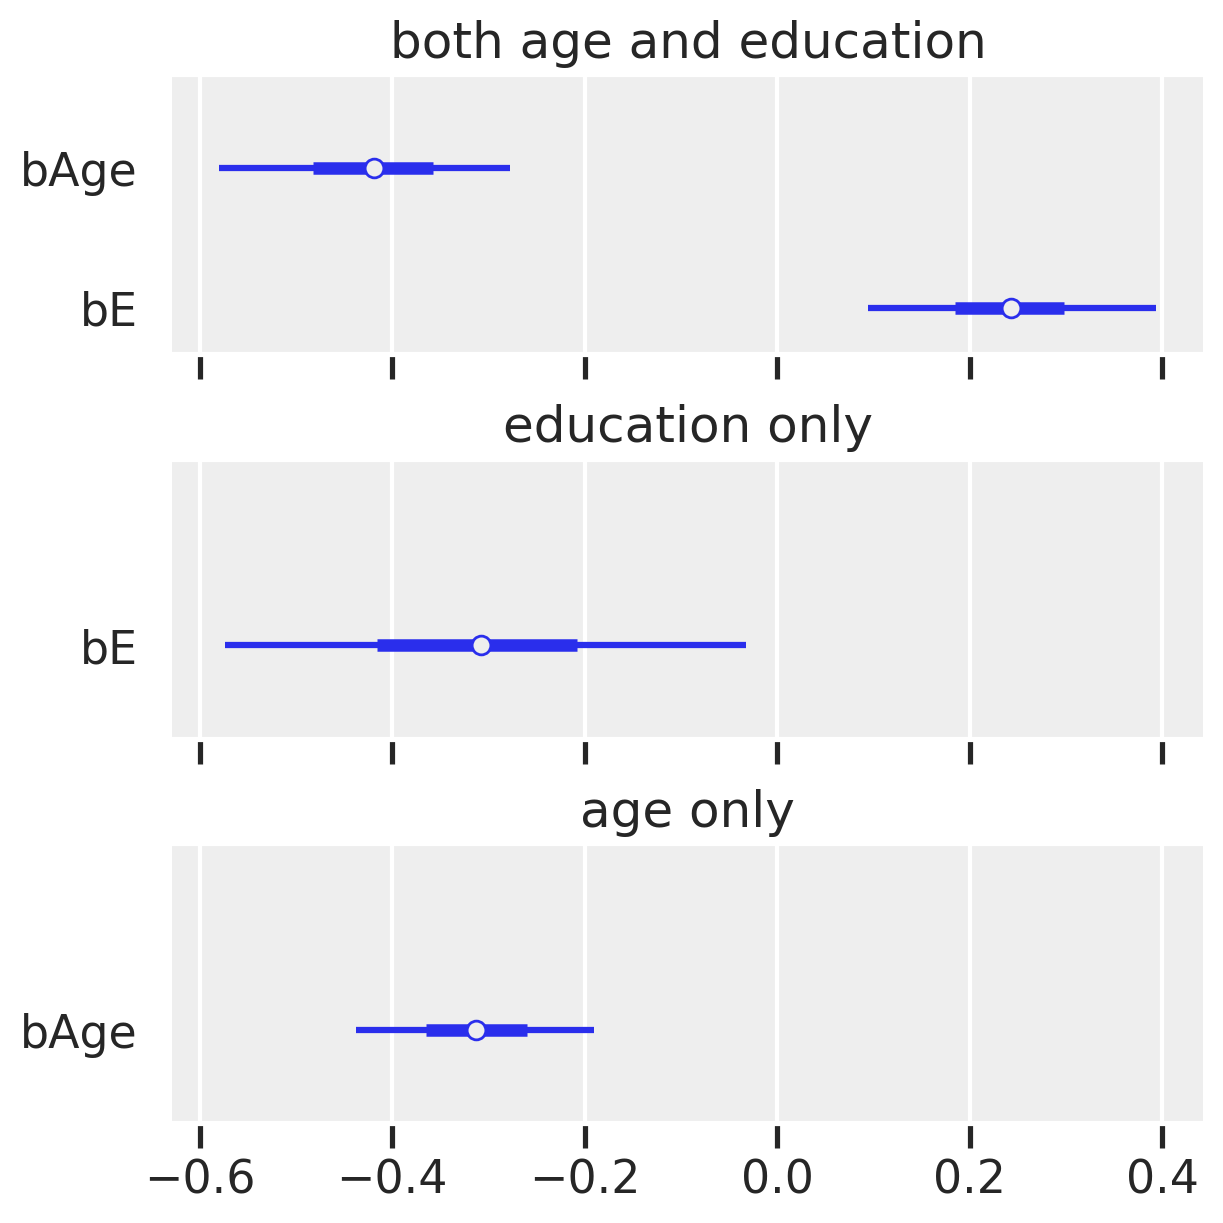

<IPython.core.display.Javascript object>

In [102]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
az.plot_forest(trace_m12h7, var_names=["bAge", "bE"], combined=True, ax=ax1)
ax1.set_title("both age and education")

az.plot_forest(trace_m12h7b, var_names=["bE"], combined=True, ax=ax2)
ax2.set_title("education only")

az.plot_forest(trace_m12h7a, var_names=["bAge"], combined=True, ax=ax3)
ax3.set_title("age only")

The education coefficient shifts remarkably when conditioning on age. This means that education would cause the probability mass to shift towards a higher rating for moral permissibility of pulling the lever while age would od the opposite. This is an example of Simpson's paradox.

How to interpret E when that's the only predictor in the regression and there's a backdoor into it?

# Question 2 (12H8)

Consider one more variable in the Trolley data: Gender. Suppose that gender might influence education as well as response directly. Draw the DAG now that includes response, education, age, and gender.

Using only the DAG, is it possible that the inferences from Problem 1 are confounded by gender? If so, define any additional models you need to infer the causal influence of education on response. What do you conclude?

Per Rojan, we're supposed to update the model now that we don't have a causal path from E to R? However, McElreath's solution uses the DAG I created.

## New DAG

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


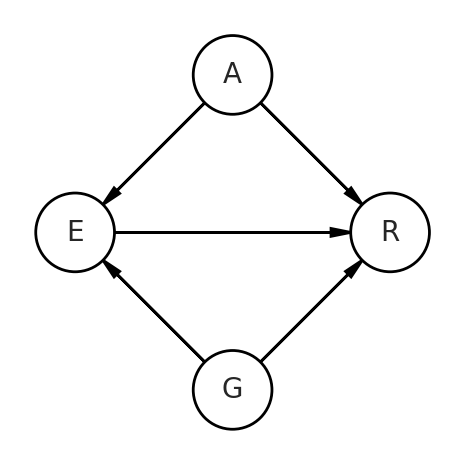

<IPython.core.display.Javascript object>

In [17]:
pipe_dag = CausalGraphicalModel(
    nodes=["E", "G", "A", "R"],
    edges=[
        ("A", "E"),
        ("A", "R"),
        ("E", "R"),
        ("G", "R"),
        ("G", "E"),
    ],
)
pgm = daft.PGM()

coordinates = {
    "E": (0, 0),
    "A": (1, 1),
    "R": (2, 0),
    "G": (1, -1),
}
for node in pipe_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in pipe_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()


In terms of the paths of E to R, we now have to consider the following:

- E > R (direct)
- E < A > R (A acts as a fork, creating a backdoor to E from R)
- E < G > R (G acts as a fork, creating a backdoor to E from R)

We now have two non-causal paths but that can still produce an association between E and R.

Therefore, we need to close both backdoors by conditioning on A and G. This creates a collider on R but I think it doesn't matter?

In [18]:
df_trolley.head()

case  response  order      id  age  male            edu  action  \
0  cfaqu         4      2  96;434   14     0  Middle School       0   
1  cfbur         3     31  96;434   14     0  Middle School       0   
2  cfrub         4     16  96;434   14     0  Middle School       0   
3  cibox         3     32  96;434   14     0  Middle School       0   
4  cibur         3      4  96;434   14     0  Middle School       0   

   intention  contact story  action2  edu_cat  age_norm  
0          0        1   aqu        1        1  0.064516  
1          0        1   bur        1        1  0.064516  
2          0        1   rub        1        1  0.064516  
3          1        1   box        1        1  0.064516  
4          1        1   bur        1        1  0.064516

<IPython.core.display.Javascript object>

In [19]:
G = df_trolley["male"]

with pm.Model() as m12h8:

    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6) - 2.5,
    )

    # Priors
    k = pm.Normal("k", 0, 1.5)  # for ordered logit
    bG = pm.Normal("bG", 0, 1)  # new variable for gender
    bAge = pm.Normal("bAge", 0, 1)
    bA = pm.Normal("bA", 0, 1)
    bC = pm.Normal("bC", 0, 1)
    bI = pm.Normal("bI", 0, 1)
    bE = pm.Normal("bE", 0, 1)

    # used repo code for dirichlet
    delta = pm.Dirichlet("delta", np.repeat(2.0, 7), shape=7)
    delta_j = tt.concatenate([tt.zeros(1), delta])
    delta_j_cumulative = tt.cumsum(delta_j)

    # Linear model (don't save parameter)
    phi = bG * G + bAge * age + bE * delta_j_cumulative[E] + bA * A + bC * C + bI * I

    # Likelihood
    resp_obs = pm.OrderedLogistic(
        "resp_obs", phi, cutpoints, observed=df_trolley["response"] - 1  #
    )

    trace_m12h8 = pm.sample(
        draws=1000, return_inferencedata=True
    )  # Keep draws short for running

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, bE, bI, bC, bA, bAge, bG, k, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 314 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


<IPython.core.display.Javascript object>

NameError: name 'trace_m12h7' is not defined

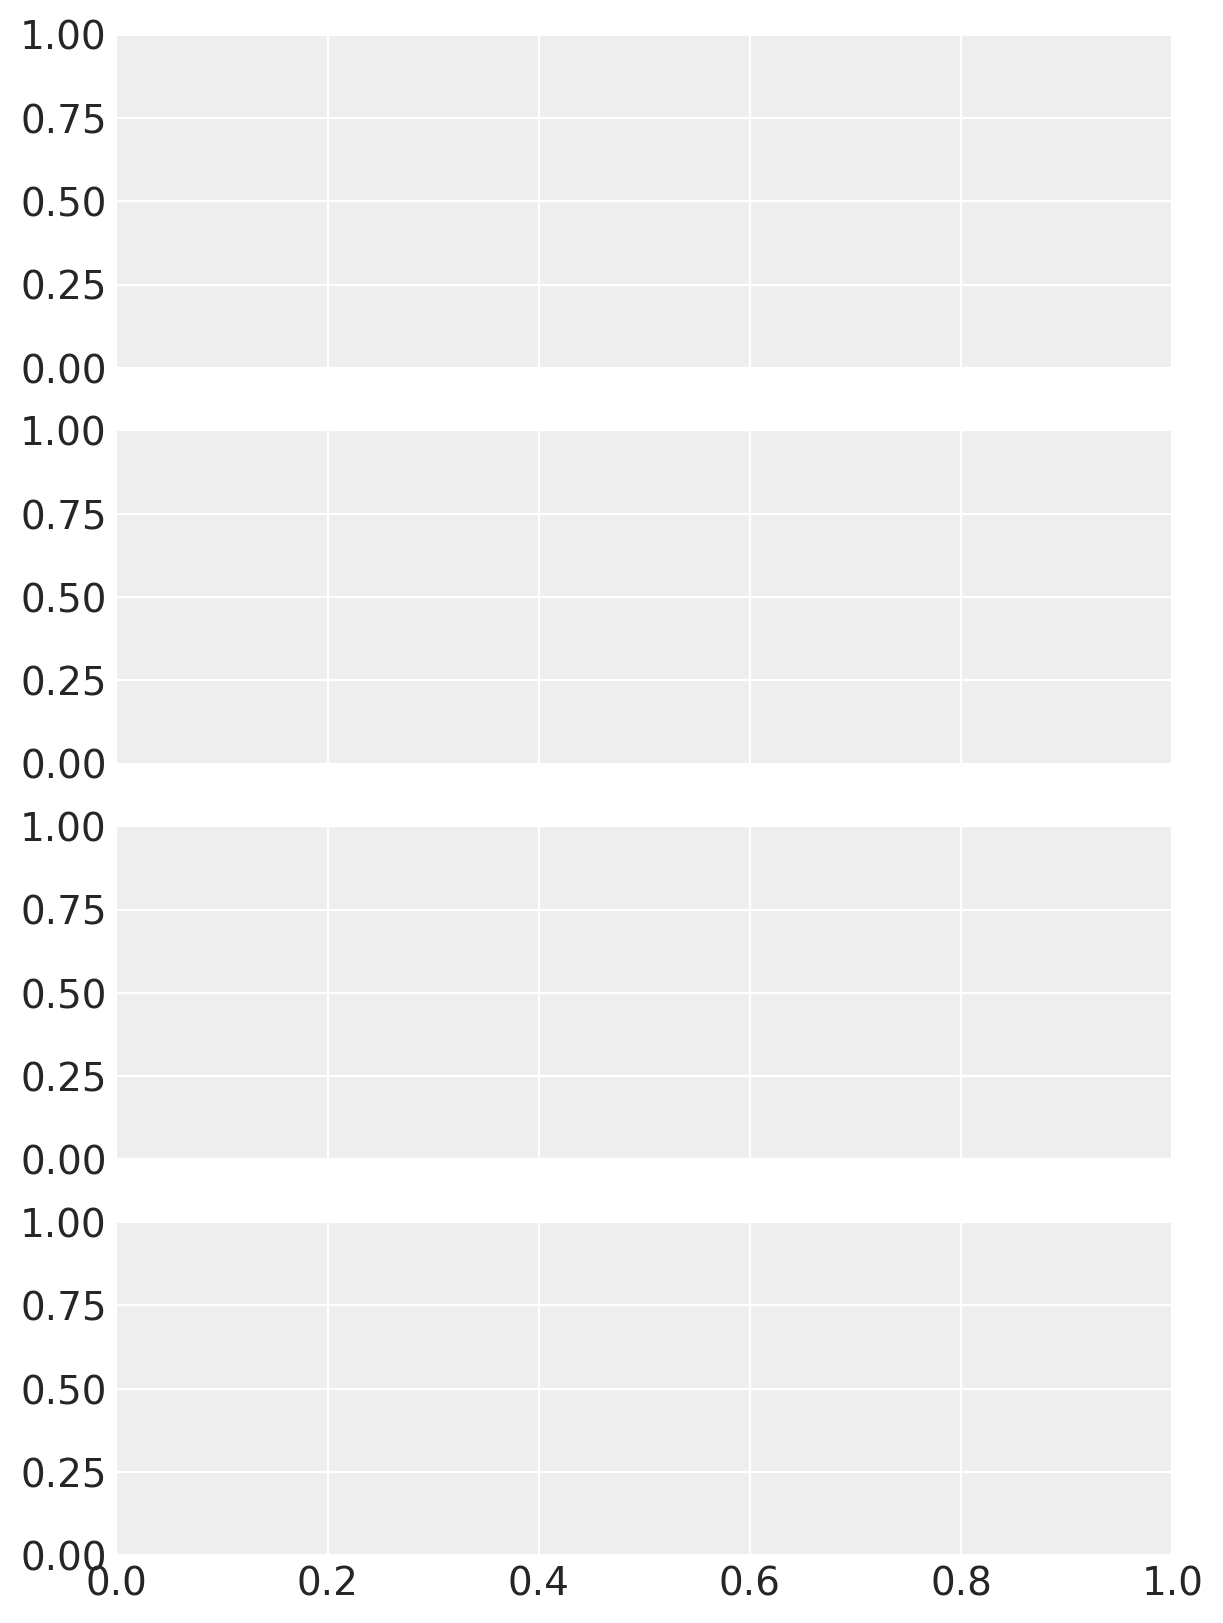

<IPython.core.display.Javascript object>

In [20]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(6, 8), sharex=True)
az.plot_forest(trace_m12h7, var_names=["bAge", "bE"], combined=True, ax=ax1)
ax1.set_title("both age and education")

az.plot_forest(trace_m12h7b, var_names=["bE"], combined=True, ax=ax2)
ax2.set_title("education only")

az.plot_forest(trace_m12h7a, var_names=["bAge"], combined=True, ax=ax3)
ax3.set_title("age only")

az.plot_forest(trace_m12h8, var_names=["bAge", "bE", "bG"], combined=True, ax=ax4)
ax4.set_title("age, education, gender")

We now see the effect of education being neutral. The causal effect of gender is driving this more. (Females are more educated which then promote higher responses.)

In [113]:
az.summary(trace_m12h8)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
k            -0.001  1.488    -2.277      2.470      0.019    0.026    6166.0   
bG            0.562  0.036     0.505      0.620      0.001    0.000    5152.0   
bAge         -0.284  0.099    -0.442     -0.125      0.002    0.001    2409.0   
bA           -0.713  0.040    -0.775     -0.646      0.001    0.000    4211.0   
bC           -0.970  0.051    -1.050     -0.890      0.001    0.001    4852.0   
bI           -0.726  0.036    -0.782     -0.669      0.001    0.000    4674.0   
bE            0.008  0.175    -0.258      0.277      0.005    0.003    1329.0   
cutpoints[0] -2.688  0.113    -2.857     -2.504      0.003    0.002    1474.0   
cutpoints[1] -2.004  0.112    -2.162     -1.811      0.003    0.002    1471.0   
cutpoints[2] -1.415  0.111    -1.584     -1.237      0.003    0.002    1468.0   
cutpoints[3] -0.371  0.111    -0.545     -0.198      0.003    0.002    1462.0   
cutpoints[4]  0.316  0.111     0.138      0.488      0.003    0.002    1453.0   
cutpoints[5]  1.242  0.112     1.065      1.418      0.003    0.002    1507.0   
delta[0]      0.150  0.099     0.007      0.276      0.002    0.001    3763.0   
delta[1]      0.143  0.087     0.007      0.259      0.001    0.001    4204.0   
delta[2]      0.133  0.087     0.010      0.249      0.001    0.001    4390.0   
delta[3]      0.134  0.097     0.004      0.264      0.002    0.001    2841.0   
delta[4]      0.193  0.154     0.004      0.417      0.004    0.003    1639.0   
delta[5]      0.119  0.081     0.009      0.229      0.001    0.001    3960.0   
delta[6]      0.128  0.080     0.007      0.233      0.001    0.001    3795.0   

              ess_sd  ess_bulk  ess_tail  r_hat  
k             1605.0    6176.0    2741.0    1.0  
bG            5068.0    5157.0    2280.0    1.0  
bAge          2399.0    2416.0    2446.0    1.0  
bA            4076.0    4238.0    3040.0    1.0  
bC            4765.0    4850.0    3154.0    1.0  
bI            4674.0    4706.0    2879.0    1.0  
bE            1329.0    1360.0    1780.0    1.0  
cutpoints[0]  1459.0    1526.0    1598.0    1.0  
cutpoints[1]  1452.0    1524.0    1704.0    1.0  
cutpoints[2]  1442.0    1520.0    1710.0    1.0  
cutpoints[3]  1386.0    1509.0    1638.0    1.0  
cutpoints[4]  1453.0    1489.0    1744.0    1.0  
cutpoints[5]  1507.0    1541.0    1712.0    1.0  
delta[0]      3213.0    3728.0    2312.0    1.0  
delta[1]      3561.0    4056.0    2712.0    1.0  
delta[2]      4027.0    3971.0    2483.0    1.0  
delta[3]      2841.0    2563.0    3121.0    1.0  
delta[4]      1639.0    1605.0    2410.0    1.0  
delta[5]      3960.0    3468.0    2542.0    1.0  
delta[6]      3712.0    3448.0    2753.0    1.0

<IPython.core.display.Javascript object>

## Model with interaction term

My answers don't match numerically when checking the solutions, but he also puts the interaction variable back in??

In [114]:
with pm.Model() as m12h8i:

    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6) - 2.5,
    )

    # Priors
    k = pm.Normal("k", 0, 1.5)  # for ordered logit
    bG = pm.Normal("bG", 0, 1)  # new variable for gender
    bAge = pm.Normal("bAge", 0, 1)
    bA = pm.Normal("bA", 0, 1)
    bC = pm.Normal("bC", 0, 1)
    bI = pm.Normal("bI", 0, 1)
    bE = pm.Normal("bE", 0, 1)

    # Put interaction term back in
    bIA = pm.Normal("bIA", 0, 1)
    bIC = pm.Normal("bIC", 0, 1)

    # This defines the interaction of intention between action and contact
    BI = bI + bIA * A + bIC * C

    # used repo code for dirichlet
    delta = pm.Dirichlet("delta", np.repeat(2.0, 7), shape=7)
    delta_j = tt.concatenate([tt.zeros(1), delta])
    delta_j_cumulative = tt.cumsum(delta_j)

    # Linear model (don't save parameter)
    phi = bG * G + bAge * age + bE * delta_j_cumulative[E] + bA * A + bC * C + BI * I

    # Likelihood
    resp_obs = pm.OrderedLogistic(
        "resp_obs", phi, cutpoints, observed=df_trolley["response"] - 1  #
    )

    trace_m12h8i = pm.sample(
        draws=1000, return_inferencedata=True
    )  # Keep draws short for running

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, bIC, bIA, bE, bI, bC, bA, bAge, bG, k, cutpoints]
INFO:pymc3:NUTS: [delta, bIC, bIA, bE, bI, bC, bA, bAge, bG, k, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 298 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 298 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 15 divergences after tuning. Increase `target_accept` or reparameterize.


<IPython.core.display.Javascript object>

In [115]:
az.summary(trace_m12h8i)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
k            -0.004  1.509    -2.406      2.443      0.021    0.032    4934.0   
bG            0.568  0.037     0.512      0.629      0.001    0.000    5032.0   
bAge         -0.293  0.095    -0.443     -0.140      0.002    0.001    2143.0   
bA           -0.477  0.053    -0.558     -0.394      0.001    0.001    2747.0   
bC           -0.335  0.068    -0.441     -0.226      0.001    0.001    2744.0   
bI           -0.286  0.057    -0.375     -0.196      0.001    0.001    2554.0   
bE           -0.008  0.177    -0.266      0.272      0.005    0.004    1130.0   
bIA          -0.451  0.078    -0.575     -0.325      0.002    0.001    2663.0   
bIC          -1.293  0.097    -1.456     -1.148      0.002    0.001    3010.0   
cutpoints[0] -2.500  0.118    -2.689     -2.321      0.003    0.002    1315.0   
cutpoints[1] -1.802  0.117    -1.981     -1.618      0.003    0.002    1257.0   
cutpoints[2] -1.199  0.116    -1.386     -1.027      0.003    0.002    1251.0   
cutpoints[3] -0.140  0.115    -0.324      0.030      0.003    0.003    1263.0   
cutpoints[4]  0.551  0.116     0.366      0.725      0.003    0.002    1281.0   
cutpoints[5]  1.477  0.117     1.298      1.656      0.003    0.002    1272.0   
delta[0]      0.154  0.105     0.006      0.294      0.002    0.002    2726.0   
delta[1]      0.142  0.090     0.007      0.261      0.001    0.001    5572.0   
delta[2]      0.135  0.090     0.010      0.257      0.001    0.001    4156.0   
delta[3]      0.140  0.103     0.010      0.281      0.002    0.002    2314.0   
delta[4]      0.179  0.152     0.002      0.403      0.004    0.003    1410.0   
delta[5]      0.120  0.080     0.007      0.227      0.001    0.001    3606.0   
delta[6]      0.130  0.084     0.006      0.237      0.001    0.001    3683.0   

              ess_sd  ess_bulk  ess_tail  r_hat  
k             1148.0    4967.0    2108.0    1.0  
bG            5032.0    5045.0    2341.0    1.0  
bAge          2141.0    2156.0    2653.0    1.0  
bA            2713.0    2752.0    3135.0    1.0  
bC            2676.0    2752.0    2565.0    1.0  
bI            2437.0    2556.0    2602.0    1.0  
bE            1130.0    1202.0    1374.0    1.0  
bIA           2663.0    2659.0    3015.0    1.0  
bIC           3010.0    3000.0    2847.0    1.0  
cutpoints[0]  1282.0    1404.0    1141.0    1.0  
cutpoints[1]  1215.0    1359.0    1198.0    1.0  
cutpoints[2]  1188.0    1350.0    1142.0    1.0  
cutpoints[3]  1056.0    1342.0    1239.0    1.0  
cutpoints[4]  1281.0    1354.0    1251.0    1.0  
cutpoints[5]  1272.0    1348.0    1220.0    1.0  
delta[0]      2247.0    2867.0    2068.0    1.0  
delta[1]      4695.0    4800.0    2276.0    1.0  
delta[2]      3789.0    3776.0    2713.0    1.0  
delta[3]      2314.0    2134.0    2640.0    1.0  
delta[4]      1410.0    1435.0    2401.0    1.0  
delta[5]      3606.0    3137.0    2219.0    1.0  
delta[6]      3226.0    3504.0    2421.0    1.0

<IPython.core.display.Javascript object>

Get largely the same answers ... the sign for gender is flipped relative to the solutions and I did min-max normalization while he did standardization.

Text(0.5, 1.0, 'both age and education (full DAG)')

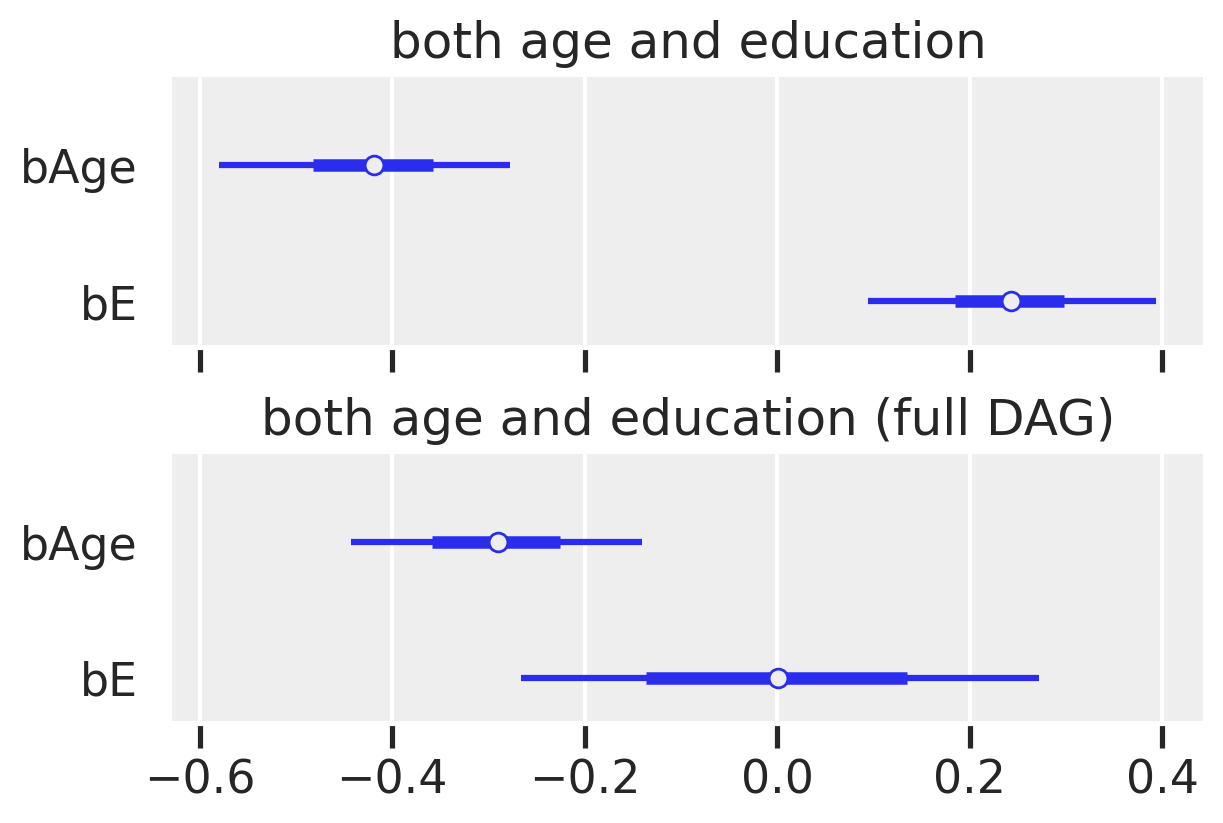

<IPython.core.display.Javascript object>

In [119]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
az.plot_forest(trace_m12h7, var_names=["bAge", "bE"], combined=True, ax=ax1)
ax1.set_title("both age and education")

az.plot_forest(trace_m12h8i, var_names=["bAge", "bE"], combined=True, ax=ax2)
ax2.set_title("both age and education (full DAG)")

Appendix: Environment and system parameters

## Perform data generation to understand this example

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


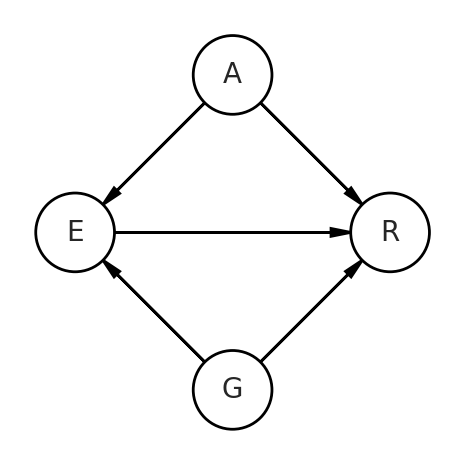

<IPython.core.display.Javascript object>

In [4]:
pipe_dag = CausalGraphicalModel(
    nodes=["E", "G", "A", "R"],
    edges=[
        ("A", "E"),
        ("A", "R"),
        ("E", "R"),
        ("G", "R"),
        ("G", "E"),
    ],
)
pgm = daft.PGM()

coordinates = {
    "E": (0, 0),
    "A": (1, 1),
    "R": (2, 0),
    "G": (1, -1),
}
for node in pipe_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in pipe_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()


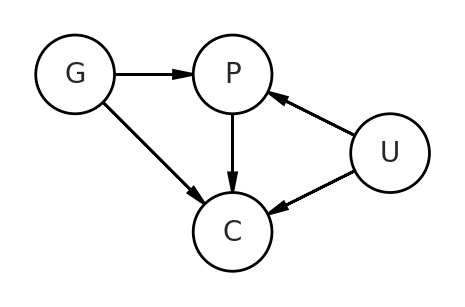

<IPython.core.display.Javascript object>

In [5]:
pipe_dag = CausalGraphicalModel(
    nodes=["G", "P", "C", "U"],
    edges=[
        ("G", "P"),
        ("P", "C"),
        ("G", "C"),
        ("U", "P"),
        ("U", "C")

    ],
)
pgm = daft.PGM()

coordinates = {
    "G": (0, 0),
    "P": (1, 0),
    "C": (1, -1),
    "U": (2, -0.5)
}
for node in pipe_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in pipe_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()


- G > P < U > C

(P is a collider, but U is a pipe?)


The DAG is conceptually similar to the grandparents example. We can simulate data in a similar way.

Analogy:

```
A : G
E : P
R : C
G : U
```

In [10]:
n = 200  # number of GPC triads
b_AE = 1  # direct effect of A on E
b_AR = 0  # direct effect of A on R
b_ER = 1  # direct effect of E on R

# McElreath uses one variable that acts on both
b_G = 2  # direct effect of G on E and R

<IPython.core.display.Javascript object>

While conceptually similar, we have the ability to include the variable G (gender) since it was measured. Gender was analogous to U in the gradnparents dataset and we pretended it was unmeasured.

Including E opens a path due to collider bias but then G closes it again?

Another thing we have to do is generate responses on the ordinal scale.

In [13]:
# Gender is not affected by anything
G = stats.bernoulli.rvs(p=0.5, size=n)
G

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1])

<IPython.core.display.Javascript object>

In [14]:
# Age is not affected by anything
age = stats.norm.rvs(0, 1, size=n)
age

array([-0.20918982,  0.84300346,  0.66821666, -0.33530615,  0.1523844 ,
        0.71059791,  0.03133886, -1.04607445,  0.72289795,  1.1678368 ,
       -1.14267046, -1.55868701, -0.10027343, -1.33070879, -1.01948904,
        0.33273364,  0.1770538 ,  0.39775831, -0.71175857, -0.87654552,
       -0.52419251,  0.06735348,  1.33539357, -0.56200612,  0.89214747,
        1.06277962,  0.46800799, -0.28018728,  0.63345156, -0.5188362 ,
       -0.86989981, -0.27941176, -1.10980457, -0.34126826,  0.56980572,
       -0.18706715,  0.14922154,  1.1664456 , -1.0065215 , -0.47832437,
       -0.8546717 ,  0.56875439,  2.07760639, -0.49103508, -0.81076467,
       -2.19718221,  0.42010934, -0.18241449, -1.93985124, -0.17710801,
       -0.32310951,  0.84032169,  1.2748794 , -0.64246429,  0.77441186,
        1.09719728, -0.64199742,  0.59718132,  0.78361567, -0.44165554,
        0.41458987,  0.52966436,  1.24054876, -0.34047771,  1.03740732,
       -0.81536616,  0.33617861,  0.55285962, -1.26148914, -0.59

<IPython.core.display.Javascript object>

In [16]:
# Education is a function of gender and age
E = stats.norm.rvs(b_G*G + b_AE*age)
E

array([ 1.45996433e+00,  3.27242532e+00,  3.79035489e+00,  2.20149250e+00,
        1.68218028e+00,  1.67139948e+00,  1.95131999e+00, -8.99879482e-02,
        4.80425924e+00,  1.91178648e+00, -1.48898895e+00,  5.94946704e-01,
        1.60365981e+00,  4.07067649e-03, -2.52336955e+00,  1.83030260e+00,
        1.94607697e+00,  1.29809072e+00, -1.81763809e-01,  1.36008586e+00,
        1.90639950e-01,  1.20386073e+00,  2.85115693e+00,  5.98676639e-01,
        2.62558602e+00,  4.03037325e+00,  4.50795927e+00, -3.17494453e-01,
        1.00215153e+00, -1.65278646e-01,  4.20657859e-01,  2.36111378e+00,
       -2.34815033e+00, -1.96218778e+00,  7.96516492e-01, -1.02401025e+00,
       -1.79822768e-02,  1.94959075e+00, -2.77061349e-01,  1.11200795e+00,
        9.24330204e-01,  2.43706319e+00,  4.02947015e+00,  4.22750266e-01,
        1.98456973e+00, -1.38057945e+00,  4.18794101e+00,  2.70102203e+00,
       -3.66077952e+00,  1.05771006e+00,  2.53397054e+00,  8.81812153e-01,
        2.04576455e+00,  

<IPython.core.display.Javascript object>

In [17]:
# Response is a function of everything
R = stats.norm.rvs(b_G*G + b_AR*age + b_ER*E) # add linear model


<IPython.core.display.Javascript object>

**Next finish simulation**

In [33]:
%watermark -n -u -v -iv -w

Last updated: Fri Jul 02 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

pandas    : 1.2.1
matplotlib: 3.3.4
arviz     : 0.11.1
pymc3     : 3.11.0
daft      : 0.1.0
json      : 2.0.9
numpy     : 1.20.1
seaborn   : 0.11.1
scipy     : 1.6.0

Watermark: 2.1.0



<IPython.core.display.Javascript object>